# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Fri Jan 19 23:03:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.5 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3
!pip install codecarbon

  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=b16ec1fc5a082a03b7e165ea0ec1ce62f707f0767103ca843f33aa2bae1bc58c
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 1.6 MB/s eta 0:00:00


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon INFO @ 23:05:08] [setup] RAM Tracking...
[codecarbon INFO @ 23:05:08] [setup] GPU Tracking...
[codecarbon INFO @ 23:05:08] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:05:08] [setup] CPU Tracking...
[codecarbon WARNING @ 23:05:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:05:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:05:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:05:09] >>> Tracker's metadata:
[codecarbon INFO @ 23:05:09]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:05:09]   Python version: 3.10.10
[codecarbon INFO @ 23:05:09]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 23:05:09]   Available RAM : 31.358 GB
[codecarbon INFO @ 23:05:09]   CPU count: 4
[codecarbon INFO @ 23:05:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:05:09]   GPU

In [7]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 23:05:28] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:28] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 19.755273647604735 W
[codecarbon INFO @ 23:05:28] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:28] 0.000309 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:43] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:43] Energy consumed for all GPUs : 0.000165 kWh. Total GPU Power : 19.9425566089608 W
[codecarbon INFO @ 23:05:43] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:43] 0.000618 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:58] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:05:58] Energy consumed for all GPUs : 0.000248 kWh. Total GPU Power : 19.92942791916

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_1932.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1932.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_603.jpg is not an image
/kaggle/working/dataset/plastic/plastic_603.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_613.jpg is not an image
/kaggle/working/dataset/plastic/plastic_613.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1394.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1394.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2508.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2508.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_222.jpg is not an image
/kaggle/working/dataset/plastic/plastic_222.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2631.jpg is not an image
/kaggle/working/dataset/plast

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 6316.34 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

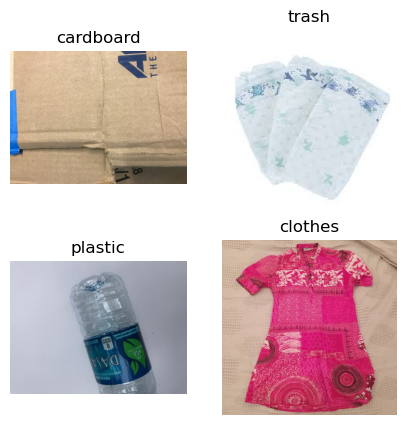

In [24]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Biological: 788
Plastic: 2013
Paper: 2169
Shoes: 1581
Battery: 756
Trash: 667
Glass: 3272
Cardboard: 1864
Clothes: 4260
Metal: 1494

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

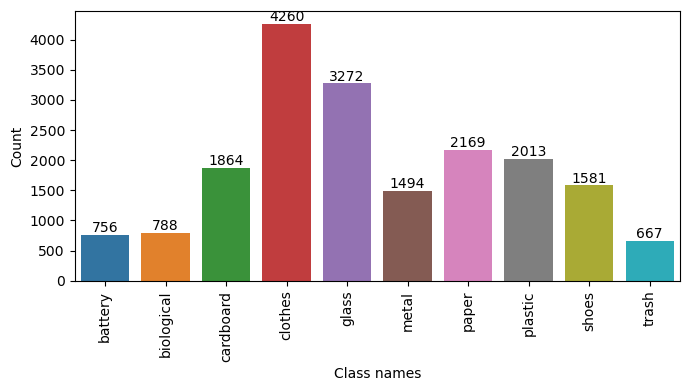

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in biological
Deleted 1013 in plastic
Deleted 1169 in paper
Deleted 581 in shoes
Deleted 0 in battery
Deleted 0 in trash


[codecarbon INFO @ 23:06:58] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:06:58] Energy consumed for all GPUs : 0.000584 kWh. Total GPU Power : 20.140586476618303 W
[codecarbon INFO @ 23:06:58] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:58] 0.002167 kWh of electricity used since the beginning.


Deleted 2272 in glass
Deleted 864 in cardboard
Deleted 3260 in clothes
Deleted 494 in metal


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

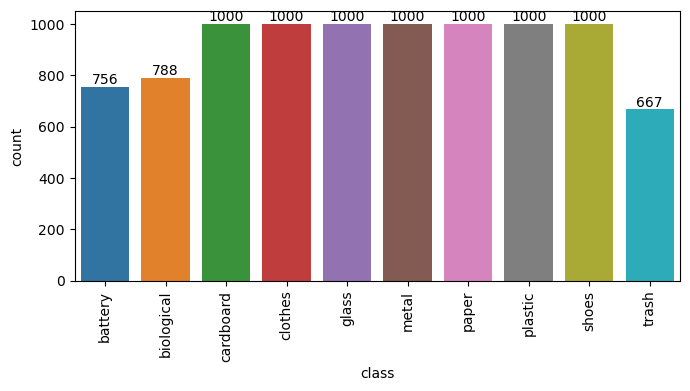

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 415.3261
Mean Height: 393.8024


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:

prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 23:07:11] Energy consumed for RAM : 0.000386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:11] Energy consumed for all GPUs : 0.000673 kWh. Total GPU Power : 23.895646771695827 W
[codecarbon INFO @ 23:07:11] Energy consumed for all CPUs : 0.001397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:11] 0.002456 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.001111709280527446 kg


# Building the model

In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon INFO @ 23:07:11] [setup] RAM Tracking...
[codecarbon INFO @ 23:07:11] [setup] GPU Tracking...
[codecarbon INFO @ 23:07:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:07:11] [setup] CPU Tracking...
[codecarbon WARNING @ 23:07:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:07:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:07:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:07:12] >>> Tracker's metadata:
[codecarbon INFO @ 23:07:12]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:07:12]   Python version: 3.10.10
[codecarbon INFO @ 23:07:12]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 23:07:12]   Available RAM : 31.358 GB
[codecarbon INFO @ 23:07:12]   CPU count: 4
[codecarbon INFO @ 23:07:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:07:12]   GPU

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the ResNet50 model was selected.


Loading the model

In [43]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94765736/94765736 [==============================] - 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

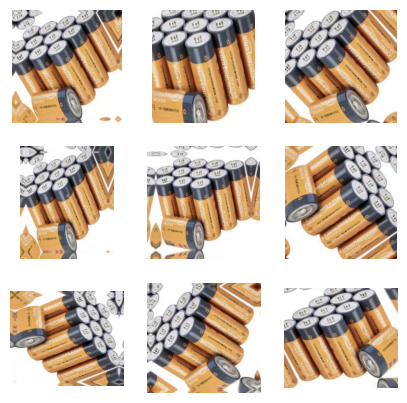

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="ResNet50"

ResNet50_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
ResNet50_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
ResNet50_model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                129

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
ResNet50_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()

tracker = EmissionsTracker()
tracker.start()
    
ResNet50_history = ResNet50_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=ResNet50_callback)

[codecarbon INFO @ 23:07:26] [setup] RAM Tracking...
[codecarbon INFO @ 23:07:26] [setup] GPU Tracking...
[codecarbon INFO @ 23:07:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:07:26] [setup] CPU Tracking...
[codecarbon WARNING @ 23:07:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:07:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:07:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:07:27] >>> Tracker's metadata:
[codecarbon INFO @ 23:07:27]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:07:27]   Python version: 3.10.10
[codecarbon INFO @ 23:07:27]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 23:07:27]   Available RAM : 31.358 GB
[codecarbon INFO @ 23:07:27]   CPU count: 4
[codecarbon INFO @ 23:07:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 23:07:27]   GPU

Epoch 1/20


[codecarbon INFO @ 23:07:31] Energy consumed for RAM : 0.000050 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:31] Energy consumed for all GPUs : 0.000234 kWh. Total GPU Power : 55.20518085632556 W
[codecarbon INFO @ 23:07:31] Energy consumed for all CPUs : 0.000180 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:31] 0.000463 kWh of electricity used since the beginning.


  2/288 [..............................] - ETA: 16:44 - loss: 2.9090 - accuracy: 0.1094

[codecarbon INFO @ 23:07:45] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:45] Energy consumed for all GPUs : 0.000320 kWh. Total GPU Power : 76.73210019987692 W
[codecarbon INFO @ 23:07:45] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:45] 0.000546 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:07:46] Energy consumed for RAM : 0.000099 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:07:46] Energy consumed for all GPUs : 0.000562 kWh. Total GPU Power : 78.94788391116171 W
[codecarbon INFO @ 23:07:46] Energy consumed for all CPUs : 0.000357 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:46] 0.001017 kWh of electricity used since the beginning.


  6/288 [..............................] - ETA: 16:24 - loss: 2.4028 - accuracy: 0.1927

[codecarbon INFO @ 23:08:00] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:00] Energy consumed for all GPUs : 0.000727 kWh. Total GPU Power : 97.89987825160115 W
[codecarbon INFO @ 23:08:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:00] 0.001180 kWh of electricity used since the beginning.


  7/288 [..............................] - ETA: 15:40 - loss: 2.3540 - accuracy: 0.2143

[codecarbon INFO @ 23:08:01] Energy consumed for RAM : 0.000148 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:01] Energy consumed for all GPUs : 0.000969 kWh. Total GPU Power : 97.85915799938462 W
[codecarbon INFO @ 23:08:01] Energy consumed for all CPUs : 0.000534 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:01] 0.001651 kWh of electricity used since the beginning.


 11/288 [>.............................] - ETA: 14:36 - loss: 2.0694 - accuracy: 0.3068

[codecarbon INFO @ 23:08:15] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:15] Energy consumed for all GPUs : 0.001135 kWh. Total GPU Power : 97.99495560535333 W
[codecarbon INFO @ 23:08:15] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:15] 0.001814 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:08:16] Energy consumed for RAM : 0.000197 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:16] Energy consumed for all GPUs : 0.001377 kWh. Total GPU Power : 97.97638170606433 W
[codecarbon INFO @ 23:08:16] Energy consumed for all CPUs : 0.000711 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:16] 0.002285 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 14:24 - loss: 1.8386 - accuracy: 0.3809

[codecarbon INFO @ 23:08:30] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:30] Energy consumed for all GPUs : 0.001544 kWh. Total GPU Power : 98.18152780946754 W
[codecarbon INFO @ 23:08:30] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:30] 0.002449 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:08:31] Energy consumed for RAM : 0.000246 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:31] Energy consumed for all GPUs : 0.001786 kWh. Total GPU Power : 98.18341654363769 W
[codecarbon INFO @ 23:08:31] Energy consumed for all CPUs : 0.000888 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:31] 0.002920 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 13:47 - loss: 1.7235 - accuracy: 0.4122

[codecarbon INFO @ 23:08:45] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:45] Energy consumed for all GPUs : 0.001953 kWh. Total GPU Power : 98.23958998446888 W
[codecarbon INFO @ 23:08:45] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:45] 0.003084 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:08:46] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:08:46] Energy consumed for all GPUs : 0.002196 kWh. Total GPU Power : 98.29080504054934 W
[codecarbon INFO @ 23:08:46] Energy consumed for all CPUs : 0.001065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:46] 0.003555 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 13:18 - loss: 1.5685 - accuracy: 0.4711

[codecarbon INFO @ 23:09:00] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:00] Energy consumed for all GPUs : 0.002363 kWh. Total GPU Power : 98.32281500311694 W
[codecarbon INFO @ 23:09:00] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:00] 0.003719 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:01] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:01] Energy consumed for all GPUs : 0.002605 kWh. Total GPU Power : 98.28983099020999 W
[codecarbon INFO @ 23:09:01] Energy consumed for all CPUs : 0.001242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:01] 0.004190 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 12:26 - loss: 1.4707 - accuracy: 0.5000

[codecarbon INFO @ 23:09:15] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:15] Energy consumed for all GPUs : 0.002774 kWh. Total GPU Power : 98.79662255944585 W
[codecarbon INFO @ 23:09:15] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:15] 0.004357 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:16] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:16] Energy consumed for all GPUs : 0.003017 kWh. Total GPU Power : 98.89095926953968 W
[codecarbon INFO @ 23:09:16] Energy consumed for all CPUs : 0.001419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:16] 0.004828 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 12:20 - loss: 1.4135 - accuracy: 0.5115

[codecarbon INFO @ 23:09:30] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:30] Energy consumed for all GPUs : 0.003184 kWh. Total GPU Power : 98.24526570968791 W
[codecarbon INFO @ 23:09:30] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:30] 0.004992 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:31] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:31] Energy consumed for all GPUs : 0.003425 kWh. Total GPU Power : 98.19038458675765 W
[codecarbon INFO @ 23:09:31] Energy consumed for all CPUs : 0.001596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:31] 0.005463 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 11:44 - loss: 1.3387 - accuracy: 0.5355

[codecarbon INFO @ 23:09:45] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:45] Energy consumed for all GPUs : 0.003592 kWh. Total GPU Power : 97.99665582432608 W
[codecarbon INFO @ 23:09:45] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:45] 0.005626 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:46] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:09:46] Energy consumed for all GPUs : 0.003834 kWh. Total GPU Power : 98.04790602367902 W
[codecarbon INFO @ 23:09:46] Energy consumed for all CPUs : 0.001773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:46] 0.006097 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 11:04 - loss: 1.2805 - accuracy: 0.5556

[codecarbon INFO @ 23:10:00] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:00] Energy consumed for all GPUs : 0.003999 kWh. Total GPU Power : 97.72151462265116 W
[codecarbon INFO @ 23:10:00] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:00] 0.006259 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:01] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:01] Energy consumed for all GPUs : 0.004241 kWh. Total GPU Power : 97.72271988942246 W
[codecarbon INFO @ 23:10:01] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:01] 0.006730 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 10:50 - loss: 1.2264 - accuracy: 0.5765

[codecarbon INFO @ 23:10:15] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:15] Energy consumed for all GPUs : 0.004405 kWh. Total GPU Power : 97.61928268688261 W
[codecarbon INFO @ 23:10:15] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:15] 0.006892 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:16] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:16] Energy consumed for all GPUs : 0.004647 kWh. Total GPU Power : 97.61380937381995 W
[codecarbon INFO @ 23:10:16] Energy consumed for all CPUs : 0.002127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:16] 0.007363 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 10:34 - loss: 1.1967 - accuracy: 0.5886

[codecarbon INFO @ 23:10:30] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:30] Energy consumed for all GPUs : 0.004813 kWh. Total GPU Power : 97.93500333648468 W
[codecarbon INFO @ 23:10:30] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:30] 0.007526 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 10:29 - loss: 1.1856 - accuracy: 0.5922

[codecarbon INFO @ 23:10:31] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:31] Energy consumed for all GPUs : 0.005055 kWh. Total GPU Power : 97.86512858515084 W
[codecarbon INFO @ 23:10:31] Energy consumed for all CPUs : 0.002304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:31] 0.007997 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 10:14 - loss: 1.1445 - accuracy: 0.6087

[codecarbon INFO @ 23:10:45] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:45] Energy consumed for all GPUs : 0.005219 kWh. Total GPU Power : 97.53753634475866 W
[codecarbon INFO @ 23:10:45] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:45] 0.008158 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:46] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:10:46] Energy consumed for all GPUs : 0.005461 kWh. Total GPU Power : 97.60463986009522 W
[codecarbon INFO @ 23:10:46] Energy consumed for all CPUs : 0.002482 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:46] 0.008629 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 10:04 - loss: 1.1072 - accuracy: 0.6211

[codecarbon INFO @ 23:11:00] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:00] Energy consumed for all GPUs : 0.005626 kWh. Total GPU Power : 97.70956331548611 W
[codecarbon INFO @ 23:11:00] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:00] 0.008791 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:01] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:01] Energy consumed for all GPUs : 0.005868 kWh. Total GPU Power : 97.72659902129543 W
[codecarbon INFO @ 23:11:01] Energy consumed for all CPUs : 0.002659 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:01] 0.009262 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 9:34 - loss: 1.0851 - accuracy: 0.6329

[codecarbon INFO @ 23:11:15] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:15] Energy consumed for all GPUs : 0.006032 kWh. Total GPU Power : 97.46093197432621 W
[codecarbon INFO @ 23:11:15] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:15] 0.009423 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:16] Energy consumed for RAM : 0.000784 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:16] Energy consumed for all GPUs : 0.006274 kWh. Total GPU Power : 97.53920832467517 W
[codecarbon INFO @ 23:11:16] Energy consumed for all CPUs : 0.002836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:16] 0.009894 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 9:12 - loss: 1.0615 - accuracy: 0.6438

[codecarbon INFO @ 23:11:30] Energy consumed for RAM : 0.000783 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:30] Energy consumed for all GPUs : 0.006440 kWh. Total GPU Power : 97.79664398141874 W
[codecarbon INFO @ 23:11:30] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:30] 0.010056 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:31] Energy consumed for RAM : 0.000833 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:31] Energy consumed for all GPUs : 0.006682 kWh. Total GPU Power : 97.78166315487074 W
[codecarbon INFO @ 23:11:31] Energy consumed for all CPUs : 0.003013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:31] 0.010527 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 8:51 - loss: 1.0406 - accuracy: 0.6508

[codecarbon INFO @ 23:11:45] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:45] Energy consumed for all GPUs : 0.006845 kWh. Total GPU Power : 97.49017528091781 W
[codecarbon INFO @ 23:11:45] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:45] 0.010688 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 8:47 - loss: 1.0373 - accuracy: 0.6522

[codecarbon INFO @ 23:11:46] Energy consumed for RAM : 0.000882 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:11:46] Energy consumed for all GPUs : 0.007087 kWh. Total GPU Power : 97.41178174862645 W
[codecarbon INFO @ 23:11:46] Energy consumed for all CPUs : 0.003190 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:46] 0.011159 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 8:27 - loss: 1.0141 - accuracy: 0.6614

[codecarbon INFO @ 23:12:00] Energy consumed for RAM : 0.000881 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:00] Energy consumed for all GPUs : 0.007252 kWh. Total GPU Power : 97.619732698051 W
[codecarbon INFO @ 23:12:00] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:00] 0.011321 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:12:01] Energy consumed for RAM : 0.000931 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:01] Energy consumed for all GPUs : 0.007494 kWh. Total GPU Power : 97.64206171076168 W
[codecarbon INFO @ 23:12:01] Energy consumed for all CPUs : 0.003367 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:01] 0.011792 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 8:07 - loss: 0.9944 - accuracy: 0.6665

[codecarbon INFO @ 23:12:15] Energy consumed for RAM : 0.000930 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:15] Energy consumed for all GPUs : 0.007660 kWh. Total GPU Power : 97.90311488899621 W
[codecarbon INFO @ 23:12:15] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:15] 0.011955 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:12:16] Energy consumed for RAM : 0.000980 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:16] Energy consumed for all GPUs : 0.007900 kWh. Total GPU Power : 97.41254431593099 W
[codecarbon INFO @ 23:12:16] Energy consumed for all CPUs : 0.003544 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:16] 0.012424 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 7:44 - loss: 0.9764 - accuracy: 0.6726

[codecarbon INFO @ 23:12:30] Energy consumed for RAM : 0.000979 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:30] Energy consumed for all GPUs : 0.008064 kWh. Total GPU Power : 97.05783480178864 W
[codecarbon INFO @ 23:12:30] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:30] 0.012585 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:12:31] Energy consumed for RAM : 0.001029 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:31] Energy consumed for all GPUs : 0.008306 kWh. Total GPU Power : 97.58889844034584 W
[codecarbon INFO @ 23:12:31] Energy consumed for all CPUs : 0.003721 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:31] 0.013056 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 7:31 - loss: 0.9593 - accuracy: 0.6789

[codecarbon INFO @ 23:12:45] Energy consumed for RAM : 0.001028 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:45] Energy consumed for all GPUs : 0.008470 kWh. Total GPU Power : 97.50381691847304 W
[codecarbon INFO @ 23:12:45] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:45] 0.013217 kWh of electricity used since the beginning.


117/288 [===========>..................] - ETA: 7:29 - loss: 0.9546 - accuracy: 0.6811

[codecarbon INFO @ 23:12:46] Energy consumed for RAM : 0.001078 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:12:46] Energy consumed for all GPUs : 0.008712 kWh. Total GPU Power : 97.4631549124538 W
[codecarbon INFO @ 23:12:46] Energy consumed for all CPUs : 0.003898 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:46] 0.013688 kWh of electricity used since the beginning.


124/288 [===========>..................] - ETA: 7:04 - loss: 0.9365 - accuracy: 0.6893

[codecarbon INFO @ 23:13:00] Energy consumed for RAM : 0.001077 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:00] Energy consumed for all GPUs : 0.008876 kWh. Total GPU Power : 97.41896432617793 W
[codecarbon INFO @ 23:13:00] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:00] 0.013849 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:13:01] Energy consumed for RAM : 0.001127 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:01] Energy consumed for all GPUs : 0.009118 kWh. Total GPU Power : 97.40204615617797 W
[codecarbon INFO @ 23:13:01] Energy consumed for all CPUs : 0.004075 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:01] 0.014319 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 6:52 - loss: 0.9291 - accuracy: 0.6899

[codecarbon INFO @ 23:13:15] Energy consumed for RAM : 0.001126 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:15] Energy consumed for all GPUs : 0.009283 kWh. Total GPU Power : 97.81576500995978 W
[codecarbon INFO @ 23:13:15] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:15] 0.014482 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 6:50 - loss: 0.9276 - accuracy: 0.6899

[codecarbon INFO @ 23:13:16] Energy consumed for RAM : 0.001176 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:16] Energy consumed for all GPUs : 0.009523 kWh. Total GPU Power : 97.34314398089374 W
[codecarbon INFO @ 23:13:16] Energy consumed for all CPUs : 0.004252 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:16] 0.014951 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 6:31 - loss: 0.9150 - accuracy: 0.6932

[codecarbon INFO @ 23:13:30] Energy consumed for RAM : 0.001175 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:30] Energy consumed for all GPUs : 0.009689 kWh. Total GPU Power : 97.47015748579469 W
[codecarbon INFO @ 23:13:30] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:30] 0.015114 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:13:31] Energy consumed for RAM : 0.001225 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:31] Energy consumed for all GPUs : 0.009931 kWh. Total GPU Power : 97.97405358490897 W
[codecarbon INFO @ 23:13:31] Energy consumed for all CPUs : 0.004429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:31] 0.015585 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 6:11 - loss: 0.9010 - accuracy: 0.6984

[codecarbon INFO @ 23:13:45] Energy consumed for RAM : 0.001224 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:45] Energy consumed for all GPUs : 0.010095 kWh. Total GPU Power : 97.33918891128782 W
[codecarbon INFO @ 23:13:45] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:45] 0.015746 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:13:46] Energy consumed for RAM : 0.001274 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:13:46] Energy consumed for all GPUs : 0.010335 kWh. Total GPU Power : 96.89511550919964 W
[codecarbon INFO @ 23:13:46] Energy consumed for all CPUs : 0.004606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:46] 0.016215 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 5:56 - loss: 0.8873 - accuracy: 0.7039

[codecarbon INFO @ 23:14:00] Energy consumed for RAM : 0.001273 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:00] Energy consumed for all GPUs : 0.010499 kWh. Total GPU Power : 97.10625348315884 W
[codecarbon INFO @ 23:14:00] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:00] 0.016376 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:01] Energy consumed for RAM : 0.001323 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:01] Energy consumed for all GPUs : 0.010741 kWh. Total GPU Power : 97.49162195482053 W
[codecarbon INFO @ 23:14:01] Energy consumed for all CPUs : 0.004783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:01] 0.016847 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 5:39 - loss: 0.8753 - accuracy: 0.7079

[codecarbon INFO @ 23:14:15] Energy consumed for RAM : 0.001322 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:15] Energy consumed for all GPUs : 0.010906 kWh. Total GPU Power : 97.7610039156221 W
[codecarbon INFO @ 23:14:15] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:15] 0.017009 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:16] Energy consumed for RAM : 0.001372 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:16] Energy consumed for all GPUs : 0.011146 kWh. Total GPU Power : 97.32509974227852 W
[codecarbon INFO @ 23:14:16] Energy consumed for all CPUs : 0.004960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:16] 0.017478 kWh of electricity used since the beginning.


162/288 [===============>..............] - ETA: 5:19 - loss: 0.8631 - accuracy: 0.7112

[codecarbon INFO @ 23:14:30] Energy consumed for RAM : 0.001371 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:30] Energy consumed for all GPUs : 0.011312 kWh. Total GPU Power : 97.48272682384693 W
[codecarbon INFO @ 23:14:30] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:30] 0.017641 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 5:16 - loss: 0.8609 - accuracy: 0.7122

[codecarbon INFO @ 23:14:31] Energy consumed for RAM : 0.001421 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:31] Energy consumed for all GPUs : 0.011554 kWh. Total GPU Power : 97.92394777411766 W
[codecarbon INFO @ 23:14:31] Energy consumed for all CPUs : 0.005138 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:31] 0.018112 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 4:59 - loss: 0.8512 - accuracy: 0.7158

[codecarbon INFO @ 23:14:45] Energy consumed for RAM : 0.001420 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:45] Energy consumed for all GPUs : 0.011717 kWh. Total GPU Power : 97.33556017603706 W
[codecarbon INFO @ 23:14:45] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:45] 0.018273 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 4:56 - loss: 0.8494 - accuracy: 0.7165

[codecarbon INFO @ 23:14:46] Energy consumed for RAM : 0.001470 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:14:46] Energy consumed for all GPUs : 0.011959 kWh. Total GPU Power : 97.34009525053278 W
[codecarbon INFO @ 23:14:46] Energy consumed for all CPUs : 0.005315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:46] 0.018743 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 4:36 - loss: 0.8388 - accuracy: 0.7207

[codecarbon INFO @ 23:15:00] Energy consumed for RAM : 0.001469 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:00] Energy consumed for all GPUs : 0.012124 kWh. Total GPU Power : 97.56255521674662 W
[codecarbon INFO @ 23:15:00] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:00] 0.018905 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:15:01] Energy consumed for RAM : 0.001519 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:01] Energy consumed for all GPUs : 0.012364 kWh. Total GPU Power : 97.13962673776535 W
[codecarbon INFO @ 23:15:01] Energy consumed for all CPUs : 0.005492 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:01] 0.019374 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 4:22 - loss: 0.8325 - accuracy: 0.7228

[codecarbon INFO @ 23:15:15] Energy consumed for RAM : 0.001518 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:15] Energy consumed for all GPUs : 0.012529 kWh. Total GPU Power : 97.31330106177033 W
[codecarbon INFO @ 23:15:15] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:15] 0.019536 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:15:16] Energy consumed for RAM : 0.001568 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:16] Energy consumed for all GPUs : 0.012771 kWh. Total GPU Power : 97.78396460874187 W
[codecarbon INFO @ 23:15:16] Energy consumed for all CPUs : 0.005669 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:16] 0.020007 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 4:09 - loss: 0.8255 - accuracy: 0.7241

[codecarbon INFO @ 23:15:30] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:30] Energy consumed for all GPUs : 0.012935 kWh. Total GPU Power : 97.56825433718402 W
[codecarbon INFO @ 23:15:30] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:30] 0.020168 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 4:07 - loss: 0.8250 - accuracy: 0.7242

[codecarbon INFO @ 23:15:31] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:31] Energy consumed for all GPUs : 0.013177 kWh. Total GPU Power : 97.50139256392787 W
[codecarbon INFO @ 23:15:31] Energy consumed for all CPUs : 0.005846 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:31] 0.020639 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 3:54 - loss: 0.8200 - accuracy: 0.7257

[codecarbon INFO @ 23:15:45] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:45] Energy consumed for all GPUs : 0.013342 kWh. Total GPU Power : 97.6068688553732 W
[codecarbon INFO @ 23:15:45] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:45] 0.020801 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:15:46] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:15:46] Energy consumed for all GPUs : 0.013583 kWh. Total GPU Power : 97.43675536505398 W
[codecarbon INFO @ 23:15:46] Energy consumed for all CPUs : 0.006023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:46] 0.021271 kWh of electricity used since the beginning.


201/288 [===================>..........] - ETA: 3:36 - loss: 0.8130 - accuracy: 0.7284

[codecarbon INFO @ 23:16:00] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:00] Energy consumed for all GPUs : 0.013747 kWh. Total GPU Power : 97.3693106781114 W
[codecarbon INFO @ 23:16:00] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:00] 0.021432 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 3:33 - loss: 0.8136 - accuracy: 0.7285

[codecarbon INFO @ 23:16:01] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:01] Energy consumed for all GPUs : 0.013989 kWh. Total GPU Power : 97.55226442875141 W
[codecarbon INFO @ 23:16:01] Energy consumed for all CPUs : 0.006200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:01] 0.021903 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 3:15 - loss: 0.8061 - accuracy: 0.7310

[codecarbon INFO @ 23:16:15] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:15] Energy consumed for all GPUs : 0.014153 kWh. Total GPU Power : 97.48827653154011 W
[codecarbon INFO @ 23:16:15] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:15] 0.022065 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:16] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:16] Energy consumed for all GPUs : 0.014395 kWh. Total GPU Power : 97.51849185952963 W
[codecarbon INFO @ 23:16:16] Energy consumed for all CPUs : 0.006377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:16] 0.022535 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 2:53 - loss: 0.7961 - accuracy: 0.7343

[codecarbon INFO @ 23:16:30] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:30] Energy consumed for all GPUs : 0.014559 kWh. Total GPU Power : 97.3429015265117 W
[codecarbon INFO @ 23:16:30] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:30] 0.022696 kWh of electricity used since the beginning.


218/288 [=====================>........] - ETA: 2:50 - loss: 0.7941 - accuracy: 0.7352

[codecarbon INFO @ 23:16:31] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:31] Energy consumed for all GPUs : 0.014800 kWh. Total GPU Power : 97.3580611178306 W
[codecarbon INFO @ 23:16:31] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:31] 0.023167 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 2:32 - loss: 0.7861 - accuracy: 0.7372

[codecarbon INFO @ 23:16:45] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:45] Energy consumed for all GPUs : 0.014965 kWh. Total GPU Power : 97.51532163631802 W
[codecarbon INFO @ 23:16:45] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:45] 0.023328 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:46] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:16:46] Energy consumed for all GPUs : 0.015207 kWh. Total GPU Power : 97.58532590870786 W
[codecarbon INFO @ 23:16:46] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:46] 0.023799 kWh of electricity used since the beginning.


231/288 [=======================>......] - ETA: 2:18 - loss: 0.7808 - accuracy: 0.7388

[codecarbon INFO @ 23:17:00] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:00] Energy consumed for all GPUs : 0.015370 kWh. Total GPU Power : 97.2929871775016 W
[codecarbon INFO @ 23:17:00] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:00] 0.023959 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 2:15 - loss: 0.7798 - accuracy: 0.7390

[codecarbon INFO @ 23:17:01] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:01] Energy consumed for all GPUs : 0.015612 kWh. Total GPU Power : 97.2338663959542 W
[codecarbon INFO @ 23:17:01] Energy consumed for all CPUs : 0.006908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:01] 0.024430 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 1:49 - loss: 0.7656 - accuracy: 0.7435

[codecarbon INFO @ 23:17:15] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:15] Energy consumed for all GPUs : 0.015776 kWh. Total GPU Power : 97.50557656469469 W
[codecarbon INFO @ 23:17:15] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:15] 0.024591 kWh of electricity used since the beginning.


243/288 [========================>.....] - ETA: 1:46 - loss: 0.7639 - accuracy: 0.7441

[codecarbon INFO @ 23:17:16] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:16] Energy consumed for all GPUs : 0.016018 kWh. Total GPU Power : 97.54639880892412 W
[codecarbon INFO @ 23:17:16] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:16] 0.025062 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 1:29 - loss: 0.7592 - accuracy: 0.7462

[codecarbon INFO @ 23:17:30] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:30] Energy consumed for all GPUs : 0.016181 kWh. Total GPU Power : 97.32586184233475 W
[codecarbon INFO @ 23:17:30] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:30] 0.025223 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 1:27 - loss: 0.7574 - accuracy: 0.7469

[codecarbon INFO @ 23:17:31] Energy consumed for RAM : 0.002008 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:31] Energy consumed for all GPUs : 0.016423 kWh. Total GPU Power : 97.37098859098589 W
[codecarbon INFO @ 23:17:31] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:31] 0.025694 kWh of electricity used since the beginning.


260/288 [==========================>...] - ETA: 1:05 - loss: 0.7475 - accuracy: 0.7496

[codecarbon INFO @ 23:17:45] Energy consumed for RAM : 0.002008 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:45] Energy consumed for all GPUs : 0.016587 kWh. Total GPU Power : 97.40601634028403 W
[codecarbon INFO @ 23:17:45] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:45] 0.025855 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:17:46] Energy consumed for RAM : 0.002057 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:17:46] Energy consumed for all GPUs : 0.016829 kWh. Total GPU Power : 97.44547459690276 W
[codecarbon INFO @ 23:17:46] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:46] 0.026325 kWh of electricity used since the beginning.


266/288 [==========================>...] - ETA: 51s - loss: 0.7419 - accuracy: 0.7507

[codecarbon INFO @ 23:18:00] Energy consumed for RAM : 0.002057 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:00] Energy consumed for all GPUs : 0.016992 kWh. Total GPU Power : 97.39330045814515 W
[codecarbon INFO @ 23:18:00] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:00] 0.026486 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 48s - loss: 0.7414 - accuracy: 0.7513

[codecarbon INFO @ 23:18:01] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:01] Energy consumed for all GPUs : 0.017234 kWh. Total GPU Power : 97.3333284239022 W
[codecarbon INFO @ 23:18:01] Energy consumed for all CPUs : 0.007616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:01] 0.026957 kWh of electricity used since the beginning.


274/288 [===========================>..] - ETA: 32s - loss: 0.7344 - accuracy: 0.7542

[codecarbon INFO @ 23:18:15] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:15] Energy consumed for all GPUs : 0.017399 kWh. Total GPU Power : 97.59567577095449 W
[codecarbon INFO @ 23:18:15] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:15] 0.027118 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:16] Energy consumed for RAM : 0.002155 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:16] Energy consumed for all GPUs : 0.017641 kWh. Total GPU Power : 97.58857722779668 W
[codecarbon INFO @ 23:18:16] Energy consumed for all CPUs : 0.007794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:16] 0.027589 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 16s - loss: 0.7284 - accuracy: 0.7557

[codecarbon INFO @ 23:18:30] Energy consumed for RAM : 0.002154 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:30] Energy consumed for all GPUs : 0.017805 kWh. Total GPU Power : 97.48437177255569 W
[codecarbon INFO @ 23:18:30] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:30] 0.027751 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 13s - loss: 0.7276 - accuracy: 0.7561

[codecarbon INFO @ 23:18:31] Energy consumed for RAM : 0.002204 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:31] Energy consumed for all GPUs : 0.018047 kWh. Total GPU Power : 97.48559835188078 W
[codecarbon INFO @ 23:18:31] Energy consumed for all CPUs : 0.007971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:31] 0.028221 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.7566

[codecarbon INFO @ 23:18:45] Energy consumed for RAM : 0.002203 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:45] Energy consumed for all GPUs : 0.018197 kWh. Total GPU Power : 94.2140448553694 W
[codecarbon INFO @ 23:18:45] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:45] 0.028369 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:46] Energy consumed for RAM : 0.002253 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:18:46] Energy consumed for all GPUs : 0.018439 kWh. Total GPU Power : 94.23864929526174 W
[codecarbon INFO @ 23:18:46] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:46] 0.028840 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:00] Energy consumed for RAM : 0.002252 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:00] Energy consumed for all GPUs : 0.018602 kWh. Total GPU Power : 97.259762059848

288/288 [==============================] - 702s 2s/step - loss: 0.7251 - accuracy: 0.7566 - val_loss: 0.4015 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 2/20
  1/288 [..............................] - ETA: 12:26 - loss: 0.4709 - accuracy: 0.8125

[codecarbon INFO @ 23:19:15] Energy consumed for RAM : 0.002301 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:15] Energy consumed for all GPUs : 0.019000 kWh. Total GPU Power : 95.53193846104551 W
[codecarbon INFO @ 23:19:15] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:15] 0.029624 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:16] Energy consumed for RAM : 0.002351 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:16] Energy consumed for all GPUs : 0.019242 kWh. Total GPU Power : 95.50293808203533 W
[codecarbon INFO @ 23:19:16] Energy consumed for all CPUs : 0.008502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:16] 0.030095 kWh of electricity used since the beginning.


  8/288 [..............................] - ETA: 10:13 - loss: 0.5112 - accuracy: 0.8047

[codecarbon INFO @ 23:19:30] Energy consumed for RAM : 0.002350 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:30] Energy consumed for all GPUs : 0.019406 kWh. Total GPU Power : 97.54093181986931 W
[codecarbon INFO @ 23:19:30] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:30] 0.030256 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:31] Energy consumed for RAM : 0.002400 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:31] Energy consumed for all GPUs : 0.019648 kWh. Total GPU Power : 97.56240633911021 W
[codecarbon INFO @ 23:19:31] Energy consumed for all CPUs : 0.008679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:31] 0.030727 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 9:37 - loss: 0.4782 - accuracy: 0.8250

[codecarbon INFO @ 23:19:45] Energy consumed for RAM : 0.002399 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:45] Energy consumed for all GPUs : 0.019812 kWh. Total GPU Power : 97.37351009086585 W
[codecarbon INFO @ 23:19:45] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:45] 0.030888 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 9:19 - loss: 0.4992 - accuracy: 0.8184

[codecarbon INFO @ 23:19:46] Energy consumed for RAM : 0.002449 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:19:46] Energy consumed for all GPUs : 0.020054 kWh. Total GPU Power : 97.35038774708535 W
[codecarbon INFO @ 23:19:46] Energy consumed for all CPUs : 0.008856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:46] 0.031359 kWh of electricity used since the beginning.


 25/288 [=>............................] - ETA: 8:10 - loss: 0.4934 - accuracy: 0.8263

[codecarbon INFO @ 23:20:00] Energy consumed for RAM : 0.002448 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:00] Energy consumed for all GPUs : 0.020217 kWh. Total GPU Power : 97.40214398122343 W
[codecarbon INFO @ 23:20:00] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:00] 0.031519 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:20:01] Energy consumed for RAM : 0.002498 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:01] Energy consumed for all GPUs : 0.020459 kWh. Total GPU Power : 97.37650555511854 W
[codecarbon INFO @ 23:20:01] Energy consumed for all CPUs : 0.009033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:01] 0.031990 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 8:07 - loss: 0.4899 - accuracy: 0.8301

[codecarbon INFO @ 23:20:15] Energy consumed for RAM : 0.002497 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:15] Energy consumed for all GPUs : 0.020623 kWh. Total GPU Power : 97.27939304155609 W
[codecarbon INFO @ 23:20:15] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:15] 0.032150 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 8:07 - loss: 0.4819 - accuracy: 0.8333

[codecarbon INFO @ 23:20:16] Energy consumed for RAM : 0.002547 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:16] Energy consumed for all GPUs : 0.020864 kWh. Total GPU Power : 97.20871980256479 W
[codecarbon INFO @ 23:20:16] Energy consumed for all CPUs : 0.009210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:16] 0.032621 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 7:59 - loss: 0.4801 - accuracy: 0.8328

[codecarbon INFO @ 23:20:30] Energy consumed for RAM : 0.002546 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:30] Energy consumed for all GPUs : 0.021029 kWh. Total GPU Power : 97.56006284763968 W
[codecarbon INFO @ 23:20:30] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:30] 0.032783 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:20:31] Energy consumed for RAM : 0.002596 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:31] Energy consumed for all GPUs : 0.021271 kWh. Total GPU Power : 97.62086521485561 W
[codecarbon INFO @ 23:20:31] Energy consumed for all CPUs : 0.009387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:31] 0.033254 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 7:36 - loss: 0.4766 - accuracy: 0.8333

[codecarbon INFO @ 23:20:45] Energy consumed for RAM : 0.002595 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:45] Energy consumed for all GPUs : 0.021434 kWh. Total GPU Power : 97.29392372216849 W
[codecarbon INFO @ 23:20:45] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:45] 0.033414 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 7:31 - loss: 0.4762 - accuracy: 0.8348

[codecarbon INFO @ 23:20:46] Energy consumed for RAM : 0.002645 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:20:46] Energy consumed for all GPUs : 0.021676 kWh. Total GPU Power : 97.33264260820916 W
[codecarbon INFO @ 23:20:46] Energy consumed for all CPUs : 0.009564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:46] 0.033885 kWh of electricity used since the beginning.


 60/288 [=====>........................] - ETA: 6:44 - loss: 0.4672 - accuracy: 0.8406

[codecarbon INFO @ 23:21:00] Energy consumed for RAM : 0.002644 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:00] Energy consumed for all GPUs : 0.021840 kWh. Total GPU Power : 97.43964815529533 W
[codecarbon INFO @ 23:21:00] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:00] 0.034046 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:01] Energy consumed for RAM : 0.002694 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:01] Energy consumed for all GPUs : 0.022082 kWh. Total GPU Power : 97.41846929683815 W
[codecarbon INFO @ 23:21:01] Energy consumed for all CPUs : 0.009741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:01] 0.034517 kWh of electricity used since the beginning.


 69/288 [======>.......................] - ETA: 6:26 - loss: 0.4699 - accuracy: 0.8401

[codecarbon INFO @ 23:21:15] Energy consumed for RAM : 0.002693 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:15] Energy consumed for all GPUs : 0.022245 kWh. Total GPU Power : 97.23906002255315 W
[codecarbon INFO @ 23:21:15] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:15] 0.034677 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:16] Energy consumed for RAM : 0.002743 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:16] Energy consumed for all GPUs : 0.022487 kWh. Total GPU Power : 97.21858723480815 W
[codecarbon INFO @ 23:21:16] Energy consumed for all CPUs : 0.009918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:16] 0.035148 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 6:19 - loss: 0.4671 - accuracy: 0.8438

[codecarbon INFO @ 23:21:30] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:30] Energy consumed for all GPUs : 0.022651 kWh. Total GPU Power : 97.46053766202773 W
[codecarbon INFO @ 23:21:30] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:30] 0.035309 kWh of electricity used since the beginning.


 77/288 [=======>......................] - ETA: 6:18 - loss: 0.4663 - accuracy: 0.8438

[codecarbon INFO @ 23:21:31] Energy consumed for RAM : 0.002792 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:31] Energy consumed for all GPUs : 0.022893 kWh. Total GPU Power : 97.52149986258195 W
[codecarbon INFO @ 23:21:31] Energy consumed for all CPUs : 0.010095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:31] 0.035780 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 5:53 - loss: 0.4640 - accuracy: 0.8427

[codecarbon INFO @ 23:21:45] Energy consumed for RAM : 0.002791 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:45] Energy consumed for all GPUs : 0.023056 kWh. Total GPU Power : 97.39671569753729 W
[codecarbon INFO @ 23:21:45] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:45] 0.035940 kWh of electricity used since the beginning.


 87/288 [========>.....................] - ETA: 5:53 - loss: 0.4632 - accuracy: 0.8434

[codecarbon INFO @ 23:21:46] Energy consumed for RAM : 0.002841 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:21:46] Energy consumed for all GPUs : 0.023298 kWh. Total GPU Power : 97.34291944470434 W
[codecarbon INFO @ 23:21:46] Energy consumed for all CPUs : 0.010273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:46] 0.036411 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 5:47 - loss: 0.4634 - accuracy: 0.8434

[codecarbon INFO @ 23:22:00] Energy consumed for RAM : 0.002840 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:00] Energy consumed for all GPUs : 0.023462 kWh. Total GPU Power : 97.47580633449046 W
[codecarbon INFO @ 23:22:00] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:00] 0.036573 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:22:01] Energy consumed for RAM : 0.002890 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:01] Energy consumed for all GPUs : 0.023704 kWh. Total GPU Power : 97.497566539609 W
[codecarbon INFO @ 23:22:01] Energy consumed for all CPUs : 0.010450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:01] 0.037044 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 5:40 - loss: 0.4657 - accuracy: 0.8413

[codecarbon INFO @ 23:22:15] Energy consumed for RAM : 0.002889 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:15] Energy consumed for all GPUs : 0.023869 kWh. Total GPU Power : 97.53518647623389 W
[codecarbon INFO @ 23:22:15] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:15] 0.037205 kWh of electricity used since the beginning.


101/288 [=========>....................] - ETA: 5:38 - loss: 0.4643 - accuracy: 0.8425

[codecarbon INFO @ 23:22:16] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:16] Energy consumed for all GPUs : 0.024110 kWh. Total GPU Power : 97.49292920160977 W
[codecarbon INFO @ 23:22:16] Energy consumed for all CPUs : 0.010627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:16] 0.037676 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 5:19 - loss: 0.4610 - accuracy: 0.8449

[codecarbon INFO @ 23:22:30] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:30] Energy consumed for all GPUs : 0.024274 kWh. Total GPU Power : 97.34071402512315 W
[codecarbon INFO @ 23:22:30] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:30] 0.037836 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 5:20 - loss: 0.4588 - accuracy: 0.8457

[codecarbon INFO @ 23:22:31] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:31] Energy consumed for all GPUs : 0.024515 kWh. Total GPU Power : 97.22090774443745 W
[codecarbon INFO @ 23:22:31] Energy consumed for all CPUs : 0.010804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:31] 0.038307 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 5:00 - loss: 0.4519 - accuracy: 0.8487

[codecarbon INFO @ 23:22:45] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:45] Energy consumed for all GPUs : 0.024680 kWh. Total GPU Power : 97.44838821345445 W
[codecarbon INFO @ 23:22:45] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:45] 0.038468 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:22:46] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:22:46] Energy consumed for all GPUs : 0.024922 kWh. Total GPU Power : 97.55488998499254 W
[codecarbon INFO @ 23:22:46] Energy consumed for all CPUs : 0.010981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:46] 0.038939 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 4:43 - loss: 0.4537 - accuracy: 0.8489

[codecarbon INFO @ 23:23:00] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:00] Energy consumed for all GPUs : 0.025085 kWh. Total GPU Power : 97.26525298042583 W
[codecarbon INFO @ 23:23:00] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:00] 0.039099 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:01] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:01] Energy consumed for all GPUs : 0.025327 kWh. Total GPU Power : 97.3347434865096 W
[codecarbon INFO @ 23:23:01] Energy consumed for all CPUs : 0.011158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:01] 0.039570 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 4:25 - loss: 0.4516 - accuracy: 0.8506

[codecarbon INFO @ 23:23:15] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:15] Energy consumed for all GPUs : 0.025491 kWh. Total GPU Power : 97.54379509359052 W
[codecarbon INFO @ 23:23:15] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:15] 0.039731 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 4:23 - loss: 0.4516 - accuracy: 0.8503

[codecarbon INFO @ 23:23:16] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:16] Energy consumed for all GPUs : 0.025733 kWh. Total GPU Power : 97.43880246017909 W
[codecarbon INFO @ 23:23:16] Energy consumed for all CPUs : 0.011335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:16] 0.040202 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 4:06 - loss: 0.4539 - accuracy: 0.8506

[codecarbon INFO @ 23:23:30] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:30] Energy consumed for all GPUs : 0.025896 kWh. Total GPU Power : 97.26116424836711 W
[codecarbon INFO @ 23:23:30] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:30] 0.040363 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:31] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:31] Energy consumed for all GPUs : 0.026138 kWh. Total GPU Power : 97.29351161535469 W
[codecarbon INFO @ 23:23:31] Energy consumed for all CPUs : 0.011512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:31] 0.040833 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 3:53 - loss: 0.4532 - accuracy: 0.8522

[codecarbon INFO @ 23:23:45] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:45] Energy consumed for all GPUs : 0.026302 kWh. Total GPU Power : 97.48693585190851 W
[codecarbon INFO @ 23:23:45] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:45] 0.040995 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:46] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:23:46] Energy consumed for all GPUs : 0.026544 kWh. Total GPU Power : 97.50888036894679 W
[codecarbon INFO @ 23:23:46] Energy consumed for all CPUs : 0.011689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:46] 0.041466 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 3:39 - loss: 0.4525 - accuracy: 0.8522

[codecarbon INFO @ 23:24:00] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:00] Energy consumed for all GPUs : 0.026707 kWh. Total GPU Power : 97.32531305359588 W
[codecarbon INFO @ 23:24:00] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:00] 0.041626 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 3:37 - loss: 0.4511 - accuracy: 0.8527

[codecarbon INFO @ 23:24:01] Energy consumed for RAM : 0.003281 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:01] Energy consumed for all GPUs : 0.026949 kWh. Total GPU Power : 97.28004585904387 W
[codecarbon INFO @ 23:24:01] Energy consumed for all CPUs : 0.011866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:01] 0.042097 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 3:20 - loss: 0.4486 - accuracy: 0.8539

[codecarbon INFO @ 23:24:15] Energy consumed for RAM : 0.003281 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:15] Energy consumed for all GPUs : 0.027113 kWh. Total GPU Power : 97.35116084587465 W
[codecarbon INFO @ 23:24:15] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:15] 0.042257 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:24:16] Energy consumed for RAM : 0.003330 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:16] Energy consumed for all GPUs : 0.027355 kWh. Total GPU Power : 97.35209462064455 W
[codecarbon INFO @ 23:24:16] Energy consumed for all CPUs : 0.012043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:16] 0.042728 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 3:00 - loss: 0.4500 - accuracy: 0.8526

[codecarbon INFO @ 23:24:30] Energy consumed for RAM : 0.003330 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:30] Energy consumed for all GPUs : 0.027518 kWh. Total GPU Power : 97.1576399205718 W
[codecarbon INFO @ 23:24:30] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:30] 0.042888 kWh of electricity used since the beginning.


184/288 [==================>...........] - ETA: 2:59 - loss: 0.4487 - accuracy: 0.8531

[codecarbon INFO @ 23:24:31] Energy consumed for RAM : 0.003379 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:31] Energy consumed for all GPUs : 0.027759 kWh. Total GPU Power : 97.14999786439535 W
[codecarbon INFO @ 23:24:31] Energy consumed for all CPUs : 0.012220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:31] 0.043359 kWh of electricity used since the beginning.


193/288 [===================>..........] - ETA: 2:42 - loss: 0.4500 - accuracy: 0.8530

[codecarbon INFO @ 23:24:45] Energy consumed for RAM : 0.003379 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:45] Energy consumed for all GPUs : 0.027923 kWh. Total GPU Power : 97.44352847371299 W
[codecarbon INFO @ 23:24:45] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:45] 0.043520 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 2:41 - loss: 0.4492 - accuracy: 0.8534

[codecarbon INFO @ 23:24:46] Energy consumed for RAM : 0.003428 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:24:46] Energy consumed for all GPUs : 0.028165 kWh. Total GPU Power : 97.44578711326872 W
[codecarbon INFO @ 23:24:46] Energy consumed for all CPUs : 0.012397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:46] 0.043991 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 2:24 - loss: 0.4521 - accuracy: 0.8525

[codecarbon INFO @ 23:25:00] Energy consumed for RAM : 0.003428 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:00] Energy consumed for all GPUs : 0.028329 kWh. Total GPU Power : 97.31626135976049 W
[codecarbon INFO @ 23:25:00] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:00] 0.044151 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 2:23 - loss: 0.4516 - accuracy: 0.8525

[codecarbon INFO @ 23:25:01] Energy consumed for RAM : 0.003477 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:01] Energy consumed for all GPUs : 0.028570 kWh. Total GPU Power : 97.2832012874334 W
[codecarbon INFO @ 23:25:01] Energy consumed for all CPUs : 0.012575 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:01] 0.044622 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 2:07 - loss: 0.4511 - accuracy: 0.8531

[codecarbon INFO @ 23:25:15] Energy consumed for RAM : 0.003477 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:15] Energy consumed for all GPUs : 0.028734 kWh. Total GPU Power : 97.40701595579867 W
[codecarbon INFO @ 23:25:15] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:15] 0.044783 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 2:05 - loss: 0.4501 - accuracy: 0.8537

[codecarbon INFO @ 23:25:16] Energy consumed for RAM : 0.003526 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:16] Energy consumed for all GPUs : 0.028976 kWh. Total GPU Power : 97.40100837906279 W
[codecarbon INFO @ 23:25:16] Energy consumed for all CPUs : 0.012752 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:16] 0.045254 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 1:49 - loss: 0.4517 - accuracy: 0.8536

[codecarbon INFO @ 23:25:30] Energy consumed for RAM : 0.003526 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:30] Energy consumed for all GPUs : 0.029139 kWh. Total GPU Power : 97.19100447856528 W
[codecarbon INFO @ 23:25:30] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:30] 0.045414 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:31] Energy consumed for RAM : 0.003575 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:31] Energy consumed for all GPUs : 0.029381 kWh. Total GPU Power : 97.18836483422974 W
[codecarbon INFO @ 23:25:31] Energy consumed for all CPUs : 0.012929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:31] 0.045884 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 1:34 - loss: 0.4474 - accuracy: 0.8545

[codecarbon INFO @ 23:25:45] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:45] Energy consumed for all GPUs : 0.029544 kWh. Total GPU Power : 97.33638115906724 W
[codecarbon INFO @ 23:25:45] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:45] 0.046045 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:46] Energy consumed for RAM : 0.003624 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:25:46] Energy consumed for all GPUs : 0.029786 kWh. Total GPU Power : 97.42054694144136 W
[codecarbon INFO @ 23:25:46] Energy consumed for all CPUs : 0.013106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:46] 0.046516 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 1:19 - loss: 0.4433 - accuracy: 0.8558

[codecarbon INFO @ 23:26:00] Energy consumed for RAM : 0.003624 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:00] Energy consumed for all GPUs : 0.029950 kWh. Total GPU Power : 97.40077792076559 W
[codecarbon INFO @ 23:26:00] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:00] 0.046678 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:26:01] Energy consumed for RAM : 0.003673 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:01] Energy consumed for all GPUs : 0.030192 kWh. Total GPU Power : 97.43170556407806 W
[codecarbon INFO @ 23:26:01] Energy consumed for all CPUs : 0.013283 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:01] 0.047148 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 1:02 - loss: 0.4453 - accuracy: 0.8557

[codecarbon INFO @ 23:26:15] Energy consumed for RAM : 0.003672 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:15] Energy consumed for all GPUs : 0.030356 kWh. Total GPU Power : 97.27306875802687 W
[codecarbon INFO @ 23:26:15] Energy consumed for all CPUs : 0.013281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:15] 0.047309 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:26:16] Energy consumed for RAM : 0.003722 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:16] Energy consumed for all GPUs : 0.030597 kWh. Total GPU Power : 97.3235259923609 W
[codecarbon INFO @ 23:26:16] Energy consumed for all CPUs : 0.013460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:16] 0.047779 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 50s - loss: 0.4458 - accuracy: 0.8553

[codecarbon INFO @ 23:26:30] Energy consumed for RAM : 0.003721 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:30] Energy consumed for all GPUs : 0.030761 kWh. Total GPU Power : 97.47199591800207 W
[codecarbon INFO @ 23:26:30] Energy consumed for all CPUs : 0.013458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:30] 0.047940 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:26:31] Energy consumed for RAM : 0.003771 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:31] Energy consumed for all GPUs : 0.031002 kWh. Total GPU Power : 97.23306001620782 W
[codecarbon INFO @ 23:26:31] Energy consumed for all CPUs : 0.013637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:31] 0.048410 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 33s - loss: 0.4439 - accuracy: 0.8559

[codecarbon INFO @ 23:26:45] Energy consumed for RAM : 0.003770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:45] Energy consumed for all GPUs : 0.031167 kWh. Total GPU Power : 97.28937281643518 W
[codecarbon INFO @ 23:26:45] Energy consumed for all CPUs : 0.013635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:45] 0.048572 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:26:46] Energy consumed for RAM : 0.003820 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:26:46] Energy consumed for all GPUs : 0.031408 kWh. Total GPU Power : 97.47893120224427 W
[codecarbon INFO @ 23:26:46] Energy consumed for all CPUs : 0.013814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:46] 0.049042 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 18s - loss: 0.4420 - accuracy: 0.8566

[codecarbon INFO @ 23:27:00] Energy consumed for RAM : 0.003819 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:00] Energy consumed for all GPUs : 0.031572 kWh. Total GPU Power : 97.37790913735715 W
[codecarbon INFO @ 23:27:00] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:00] 0.049203 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:01] Energy consumed for RAM : 0.003869 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:01] Energy consumed for all GPUs : 0.031814 kWh. Total GPU Power : 97.41573990373807 W
[codecarbon INFO @ 23:27:01] Energy consumed for all CPUs : 0.013991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:01] 0.049674 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 1s - loss: 0.4394 - accuracy: 0.8571

[codecarbon INFO @ 23:27:15] Energy consumed for RAM : 0.003868 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:15] Energy consumed for all GPUs : 0.031978 kWh. Total GPU Power : 97.4063909765069 W
[codecarbon INFO @ 23:27:15] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:15] 0.049835 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:16] Energy consumed for RAM : 0.003918 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:16] Energy consumed for all GPUs : 0.032219 kWh. Total GPU Power : 97.3466272778442 W
[codecarbon INFO @ 23:27:16] Energy consumed for all CPUs : 0.014168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:16] 0.050305 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8573

[codecarbon INFO @ 23:27:30] Energy consumed for RAM : 0.003917 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:30] Energy consumed for all GPUs : 0.032380 kWh. Total GPU Power : 96.499365154815 W
[codecarbon INFO @ 23:27:30] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:30] 0.050463 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:31] Energy consumed for RAM : 0.003967 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:31] Energy consumed for all GPUs : 0.032621 kWh. Total GPU Power : 96.46771978147363 W
[codecarbon INFO @ 23:27:31] Energy consumed for all CPUs : 0.014345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:31] 0.050934 kWh of electricity used since the beginning.


288/288 [==============================] - 509s 2s/step - loss: 0.4391 - accuracy: 0.8573 - val_loss: 0.2787 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 3/20
  2/288 [..............................] - ETA: 6:42 - loss: 0.4307 - accuracy: 0.8750 

[codecarbon INFO @ 23:27:45] Energy consumed for RAM : 0.003966 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:45] Energy consumed for all GPUs : 0.032776 kWh. Total GPU Power : 95.15575359173225 W
[codecarbon INFO @ 23:27:45] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:45] 0.051085 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:46] Energy consumed for RAM : 0.004016 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:27:46] Energy consumed for all GPUs : 0.033016 kWh. Total GPU Power : 94.67917198243534 W
[codecarbon INFO @ 23:27:46] Energy consumed for all CPUs : 0.014522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:46] 0.051554 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 5:28 - loss: 0.3575 - accuracy: 0.8792

[codecarbon INFO @ 23:28:00] Energy consumed for RAM : 0.004015 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:00] Energy consumed for all GPUs : 0.033181 kWh. Total GPU Power : 97.3790216918316 W
[codecarbon INFO @ 23:28:00] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:00] 0.051717 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:01] Energy consumed for RAM : 0.004065 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:01] Energy consumed for all GPUs : 0.033423 kWh. Total GPU Power : 97.87615130458627 W
[codecarbon INFO @ 23:28:01] Energy consumed for all CPUs : 0.014699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:01] 0.052188 kWh of electricity used since the beginning.


 26/288 [=>............................] - ETA: 5:28 - loss: 0.3479 - accuracy: 0.8810

[codecarbon INFO @ 23:28:15] Energy consumed for RAM : 0.004064 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:15] Energy consumed for all GPUs : 0.033588 kWh. Total GPU Power : 97.5552269875191 W
[codecarbon INFO @ 23:28:15] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:15] 0.052349 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:16] Energy consumed for RAM : 0.004114 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:16] Energy consumed for all GPUs : 0.033829 kWh. Total GPU Power : 97.49620084812835 W
[codecarbon INFO @ 23:28:16] Energy consumed for all CPUs : 0.014876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:16] 0.052820 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 5:59 - loss: 0.3517 - accuracy: 0.8814

[codecarbon INFO @ 23:28:30] Energy consumed for RAM : 0.004113 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:30] Energy consumed for all GPUs : 0.033991 kWh. Total GPU Power : 96.95912392270148 W
[codecarbon INFO @ 23:28:30] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:30] 0.052978 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:31] Energy consumed for RAM : 0.004163 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:31] Energy consumed for all GPUs : 0.034233 kWh. Total GPU Power : 96.91492196117136 W
[codecarbon INFO @ 23:28:31] Energy consumed for all CPUs : 0.015054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:31] 0.053449 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 5:45 - loss: 0.3520 - accuracy: 0.8786

[codecarbon INFO @ 23:28:45] Energy consumed for RAM : 0.004162 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:45] Energy consumed for all GPUs : 0.034399 kWh. Total GPU Power : 97.94231606664067 W
[codecarbon INFO @ 23:28:45] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:45] 0.053612 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:46] Energy consumed for RAM : 0.004212 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:28:46] Energy consumed for all GPUs : 0.034641 kWh. Total GPU Power : 97.9486436020717 W
[codecarbon INFO @ 23:28:46] Energy consumed for all CPUs : 0.015231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:46] 0.054083 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 5:34 - loss: 0.3586 - accuracy: 0.8762

[codecarbon INFO @ 23:29:00] Energy consumed for RAM : 0.004211 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:00] Energy consumed for all GPUs : 0.034804 kWh. Total GPU Power : 97.24013163436938 W
[codecarbon INFO @ 23:29:00] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:00] 0.054243 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:29:01] Energy consumed for RAM : 0.004261 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:01] Energy consumed for all GPUs : 0.035046 kWh. Total GPU Power : 97.2244313743209 W
[codecarbon INFO @ 23:29:01] Energy consumed for all CPUs : 0.015408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:01] 0.054714 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 5:09 - loss: 0.3791 - accuracy: 0.8688

[codecarbon INFO @ 23:29:15] Energy consumed for RAM : 0.004260 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:15] Energy consumed for all GPUs : 0.035210 kWh. Total GPU Power : 97.4117239625785 W
[codecarbon INFO @ 23:29:15] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:15] 0.054875 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 5:09 - loss: 0.3839 - accuracy: 0.8671

[codecarbon INFO @ 23:29:16] Energy consumed for RAM : 0.004310 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:16] Energy consumed for all GPUs : 0.035451 kWh. Total GPU Power : 97.36221245154437 W
[codecarbon INFO @ 23:29:16] Energy consumed for all CPUs : 0.015585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:16] 0.055346 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 4:43 - loss: 0.3868 - accuracy: 0.8667

[codecarbon INFO @ 23:29:30] Energy consumed for RAM : 0.004309 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:30] Energy consumed for all GPUs : 0.035613 kWh. Total GPU Power : 96.75953807056784 W
[codecarbon INFO @ 23:29:30] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:30] 0.055504 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 4:43 - loss: 0.3861 - accuracy: 0.8668

[codecarbon INFO @ 23:29:31] Energy consumed for RAM : 0.004359 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:31] Energy consumed for all GPUs : 0.035854 kWh. Total GPU Power : 96.72252286580996 W
[codecarbon INFO @ 23:29:31] Energy consumed for all CPUs : 0.015762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:31] 0.055975 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 4:36 - loss: 0.3830 - accuracy: 0.8675

[codecarbon INFO @ 23:29:45] Energy consumed for RAM : 0.004358 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:45] Energy consumed for all GPUs : 0.036018 kWh. Total GPU Power : 97.4267726330897 W
[codecarbon INFO @ 23:29:45] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:45] 0.056136 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 4:36 - loss: 0.3831 - accuracy: 0.8673

[codecarbon INFO @ 23:29:46] Energy consumed for RAM : 0.004408 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:29:46] Energy consumed for all GPUs : 0.036260 kWh. Total GPU Power : 97.41021543012222 W
[codecarbon INFO @ 23:29:46] Energy consumed for all CPUs : 0.015939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:46] 0.056607 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 4:24 - loss: 0.3814 - accuracy: 0.8683

[codecarbon INFO @ 23:30:00] Energy consumed for RAM : 0.004407 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:00] Energy consumed for all GPUs : 0.036425 kWh. Total GPU Power : 97.63936096819107 W
[codecarbon INFO @ 23:30:00] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:00] 0.056768 kWh of electricity used since the beginning.


 99/288 [=========>....................] - ETA: 4:24 - loss: 0.3815 - accuracy: 0.8687

[codecarbon INFO @ 23:30:01] Energy consumed for RAM : 0.004457 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:01] Energy consumed for all GPUs : 0.036665 kWh. Total GPU Power : 97.22889006387092 W
[codecarbon INFO @ 23:30:01] Energy consumed for all CPUs : 0.016116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:01] 0.057237 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 4:14 - loss: 0.3815 - accuracy: 0.8681

[codecarbon INFO @ 23:30:15] Energy consumed for RAM : 0.004456 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:15] Energy consumed for all GPUs : 0.036831 kWh. Total GPU Power : 97.42894823549908 W
[codecarbon INFO @ 23:30:15] Energy consumed for all CPUs : 0.016114 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:15] 0.057400 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:30:16] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:16] Energy consumed for all GPUs : 0.037071 kWh. Total GPU Power : 97.43405246810893 W
[codecarbon INFO @ 23:30:16] Energy consumed for all CPUs : 0.016293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:16] 0.057869 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 3:57 - loss: 0.3794 - accuracy: 0.8679

[codecarbon INFO @ 23:30:30] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:30] Energy consumed for all GPUs : 0.037234 kWh. Total GPU Power : 96.79360968075346 W
[codecarbon INFO @ 23:30:30] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:30] 0.058029 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 3:56 - loss: 0.3819 - accuracy: 0.8674

[codecarbon INFO @ 23:30:31] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:31] Energy consumed for all GPUs : 0.037476 kWh. Total GPU Power : 97.23188565409532 W
[codecarbon INFO @ 23:30:31] Energy consumed for all CPUs : 0.016470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:31] 0.058500 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 3:43 - loss: 0.3824 - accuracy: 0.8680

[codecarbon INFO @ 23:30:45] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:45] Energy consumed for all GPUs : 0.037641 kWh. Total GPU Power : 97.64653678291512 W
[codecarbon INFO @ 23:30:45] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:45] 0.058662 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 3:42 - loss: 0.3821 - accuracy: 0.8680

[codecarbon INFO @ 23:30:46] Energy consumed for RAM : 0.004603 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:30:46] Energy consumed for all GPUs : 0.037882 kWh. Total GPU Power : 97.66868819429637 W
[codecarbon INFO @ 23:30:46] Energy consumed for all CPUs : 0.016647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:46] 0.059133 kWh of electricity used since the beginning.


142/288 [=============>................] - ETA: 3:23 - loss: 0.3793 - accuracy: 0.8702

[codecarbon INFO @ 23:31:00] Energy consumed for RAM : 0.004603 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:00] Energy consumed for all GPUs : 0.038047 kWh. Total GPU Power : 97.62538164665132 W
[codecarbon INFO @ 23:31:00] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:00] 0.059295 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:01] Energy consumed for RAM : 0.004652 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:01] Energy consumed for all GPUs : 0.038287 kWh. Total GPU Power : 97.20982728232913 W
[codecarbon INFO @ 23:31:01] Energy consumed for all CPUs : 0.016824 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:01] 0.059764 kWh of electricity used since the beginning.


151/288 [==============>...............] - ETA: 3:12 - loss: 0.3798 - accuracy: 0.8709

[codecarbon INFO @ 23:31:15] Energy consumed for RAM : 0.004652 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:15] Energy consumed for all GPUs : 0.038453 kWh. Total GPU Power : 97.53642200399054 W
[codecarbon INFO @ 23:31:15] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:15] 0.059927 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:16] Energy consumed for RAM : 0.004701 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:16] Energy consumed for all GPUs : 0.038693 kWh. Total GPU Power : 97.47755462044242 W
[codecarbon INFO @ 23:31:16] Energy consumed for all CPUs : 0.017001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:16] 0.060396 kWh of electricity used since the beginning.


161/288 [===============>..............] - ETA: 2:59 - loss: 0.3764 - accuracy: 0.8729

[codecarbon INFO @ 23:31:30] Energy consumed for RAM : 0.004701 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:30] Energy consumed for all GPUs : 0.038858 kWh. Total GPU Power : 97.2963649608984 W
[codecarbon INFO @ 23:31:30] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:30] 0.060558 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:31] Energy consumed for RAM : 0.004750 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:31] Energy consumed for all GPUs : 0.039098 kWh. Total GPU Power : 97.29932045103162 W
[codecarbon INFO @ 23:31:31] Energy consumed for all CPUs : 0.017178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:31] 0.061027 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 2:41 - loss: 0.3727 - accuracy: 0.8746

[codecarbon INFO @ 23:31:45] Energy consumed for RAM : 0.004750 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:45] Energy consumed for all GPUs : 0.039263 kWh. Total GPU Power : 97.14410907849232 W
[codecarbon INFO @ 23:31:45] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:45] 0.061189 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:46] Energy consumed for RAM : 0.004799 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:31:46] Energy consumed for all GPUs : 0.039505 kWh. Total GPU Power : 97.64512234314357 W
[codecarbon INFO @ 23:31:46] Energy consumed for all CPUs : 0.017355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:46] 0.061660 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 2:16 - loss: 0.3715 - accuracy: 0.8748

[codecarbon INFO @ 23:32:00] Energy consumed for RAM : 0.004799 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:00] Energy consumed for all GPUs : 0.039668 kWh. Total GPU Power : 97.33039842308133 W
[codecarbon INFO @ 23:32:00] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:00] 0.061820 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 2:15 - loss: 0.3718 - accuracy: 0.8742

[codecarbon INFO @ 23:32:01] Energy consumed for RAM : 0.004848 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:01] Energy consumed for all GPUs : 0.039910 kWh. Total GPU Power : 97.30712103873917 W
[codecarbon INFO @ 23:32:01] Energy consumed for all CPUs : 0.017533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:01] 0.062291 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:50 - loss: 0.3782 - accuracy: 0.8735

[codecarbon INFO @ 23:32:15] Energy consumed for RAM : 0.004848 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:15] Energy consumed for all GPUs : 0.040076 kWh. Total GPU Power : 97.79767853987993 W
[codecarbon INFO @ 23:32:15] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:15] 0.062454 kWh of electricity used since the beginning.


206/288 [====================>.........] - ETA: 1:48 - loss: 0.3782 - accuracy: 0.8733

[codecarbon INFO @ 23:32:16] Energy consumed for RAM : 0.004897 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:16] Energy consumed for all GPUs : 0.040316 kWh. Total GPU Power : 97.3425805431385 W
[codecarbon INFO @ 23:32:16] Energy consumed for all CPUs : 0.017710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:16] 0.062922 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 1:37 - loss: 0.3759 - accuracy: 0.8746

[codecarbon INFO @ 23:32:30] Energy consumed for RAM : 0.004897 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:30] Energy consumed for all GPUs : 0.040482 kWh. Total GPU Power : 97.44140996536146 W
[codecarbon INFO @ 23:32:30] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:30] 0.063085 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:36 - loss: 0.3765 - accuracy: 0.8746

[codecarbon INFO @ 23:32:31] Energy consumed for RAM : 0.004946 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:31] Energy consumed for all GPUs : 0.040723 kWh. Total GPU Power : 97.87313856446686 W
[codecarbon INFO @ 23:32:31] Energy consumed for all CPUs : 0.017887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:31] 0.063556 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:23 - loss: 0.3761 - accuracy: 0.8744

[codecarbon INFO @ 23:32:45] Energy consumed for RAM : 0.004946 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:45] Energy consumed for all GPUs : 0.040887 kWh. Total GPU Power : 97.27805571961312 W
[codecarbon INFO @ 23:32:45] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:45] 0.063717 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 1:21 - loss: 0.3757 - accuracy: 0.8746

[codecarbon INFO @ 23:32:46] Energy consumed for RAM : 0.004995 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:32:46] Energy consumed for all GPUs : 0.041129 kWh. Total GPU Power : 97.30000925415472 W
[codecarbon INFO @ 23:32:46] Energy consumed for all CPUs : 0.018064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:46] 0.064188 kWh of electricity used since the beginning.


239/288 [=======================>......] - ETA: 1:05 - loss: 0.3736 - accuracy: 0.8745

[codecarbon INFO @ 23:33:00] Energy consumed for RAM : 0.004995 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:00] Energy consumed for all GPUs : 0.041291 kWh. Total GPU Power : 96.99727599858724 W
[codecarbon INFO @ 23:33:00] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:00] 0.064347 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 1:03 - loss: 0.3736 - accuracy: 0.8746

[codecarbon INFO @ 23:33:01] Energy consumed for RAM : 0.005044 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:01] Energy consumed for all GPUs : 0.041532 kWh. Total GPU Power : 97.02739585138461 W
[codecarbon INFO @ 23:33:01] Energy consumed for all CPUs : 0.018241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:01] 0.064817 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 51s - loss: 0.3726 - accuracy: 0.8750

[codecarbon INFO @ 23:33:15] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:15] Energy consumed for all GPUs : 0.041698 kWh. Total GPU Power : 97.69102934061942 W
[codecarbon INFO @ 23:33:15] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:15] 0.064979 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 50s - loss: 0.3726 - accuracy: 0.8751

[codecarbon INFO @ 23:33:16] Energy consumed for RAM : 0.005093 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:16] Energy consumed for all GPUs : 0.041937 kWh. Total GPU Power : 97.21773368637712 W
[codecarbon INFO @ 23:33:16] Energy consumed for all CPUs : 0.018418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:16] 0.065448 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 34s - loss: 0.3692 - accuracy: 0.8769

[codecarbon INFO @ 23:33:30] Energy consumed for RAM : 0.005092 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:30] Energy consumed for all GPUs : 0.042103 kWh. Total GPU Power : 97.31460134967205 W
[codecarbon INFO @ 23:33:30] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:30] 0.065611 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:31] Energy consumed for RAM : 0.005142 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:31] Energy consumed for all GPUs : 0.042345 kWh. Total GPU Power : 97.81894794094286 W
[codecarbon INFO @ 23:33:31] Energy consumed for all CPUs : 0.018595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:31] 0.066082 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 21s - loss: 0.3667 - accuracy: 0.8776

[codecarbon INFO @ 23:33:45] Energy consumed for RAM : 0.005141 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:45] Energy consumed for all GPUs : 0.042508 kWh. Total GPU Power : 97.23658392393808 W
[codecarbon INFO @ 23:33:45] Energy consumed for all CPUs : 0.018593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:45] 0.066242 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:46] Energy consumed for RAM : 0.005191 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:33:46] Energy consumed for all GPUs : 0.042750 kWh. Total GPU Power : 97.2055803950215 W
[codecarbon INFO @ 23:33:46] Energy consumed for all CPUs : 0.018772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:46] 0.066712 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 3s - loss: 0.3679 - accuracy: 0.8774

[codecarbon INFO @ 23:34:00] Energy consumed for RAM : 0.005190 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:00] Energy consumed for all GPUs : 0.042914 kWh. Total GPU Power : 97.5538965881414 W
[codecarbon INFO @ 23:34:00] Energy consumed for all CPUs : 0.018770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:00] 0.066874 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:01] Energy consumed for RAM : 0.005240 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:01] Energy consumed for all GPUs : 0.043156 kWh. Total GPU Power : 97.58747725433084 W
[codecarbon INFO @ 23:34:01] Energy consumed for all CPUs : 0.018949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:01] 0.067345 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8776

[codecarbon INFO @ 23:34:15] Energy consumed for RAM : 0.005239 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:15] Energy consumed for all GPUs : 0.043316 kWh. Total GPU Power : 96.43545923491055 W
[codecarbon INFO @ 23:34:15] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:15] 0.067502 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:16] Energy consumed for RAM : 0.005289 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:16] Energy consumed for all GPUs : 0.043558 kWh. Total GPU Power : 96.46117110757893 W
[codecarbon INFO @ 23:34:16] Energy consumed for all CPUs : 0.019126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:16] 0.067973 kWh of electricity used since the beginning.


288/288 [==============================] - 409s 1s/step - loss: 0.3671 - accuracy: 0.8776 - val_loss: 0.2633 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 4/20


[codecarbon INFO @ 23:34:30] Energy consumed for RAM : 0.005288 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:30] Energy consumed for all GPUs : 0.043715 kWh. Total GPU Power : 95.80849732581815 W
[codecarbon INFO @ 23:34:30] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:30] 0.068127 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:31] Energy consumed for RAM : 0.005338 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:31] Energy consumed for all GPUs : 0.043953 kWh. Total GPU Power : 95.04620918067022 W
[codecarbon INFO @ 23:34:31] Energy consumed for all CPUs : 0.019303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:31] 0.068594 kWh of electricity used since the beginning.


 13/288 [>.............................] - ETA: 5:02 - loss: 0.3240 - accuracy: 0.8918

[codecarbon INFO @ 23:34:45] Energy consumed for RAM : 0.005337 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:45] Energy consumed for all GPUs : 0.044116 kWh. Total GPU Power : 96.44689647293153 W
[codecarbon INFO @ 23:34:45] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:45] 0.068755 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:46] Energy consumed for RAM : 0.005387 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:34:46] Energy consumed for all GPUs : 0.044358 kWh. Total GPU Power : 97.25331026728908 W
[codecarbon INFO @ 23:34:46] Energy consumed for all CPUs : 0.019480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:46] 0.069225 kWh of electricity used since the beginning.


 26/288 [=>............................] - ETA: 4:59 - loss: 0.3123 - accuracy: 0.8954

[codecarbon INFO @ 23:35:00] Energy consumed for RAM : 0.005386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:00] Energy consumed for all GPUs : 0.044522 kWh. Total GPU Power : 97.43912811365118 W
[codecarbon INFO @ 23:35:00] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:00] 0.069387 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 4:52 - loss: 0.3227 - accuracy: 0.8935

[codecarbon INFO @ 23:35:01] Energy consumed for RAM : 0.005436 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:01] Energy consumed for all GPUs : 0.044764 kWh. Total GPU Power : 97.47248727917399 W
[codecarbon INFO @ 23:35:01] Energy consumed for all CPUs : 0.019657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:01] 0.069857 kWh of electricity used since the beginning.


 41/288 [===>..........................] - ETA: 4:27 - loss: 0.3116 - accuracy: 0.8925

[codecarbon INFO @ 23:35:15] Energy consumed for RAM : 0.005435 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:15] Energy consumed for all GPUs : 0.044927 kWh. Total GPU Power : 97.27428169034145 W
[codecarbon INFO @ 23:35:15] Energy consumed for all CPUs : 0.019655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:15] 0.070018 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:16] Energy consumed for RAM : 0.005485 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:16] Energy consumed for all GPUs : 0.045169 kWh. Total GPU Power : 97.21301686445386 W
[codecarbon INFO @ 23:35:16] Energy consumed for all CPUs : 0.019834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:16] 0.070488 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 4:25 - loss: 0.3239 - accuracy: 0.8882

[codecarbon INFO @ 23:35:30] Energy consumed for RAM : 0.005484 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:30] Energy consumed for all GPUs : 0.045333 kWh. Total GPU Power : 97.4168164011653 W
[codecarbon INFO @ 23:35:30] Energy consumed for all CPUs : 0.019832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:30] 0.070649 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:31] Energy consumed for RAM : 0.005534 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:31] Energy consumed for all GPUs : 0.045575 kWh. Total GPU Power : 97.40612198967278 W
[codecarbon INFO @ 23:35:31] Energy consumed for all CPUs : 0.020012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:31] 0.071120 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 4:32 - loss: 0.3381 - accuracy: 0.8826

[codecarbon INFO @ 23:35:45] Energy consumed for RAM : 0.005533 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:45] Energy consumed for all GPUs : 0.045738 kWh. Total GPU Power : 97.32929532073632 W
[codecarbon INFO @ 23:35:45] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:45] 0.071281 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:46] Energy consumed for RAM : 0.005583 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:35:46] Energy consumed for all GPUs : 0.045980 kWh. Total GPU Power : 97.3551220625101 W
[codecarbon INFO @ 23:35:46] Energy consumed for all CPUs : 0.020189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:46] 0.071751 kWh of electricity used since the beginning.


 71/288 [======>.......................] - ETA: 4:33 - loss: 0.3341 - accuracy: 0.8842

[codecarbon INFO @ 23:36:00] Energy consumed for RAM : 0.005582 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:00] Energy consumed for all GPUs : 0.046144 kWh. Total GPU Power : 97.38446571857071 W
[codecarbon INFO @ 23:36:00] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:00] 0.071912 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:36:01] Energy consumed for RAM : 0.005632 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:01] Energy consumed for all GPUs : 0.046386 kWh. Total GPU Power : 97.44966270729446 W
[codecarbon INFO @ 23:36:01] Energy consumed for all CPUs : 0.020366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:01] 0.072383 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 4:16 - loss: 0.3514 - accuracy: 0.8803

[codecarbon INFO @ 23:36:15] Energy consumed for RAM : 0.005631 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:15] Energy consumed for all GPUs : 0.046549 kWh. Total GPU Power : 97.30794964198407 W
[codecarbon INFO @ 23:36:15] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:15] 0.072544 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 4:16 - loss: 0.3488 - accuracy: 0.8813

[codecarbon INFO @ 23:36:16] Energy consumed for RAM : 0.005681 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:16] Energy consumed for all GPUs : 0.046791 kWh. Total GPU Power : 97.25102476171948 W
[codecarbon INFO @ 23:36:16] Energy consumed for all CPUs : 0.020543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:16] 0.073014 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 3:52 - loss: 0.3418 - accuracy: 0.8850

[codecarbon INFO @ 23:36:30] Energy consumed for RAM : 0.005680 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:30] Energy consumed for all GPUs : 0.046955 kWh. Total GPU Power : 97.35649866268722 W
[codecarbon INFO @ 23:36:30] Energy consumed for all CPUs : 0.020540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:30] 0.073175 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 3:53 - loss: 0.3423 - accuracy: 0.8849

[codecarbon INFO @ 23:36:31] Energy consumed for RAM : 0.005730 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:31] Energy consumed for all GPUs : 0.047196 kWh. Total GPU Power : 97.36177625071228 W
[codecarbon INFO @ 23:36:31] Energy consumed for all CPUs : 0.020720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:31] 0.073646 kWh of electricity used since the beginning.


112/288 [==========>...................] - ETA: 3:32 - loss: 0.3353 - accuracy: 0.8887

[codecarbon INFO @ 23:36:45] Energy consumed for RAM : 0.005729 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:45] Energy consumed for all GPUs : 0.047359 kWh. Total GPU Power : 97.15733164214534 W
[codecarbon INFO @ 23:36:45] Energy consumed for all CPUs : 0.020718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:45] 0.073806 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 3:27 - loss: 0.3332 - accuracy: 0.8887

[codecarbon INFO @ 23:36:46] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:36:46] Energy consumed for all GPUs : 0.047601 kWh. Total GPU Power : 97.2075712978085 W
[codecarbon INFO @ 23:36:46] Energy consumed for all CPUs : 0.020897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:46] 0.074276 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 3:11 - loss: 0.3362 - accuracy: 0.8886

[codecarbon INFO @ 23:37:00] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:00] Energy consumed for all GPUs : 0.047765 kWh. Total GPU Power : 97.38086141995217 W
[codecarbon INFO @ 23:37:00] Energy consumed for all CPUs : 0.020894 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:00] 0.074437 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 3:10 - loss: 0.3356 - accuracy: 0.8888

[codecarbon INFO @ 23:37:01] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:01] Energy consumed for all GPUs : 0.048006 kWh. Total GPU Power : 97.28129532748275 W
[codecarbon INFO @ 23:37:01] Energy consumed for all CPUs : 0.021074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:01] 0.074908 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 3:01 - loss: 0.3374 - accuracy: 0.8887

[codecarbon INFO @ 23:37:15] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:15] Energy consumed for all GPUs : 0.048170 kWh. Total GPU Power : 97.19537008755489 W
[codecarbon INFO @ 23:37:15] Energy consumed for all CPUs : 0.021072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:15] 0.075068 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:37:16] Energy consumed for RAM : 0.005876 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:16] Energy consumed for all GPUs : 0.048411 kWh. Total GPU Power : 97.29186635866176 W
[codecarbon INFO @ 23:37:16] Energy consumed for all CPUs : 0.021251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:16] 0.075539 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 2:51 - loss: 0.3384 - accuracy: 0.8892

[codecarbon INFO @ 23:37:30] Energy consumed for RAM : 0.005876 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:30] Energy consumed for all GPUs : 0.048575 kWh. Total GPU Power : 97.40044859780755 W
[codecarbon INFO @ 23:37:30] Energy consumed for all CPUs : 0.021249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:30] 0.075700 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:37:31] Energy consumed for RAM : 0.005925 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:31] Energy consumed for all GPUs : 0.048817 kWh. Total GPU Power : 97.4270429053074 W
[codecarbon INFO @ 23:37:31] Energy consumed for all CPUs : 0.021428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:31] 0.076170 kWh of electricity used since the beginning.


161/288 [===============>..............] - ETA: 2:33 - loss: 0.3398 - accuracy: 0.8890

[codecarbon INFO @ 23:37:45] Energy consumed for RAM : 0.005925 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:45] Energy consumed for all GPUs : 0.048980 kWh. Total GPU Power : 97.09513109643048 W
[codecarbon INFO @ 23:37:45] Energy consumed for all CPUs : 0.021426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:45] 0.076330 kWh of electricity used since the beginning.


162/288 [===============>..............] - ETA: 2:31 - loss: 0.3399 - accuracy: 0.8891

[codecarbon INFO @ 23:37:46] Energy consumed for RAM : 0.005974 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:37:46] Energy consumed for all GPUs : 0.049221 kWh. Total GPU Power : 97.06374715037063 W
[codecarbon INFO @ 23:37:46] Energy consumed for all CPUs : 0.021605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:46] 0.076801 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 2:15 - loss: 0.3368 - accuracy: 0.8893

[codecarbon INFO @ 23:38:00] Energy consumed for RAM : 0.005974 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:00] Energy consumed for all GPUs : 0.049385 kWh. Total GPU Power : 97.34524191379651 W
[codecarbon INFO @ 23:38:00] Energy consumed for all CPUs : 0.021603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:00] 0.076962 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:38:01] Energy consumed for RAM : 0.006023 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:01] Energy consumed for all GPUs : 0.049627 kWh. Total GPU Power : 97.41318590022968 W
[codecarbon INFO @ 23:38:01] Energy consumed for all CPUs : 0.021782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:01] 0.077433 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 1:57 - loss: 0.3367 - accuracy: 0.8899

[codecarbon INFO @ 23:38:15] Energy consumed for RAM : 0.006023 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:15] Energy consumed for all GPUs : 0.049790 kWh. Total GPU Power : 97.21917761046129 W
[codecarbon INFO @ 23:38:15] Energy consumed for all CPUs : 0.021780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:15] 0.077593 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:38:16] Energy consumed for RAM : 0.006072 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:16] Energy consumed for all GPUs : 0.050032 kWh. Total GPU Power : 97.25937990098072 W
[codecarbon INFO @ 23:38:16] Energy consumed for all CPUs : 0.021959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:16] 0.078063 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:46 - loss: 0.3368 - accuracy: 0.8904

[codecarbon INFO @ 23:38:30] Energy consumed for RAM : 0.006072 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:30] Energy consumed for all GPUs : 0.050195 kWh. Total GPU Power : 97.29642434870713 W
[codecarbon INFO @ 23:38:30] Energy consumed for all CPUs : 0.021957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:30] 0.078224 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 1:45 - loss: 0.3366 - accuracy: 0.8905

[codecarbon INFO @ 23:38:31] Energy consumed for RAM : 0.006121 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:31] Energy consumed for all GPUs : 0.050437 kWh. Total GPU Power : 97.2683863175691 W
[codecarbon INFO @ 23:38:31] Energy consumed for all CPUs : 0.022136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:31] 0.078695 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:29 - loss: 0.3336 - accuracy: 0.8911

[codecarbon INFO @ 23:38:45] Energy consumed for RAM : 0.006121 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:45] Energy consumed for all GPUs : 0.050601 kWh. Total GPU Power : 97.41636190968484 W
[codecarbon INFO @ 23:38:45] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:45] 0.078856 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:28 - loss: 0.3332 - accuracy: 0.8912

[codecarbon INFO @ 23:38:46] Energy consumed for RAM : 0.006170 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:38:46] Energy consumed for all GPUs : 0.050843 kWh. Total GPU Power : 97.40543747827252 W
[codecarbon INFO @ 23:38:46] Energy consumed for all CPUs : 0.022313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:46] 0.079326 kWh of electricity used since the beginning.


228/288 [======================>.......] - ETA: 1:10 - loss: 0.3336 - accuracy: 0.8913

[codecarbon INFO @ 23:39:00] Energy consumed for RAM : 0.006170 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:00] Energy consumed for all GPUs : 0.051005 kWh. Total GPU Power : 97.15320004138512 W
[codecarbon INFO @ 23:39:00] Energy consumed for all CPUs : 0.022311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:00] 0.079486 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:01] Energy consumed for RAM : 0.006219 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:01] Energy consumed for all GPUs : 0.051247 kWh. Total GPU Power : 97.1906742055571 W
[codecarbon INFO @ 23:39:01] Energy consumed for all CPUs : 0.022490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:01] 0.079957 kWh of electricity used since the beginning.


239/288 [=======================>......] - ETA: 58s - loss: 0.3328 - accuracy: 0.8915

[codecarbon INFO @ 23:39:15] Energy consumed for RAM : 0.006219 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:15] Energy consumed for all GPUs : 0.051411 kWh. Total GPU Power : 97.40858074826114 W
[codecarbon INFO @ 23:39:15] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:15] 0.080118 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 57s - loss: 0.3324 - accuracy: 0.8915

[codecarbon INFO @ 23:39:16] Energy consumed for RAM : 0.006268 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:16] Energy consumed for all GPUs : 0.051653 kWh. Total GPU Power : 97.38833607083936 W
[codecarbon INFO @ 23:39:16] Energy consumed for all CPUs : 0.022667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:16] 0.080589 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 41s - loss: 0.3293 - accuracy: 0.8928

[codecarbon INFO @ 23:39:30] Energy consumed for RAM : 0.006268 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:30] Energy consumed for all GPUs : 0.051816 kWh. Total GPU Power : 97.22148575427143 W
[codecarbon INFO @ 23:39:30] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:30] 0.080749 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 40s - loss: 0.3286 - accuracy: 0.8931

[codecarbon INFO @ 23:39:31] Energy consumed for RAM : 0.006317 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:31] Energy consumed for all GPUs : 0.052058 kWh. Total GPU Power : 97.20648197816661 W
[codecarbon INFO @ 23:39:31] Energy consumed for all CPUs : 0.022845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:31] 0.081220 kWh of electricity used since the beginning.


266/288 [==========================>...] - ETA: 25s - loss: 0.3259 - accuracy: 0.8941

[codecarbon INFO @ 23:39:45] Energy consumed for RAM : 0.006317 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:45] Energy consumed for all GPUs : 0.052222 kWh. Total GPU Power : 97.46933088935515 W
[codecarbon INFO @ 23:39:45] Energy consumed for all CPUs : 0.022842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:45] 0.081381 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:46] Energy consumed for RAM : 0.006366 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:39:46] Energy consumed for all GPUs : 0.052464 kWh. Total GPU Power : 97.52853026697395 W
[codecarbon INFO @ 23:39:46] Energy consumed for all CPUs : 0.023022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:46] 0.081852 kWh of electricity used since the beginning.


276/288 [===========================>..] - ETA: 14s - loss: 0.3268 - accuracy: 0.8936

[codecarbon INFO @ 23:40:00] Energy consumed for RAM : 0.006366 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:00] Energy consumed for all GPUs : 0.052628 kWh. Total GPU Power : 97.34993301906678 W
[codecarbon INFO @ 23:40:00] Energy consumed for all CPUs : 0.023019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:00] 0.082013 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:01] Energy consumed for RAM : 0.006415 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:01] Energy consumed for all GPUs : 0.052869 kWh. Total GPU Power : 97.1157892849337 W
[codecarbon INFO @ 23:40:01] Energy consumed for all CPUs : 0.023199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:01] 0.082483 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8938

[codecarbon INFO @ 23:40:15] Energy consumed for RAM : 0.006415 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:15] Energy consumed for all GPUs : 0.053029 kWh. Total GPU Power : 96.48657212767975 W
[codecarbon INFO @ 23:40:15] Energy consumed for all CPUs : 0.023196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:15] 0.082641 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:16] Energy consumed for RAM : 0.006464 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:16] Energy consumed for all GPUs : 0.053272 kWh. Total GPU Power : 96.7058536906279 W
[codecarbon INFO @ 23:40:16] Energy consumed for all CPUs : 0.023376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:16] 0.083111 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:30] Energy consumed for RAM : 0.006464 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:30] Energy consumed for all GPUs : 0.053435 kWh. Total GPU Power : 97.477866766226

288/288 [==============================] - 366s 1s/step - loss: 0.3268 - accuracy: 0.8938 - val_loss: 0.2477 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 5/20
  8/288 [..............................] - ETA: 4:27 - loss: 0.2903 - accuracy: 0.9180

[codecarbon INFO @ 23:40:45] Energy consumed for RAM : 0.006512 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:45] Energy consumed for all GPUs : 0.053834 kWh. Total GPU Power : 95.66033190166942 W
[codecarbon INFO @ 23:40:45] Energy consumed for all CPUs : 0.023551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:45] 0.083897 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:46] Energy consumed for RAM : 0.006562 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:40:46] Energy consumed for all GPUs : 0.054076 kWh. Total GPU Power : 95.65990043089373 W
[codecarbon INFO @ 23:40:46] Energy consumed for all CPUs : 0.023730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:46] 0.084367 kWh of electricity used since the beginning.


 20/288 [=>............................] - ETA: 5:10 - loss: 0.2968 - accuracy: 0.9031

[codecarbon INFO @ 23:41:00] Energy consumed for RAM : 0.006561 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:00] Energy consumed for all GPUs : 0.054240 kWh. Total GPU Power : 97.4711400943087 W
[codecarbon INFO @ 23:41:00] Energy consumed for all CPUs : 0.023728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:00] 0.084529 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:01] Energy consumed for RAM : 0.006611 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:01] Energy consumed for all GPUs : 0.054481 kWh. Total GPU Power : 97.44512846949135 W
[codecarbon INFO @ 23:41:01] Energy consumed for all CPUs : 0.023907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:01] 0.084999 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 5:10 - loss: 0.2848 - accuracy: 0.9032

[codecarbon INFO @ 23:41:15] Energy consumed for RAM : 0.006610 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:15] Energy consumed for all GPUs : 0.054644 kWh. Total GPU Power : 97.21080197802782 W
[codecarbon INFO @ 23:41:15] Energy consumed for all CPUs : 0.023905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:15] 0.085159 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:16] Energy consumed for RAM : 0.006660 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:16] Energy consumed for all GPUs : 0.054886 kWh. Total GPU Power : 97.19613665459663 W
[codecarbon INFO @ 23:41:16] Energy consumed for all CPUs : 0.024084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:16] 0.085630 kWh of electricity used since the beginning.


 45/288 [===>..........................] - ETA: 4:50 - loss: 0.2913 - accuracy: 0.9062

[codecarbon INFO @ 23:41:30] Energy consumed for RAM : 0.006659 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:30] Energy consumed for all GPUs : 0.055052 kWh. Total GPU Power : 97.70698457674007 W
[codecarbon INFO @ 23:41:30] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:30] 0.085793 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:31] Energy consumed for RAM : 0.006709 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:31] Energy consumed for all GPUs : 0.055292 kWh. Total GPU Power : 97.38702603418702 W
[codecarbon INFO @ 23:41:31] Energy consumed for all CPUs : 0.024261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:31] 0.086262 kWh of electricity used since the beginning.


 60/288 [=====>........................] - ETA: 4:21 - loss: 0.3000 - accuracy: 0.9016

[codecarbon INFO @ 23:41:45] Energy consumed for RAM : 0.006708 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:45] Energy consumed for all GPUs : 0.055457 kWh. Total GPU Power : 97.262833939603 W
[codecarbon INFO @ 23:41:45] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:45] 0.086424 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:46] Energy consumed for RAM : 0.006758 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:41:46] Energy consumed for all GPUs : 0.055697 kWh. Total GPU Power : 97.21652902532234 W
[codecarbon INFO @ 23:41:46] Energy consumed for all CPUs : 0.024438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:46] 0.086893 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 4:11 - loss: 0.3128 - accuracy: 0.8954

[codecarbon INFO @ 23:42:00] Energy consumed for RAM : 0.006757 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:00] Energy consumed for all GPUs : 0.055860 kWh. Total GPU Power : 96.98920654564769 W
[codecarbon INFO @ 23:42:00] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:00] 0.087054 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:42:01] Energy consumed for RAM : 0.006807 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:01] Energy consumed for all GPUs : 0.056102 kWh. Total GPU Power : 97.46028555432306 W
[codecarbon INFO @ 23:42:01] Energy consumed for all CPUs : 0.024615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:01] 0.087524 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 3:53 - loss: 0.3070 - accuracy: 0.8960

[codecarbon INFO @ 23:42:15] Energy consumed for RAM : 0.006806 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:15] Energy consumed for all GPUs : 0.056265 kWh. Total GPU Power : 97.13621964670773 W
[codecarbon INFO @ 23:42:15] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:15] 0.087684 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 3:52 - loss: 0.3120 - accuracy: 0.8950

[codecarbon INFO @ 23:42:16] Energy consumed for RAM : 0.006856 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:16] Energy consumed for all GPUs : 0.056507 kWh. Total GPU Power : 97.08536194873953 W
[codecarbon INFO @ 23:42:16] Energy consumed for all CPUs : 0.024792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:16] 0.088155 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 3:36 - loss: 0.3070 - accuracy: 0.8954

[codecarbon INFO @ 23:42:30] Energy consumed for RAM : 0.006855 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:30] Energy consumed for all GPUs : 0.056673 kWh. Total GPU Power : 97.86337549761195 W
[codecarbon INFO @ 23:42:30] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:30] 0.088318 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 3:35 - loss: 0.3042 - accuracy: 0.8969

[codecarbon INFO @ 23:42:31] Energy consumed for RAM : 0.006905 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:31] Energy consumed for all GPUs : 0.056913 kWh. Total GPU Power : 97.44494948314698 W
[codecarbon INFO @ 23:42:31] Energy consumed for all CPUs : 0.024969 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:31] 0.088787 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 3:27 - loss: 0.2995 - accuracy: 0.8991

[codecarbon INFO @ 23:42:45] Energy consumed for RAM : 0.006904 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:45] Energy consumed for all GPUs : 0.057078 kWh. Total GPU Power : 97.34826911570418 W
[codecarbon INFO @ 23:42:45] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:45] 0.088949 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:42:46] Energy consumed for RAM : 0.006954 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:42:46] Energy consumed for all GPUs : 0.057317 kWh. Total GPU Power : 97.16804332394182 W
[codecarbon INFO @ 23:42:46] Energy consumed for all CPUs : 0.025147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:46] 0.089417 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 3:21 - loss: 0.2994 - accuracy: 0.8977

[codecarbon INFO @ 23:43:00] Energy consumed for RAM : 0.006953 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:00] Energy consumed for all GPUs : 0.057483 kWh. Total GPU Power : 97.18464796753653 W
[codecarbon INFO @ 23:43:00] Energy consumed for all CPUs : 0.025144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:00] 0.089580 kWh of electricity used since the beginning.


121/288 [===========>..................] - ETA: 3:18 - loss: 0.3011 - accuracy: 0.8967

[codecarbon INFO @ 23:43:01] Energy consumed for RAM : 0.007003 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:01] Energy consumed for all GPUs : 0.057723 kWh. Total GPU Power : 97.33607991740712 W
[codecarbon INFO @ 23:43:01] Energy consumed for all CPUs : 0.025324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:01] 0.090049 kWh of electricity used since the beginning.


133/288 [============>.................] - ETA: 3:04 - loss: 0.2968 - accuracy: 0.8976

[codecarbon INFO @ 23:43:15] Energy consumed for RAM : 0.007002 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:15] Energy consumed for all GPUs : 0.057886 kWh. Total GPU Power : 96.93048816868782 W
[codecarbon INFO @ 23:43:15] Energy consumed for all CPUs : 0.025321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:15] 0.090210 kWh of electricity used since the beginning.


134/288 [============>.................] - ETA: 3:02 - loss: 0.2984 - accuracy: 0.8974

[codecarbon INFO @ 23:43:16] Energy consumed for RAM : 0.007052 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:16] Energy consumed for all GPUs : 0.058127 kWh. Total GPU Power : 97.23724789111772 W
[codecarbon INFO @ 23:43:16] Energy consumed for all CPUs : 0.025501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:16] 0.090680 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 2:43 - loss: 0.3014 - accuracy: 0.8978

[codecarbon INFO @ 23:43:30] Energy consumed for RAM : 0.007051 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:30] Energy consumed for all GPUs : 0.058293 kWh. Total GPU Power : 97.63787207987936 W
[codecarbon INFO @ 23:43:30] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:30] 0.090842 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 2:42 - loss: 0.3005 - accuracy: 0.8979

[codecarbon INFO @ 23:43:31] Energy consumed for RAM : 0.007101 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:31] Energy consumed for all GPUs : 0.058533 kWh. Total GPU Power : 97.30234938931956 W
[codecarbon INFO @ 23:43:31] Energy consumed for all CPUs : 0.025678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:31] 0.091311 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 2:22 - loss: 0.3015 - accuracy: 0.8975

[codecarbon INFO @ 23:43:45] Energy consumed for RAM : 0.007100 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:45] Energy consumed for all GPUs : 0.058698 kWh. Total GPU Power : 97.25100599486687 W
[codecarbon INFO @ 23:43:45] Energy consumed for all CPUs : 0.025676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:45] 0.091473 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:43:46] Energy consumed for RAM : 0.007149 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:43:46] Energy consumed for all GPUs : 0.058938 kWh. Total GPU Power : 97.3039681148181 W
[codecarbon INFO @ 23:43:46] Energy consumed for all CPUs : 0.025855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:46] 0.091942 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 2:01 - loss: 0.2985 - accuracy: 0.8988

[codecarbon INFO @ 23:44:00] Energy consumed for RAM : 0.007149 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:00] Energy consumed for all GPUs : 0.059103 kWh. Total GPU Power : 97.22944656229379 W
[codecarbon INFO @ 23:44:00] Energy consumed for all CPUs : 0.025852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:00] 0.092104 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:01] Energy consumed for RAM : 0.007198 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:01] Energy consumed for all GPUs : 0.059343 kWh. Total GPU Power : 97.24469671019204 W
[codecarbon INFO @ 23:44:01] Energy consumed for all CPUs : 0.026032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:01] 0.092573 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 1:45 - loss: 0.2956 - accuracy: 0.8992

[codecarbon INFO @ 23:44:15] Energy consumed for RAM : 0.007198 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:15] Energy consumed for all GPUs : 0.059507 kWh. Total GPU Power : 96.97142016271641 W
[codecarbon INFO @ 23:44:15] Energy consumed for all CPUs : 0.026030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:15] 0.092734 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:16] Energy consumed for RAM : 0.007247 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:16] Energy consumed for all GPUs : 0.059748 kWh. Total GPU Power : 97.44825905393402 W
[codecarbon INFO @ 23:44:16] Energy consumed for all CPUs : 0.026209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:16] 0.093205 kWh of electricity used since the beginning.


207/288 [====================>.........] - ETA: 1:31 - loss: 0.2953 - accuracy: 0.8992

[codecarbon INFO @ 23:44:30] Energy consumed for RAM : 0.007247 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:30] Energy consumed for all GPUs : 0.059913 kWh. Total GPU Power : 97.56164542579141 W
[codecarbon INFO @ 23:44:30] Energy consumed for all CPUs : 0.026207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:30] 0.093367 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:31] Energy consumed for RAM : 0.007296 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:31] Energy consumed for all GPUs : 0.060153 kWh. Total GPU Power : 97.09223997252079 W
[codecarbon INFO @ 23:44:31] Energy consumed for all CPUs : 0.026386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:31] 0.093835 kWh of electricity used since the beginning.


222/288 [======================>.......] - ETA: 1:13 - loss: 0.2958 - accuracy: 0.8994

[codecarbon INFO @ 23:44:45] Energy consumed for RAM : 0.007296 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:45] Energy consumed for all GPUs : 0.060319 kWh. Total GPU Power : 97.45240713323986 W
[codecarbon INFO @ 23:44:45] Energy consumed for all CPUs : 0.026384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:45] 0.093998 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 1:11 - loss: 0.2956 - accuracy: 0.8994

[codecarbon INFO @ 23:44:46] Energy consumed for RAM : 0.007345 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:44:46] Energy consumed for all GPUs : 0.060559 kWh. Total GPU Power : 97.44483444719934 W
[codecarbon INFO @ 23:44:46] Energy consumed for all CPUs : 0.026563 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:46] 0.094467 kWh of electricity used since the beginning.


236/288 [=======================>......] - ETA: 57s - loss: 0.2965 - accuracy: 0.8992

[codecarbon INFO @ 23:45:00] Energy consumed for RAM : 0.007345 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:00] Energy consumed for all GPUs : 0.060723 kWh. Total GPU Power : 97.20415111957158 W
[codecarbon INFO @ 23:45:00] Energy consumed for all CPUs : 0.026561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:00] 0.094629 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 56s - loss: 0.2975 - accuracy: 0.8989

[codecarbon INFO @ 23:45:01] Energy consumed for RAM : 0.007394 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:01] Energy consumed for all GPUs : 0.060965 kWh. Total GPU Power : 97.60888999423858 W
[codecarbon INFO @ 23:45:01] Energy consumed for all CPUs : 0.026740 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:01] 0.095100 kWh of electricity used since the beginning.


252/288 [=========================>....] - ETA: 39s - loss: 0.2945 - accuracy: 0.8993

[codecarbon INFO @ 23:45:15] Energy consumed for RAM : 0.007394 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:15] Energy consumed for all GPUs : 0.061129 kWh. Total GPU Power : 97.44092055415429 W
[codecarbon INFO @ 23:45:15] Energy consumed for all CPUs : 0.026738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:15] 0.095261 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 38s - loss: 0.2960 - accuracy: 0.8988

[codecarbon INFO @ 23:45:16] Energy consumed for RAM : 0.007443 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:16] Energy consumed for all GPUs : 0.061371 kWh. Total GPU Power : 97.46687249625752 W
[codecarbon INFO @ 23:45:16] Energy consumed for all CPUs : 0.026917 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:16] 0.095732 kWh of electricity used since the beginning.


266/288 [==========================>...] - ETA: 24s - loss: 0.2951 - accuracy: 0.8998

[codecarbon INFO @ 23:45:30] Energy consumed for RAM : 0.007443 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:30] Energy consumed for all GPUs : 0.061534 kWh. Total GPU Power : 97.16024552038444 W
[codecarbon INFO @ 23:45:30] Energy consumed for all CPUs : 0.026915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:30] 0.095892 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:45:31] Energy consumed for RAM : 0.007492 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:31] Energy consumed for all GPUs : 0.061776 kWh. Total GPU Power : 97.1844991626138 W
[codecarbon INFO @ 23:45:31] Energy consumed for all CPUs : 0.027094 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:31] 0.096362 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 7s - loss: 0.2933 - accuracy: 0.8998

[codecarbon INFO @ 23:45:45] Energy consumed for RAM : 0.007492 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:45] Energy consumed for all GPUs : 0.061940 kWh. Total GPU Power : 97.3986230103912 W
[codecarbon INFO @ 23:45:45] Energy consumed for all CPUs : 0.027092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:45] 0.096523 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 6s - loss: 0.2931 - accuracy: 0.8998

[codecarbon INFO @ 23:45:46] Energy consumed for RAM : 0.007541 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:45:46] Energy consumed for all GPUs : 0.062181 kWh. Total GPU Power : 97.41121467980741 W
[codecarbon INFO @ 23:45:46] Energy consumed for all CPUs : 0.027271 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:46] 0.096994 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8993

[codecarbon INFO @ 23:46:00] Energy consumed for RAM : 0.007541 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:00] Energy consumed for all GPUs : 0.062341 kWh. Total GPU Power : 96.36704882350499 W
[codecarbon INFO @ 23:46:00] Energy consumed for all CPUs : 0.027269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:00] 0.097151 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:46:01] Energy consumed for RAM : 0.007590 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:01] Energy consumed for all GPUs : 0.062583 kWh. Total GPU Power : 96.37562536945555 W
[codecarbon INFO @ 23:46:01] Energy consumed for all CPUs : 0.027448 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:01] 0.097621 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:46:15] Energy consumed for RAM : 0.007590 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:15] Energy consumed for all GPUs : 0.062746 kWh. Total GPU Power : 97.37979033576

288/288 [==============================] - 341s 1s/step - loss: 0.2942 - accuracy: 0.8993 - val_loss: 0.2395 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 6/20
 12/288 [>.............................] - ETA: 4:27 - loss: 0.2896 - accuracy: 0.9141

[codecarbon INFO @ 23:46:30] Energy consumed for RAM : 0.007639 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:30] Energy consumed for all GPUs : 0.063145 kWh. Total GPU Power : 95.65997126746178 W
[codecarbon INFO @ 23:46:30] Energy consumed for all CPUs : 0.027623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:30] 0.098407 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:46:31] Energy consumed for RAM : 0.007688 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:31] Energy consumed for all GPUs : 0.063386 kWh. Total GPU Power : 95.59206877831896 W
[codecarbon INFO @ 23:46:31] Energy consumed for all CPUs : 0.027803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:31] 0.098877 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 4:08 - loss: 0.2785 - accuracy: 0.9109

[codecarbon INFO @ 23:46:45] Energy consumed for RAM : 0.007688 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:45] Energy consumed for all GPUs : 0.063550 kWh. Total GPU Power : 97.36258534372594 W
[codecarbon INFO @ 23:46:45] Energy consumed for all CPUs : 0.027800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:45] 0.099038 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:46:46] Energy consumed for RAM : 0.007737 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:46:46] Energy consumed for all GPUs : 0.063792 kWh. Total GPU Power : 97.39397113219438 W
[codecarbon INFO @ 23:46:46] Energy consumed for all CPUs : 0.027980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:46] 0.099509 kWh of electricity used since the beginning.


 42/288 [===>..........................] - ETA: 4:03 - loss: 0.3089 - accuracy: 0.8936

[codecarbon INFO @ 23:47:00] Energy consumed for RAM : 0.007737 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:00] Energy consumed for all GPUs : 0.063955 kWh. Total GPU Power : 97.2553717241189 W
[codecarbon INFO @ 23:47:00] Energy consumed for all CPUs : 0.027977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:00] 0.099669 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 3:59 - loss: 0.3116 - accuracy: 0.8932

[codecarbon INFO @ 23:47:01] Energy consumed for RAM : 0.007786 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:01] Energy consumed for all GPUs : 0.064197 kWh. Total GPU Power : 97.26494986560722 W
[codecarbon INFO @ 23:47:01] Energy consumed for all CPUs : 0.028157 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:01] 0.100140 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 3:39 - loss: 0.3110 - accuracy: 0.8946

[codecarbon INFO @ 23:47:15] Energy consumed for RAM : 0.007786 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:15] Energy consumed for all GPUs : 0.064361 kWh. Total GPU Power : 97.35659412340239 W
[codecarbon INFO @ 23:47:15] Energy consumed for all CPUs : 0.028154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:15] 0.100301 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:16] Energy consumed for RAM : 0.007835 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:16] Energy consumed for all GPUs : 0.064602 kWh. Total GPU Power : 97.29027804437936 W
[codecarbon INFO @ 23:47:16] Energy consumed for all CPUs : 0.028334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:16] 0.100771 kWh of electricity used since the beginning.


 71/288 [======>.......................] - ETA: 3:36 - loss: 0.3025 - accuracy: 0.9005

[codecarbon INFO @ 23:47:30] Energy consumed for RAM : 0.007834 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:30] Energy consumed for all GPUs : 0.064766 kWh. Total GPU Power : 97.31612815808369 W
[codecarbon INFO @ 23:47:30] Energy consumed for all CPUs : 0.028331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:30] 0.100932 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:31] Energy consumed for RAM : 0.007884 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:31] Energy consumed for all GPUs : 0.065008 kWh. Total GPU Power : 97.31892324871302 W
[codecarbon INFO @ 23:47:31] Energy consumed for all CPUs : 0.028511 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:31] 0.101402 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 3:32 - loss: 0.2982 - accuracy: 0.9036

[codecarbon INFO @ 23:47:45] Energy consumed for RAM : 0.007883 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:45] Energy consumed for all GPUs : 0.065171 kWh. Total GPU Power : 97.42065293690925 W
[codecarbon INFO @ 23:47:45] Energy consumed for all CPUs : 0.028509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:45] 0.101563 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:46] Energy consumed for RAM : 0.007933 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:47:46] Energy consumed for all GPUs : 0.065413 kWh. Total GPU Power : 97.42215868891216 W
[codecarbon INFO @ 23:47:46] Energy consumed for all CPUs : 0.028688 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:46] 0.102034 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 3:17 - loss: 0.2906 - accuracy: 0.9043

[codecarbon INFO @ 23:48:00] Energy consumed for RAM : 0.007932 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:00] Energy consumed for all GPUs : 0.065577 kWh. Total GPU Power : 97.32068980224444 W
[codecarbon INFO @ 23:48:00] Energy consumed for all CPUs : 0.028686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:00] 0.102195 kWh of electricity used since the beginning.


 99/288 [=========>....................] - ETA: 3:14 - loss: 0.2897 - accuracy: 0.9047

[codecarbon INFO @ 23:48:01] Energy consumed for RAM : 0.007982 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:01] Energy consumed for all GPUs : 0.065819 kWh. Total GPU Power : 97.33178285972592 W
[codecarbon INFO @ 23:48:01] Energy consumed for all CPUs : 0.028865 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:01] 0.102666 kWh of electricity used since the beginning.


112/288 [==========>...................] - ETA: 3:02 - loss: 0.2816 - accuracy: 0.9051

[codecarbon INFO @ 23:48:15] Energy consumed for RAM : 0.007981 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:15] Energy consumed for all GPUs : 0.065981 kWh. Total GPU Power : 97.0955753261284 W
[codecarbon INFO @ 23:48:15] Energy consumed for all CPUs : 0.028863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:15] 0.102825 kWh of electricity used since the beginning.


113/288 [==========>...................] - ETA: 3:01 - loss: 0.2814 - accuracy: 0.9051

[codecarbon INFO @ 23:48:16] Energy consumed for RAM : 0.008031 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:16] Energy consumed for all GPUs : 0.066223 kWh. Total GPU Power : 97.14008557532273 W
[codecarbon INFO @ 23:48:16] Energy consumed for all CPUs : 0.029042 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:16] 0.103296 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 2:48 - loss: 0.2756 - accuracy: 0.9062

[codecarbon INFO @ 23:48:30] Energy consumed for RAM : 0.008030 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:30] Energy consumed for all GPUs : 0.066387 kWh. Total GPU Power : 97.48013938176845 W
[codecarbon INFO @ 23:48:30] Energy consumed for all CPUs : 0.029040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:30] 0.103457 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:48:31] Energy consumed for RAM : 0.008080 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:31] Energy consumed for all GPUs : 0.066628 kWh. Total GPU Power : 97.2714307416841 W
[codecarbon INFO @ 23:48:31] Energy consumed for all CPUs : 0.029219 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:31] 0.103927 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 2:32 - loss: 0.2733 - accuracy: 0.9060

[codecarbon INFO @ 23:48:45] Energy consumed for RAM : 0.008079 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:45] Energy consumed for all GPUs : 0.066792 kWh. Total GPU Power : 97.23090905740439 W
[codecarbon INFO @ 23:48:45] Energy consumed for all CPUs : 0.029217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:45] 0.104088 kWh of electricity used since the beginning.


142/288 [=============>................] - ETA: 2:31 - loss: 0.2722 - accuracy: 0.9065

[codecarbon INFO @ 23:48:46] Energy consumed for RAM : 0.008129 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:48:46] Energy consumed for all GPUs : 0.067034 kWh. Total GPU Power : 97.40798342495029 W
[codecarbon INFO @ 23:48:46] Energy consumed for all CPUs : 0.029396 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:46] 0.104559 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 2:14 - loss: 0.2691 - accuracy: 0.9080

[codecarbon INFO @ 23:49:00] Energy consumed for RAM : 0.008128 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:00] Energy consumed for all GPUs : 0.067197 kWh. Total GPU Power : 97.33725975955909 W
[codecarbon INFO @ 23:49:00] Energy consumed for all CPUs : 0.029394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:00] 0.104719 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 2:13 - loss: 0.2697 - accuracy: 0.9078

[codecarbon INFO @ 23:49:01] Energy consumed for RAM : 0.008178 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:01] Energy consumed for all GPUs : 0.067439 kWh. Total GPU Power : 97.28122927169888 W
[codecarbon INFO @ 23:49:01] Energy consumed for all CPUs : 0.029573 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:01] 0.105190 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 1:57 - loss: 0.2718 - accuracy: 0.9066

[codecarbon INFO @ 23:49:15] Energy consumed for RAM : 0.008177 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:15] Energy consumed for all GPUs : 0.067602 kWh. Total GPU Power : 97.20165902349775 W
[codecarbon INFO @ 23:49:15] Energy consumed for all CPUs : 0.029571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:15] 0.105350 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:54 - loss: 0.2717 - accuracy: 0.9070

[codecarbon INFO @ 23:49:16] Energy consumed for RAM : 0.008227 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:16] Energy consumed for all GPUs : 0.067844 kWh. Total GPU Power : 97.1969985401826 W
[codecarbon INFO @ 23:49:16] Energy consumed for all CPUs : 0.029750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:16] 0.105821 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:35 - loss: 0.2769 - accuracy: 0.9051

[codecarbon INFO @ 23:49:30] Energy consumed for RAM : 0.008226 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:30] Energy consumed for all GPUs : 0.068008 kWh. Total GPU Power : 97.38645032420476 W
[codecarbon INFO @ 23:49:30] Energy consumed for all CPUs : 0.029748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:30] 0.105982 kWh of electricity used since the beginning.


193/288 [===================>..........] - ETA: 1:34 - loss: 0.2761 - accuracy: 0.9054

[codecarbon INFO @ 23:49:31] Energy consumed for RAM : 0.008276 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:31] Energy consumed for all GPUs : 0.068250 kWh. Total GPU Power : 97.40157115213832 W
[codecarbon INFO @ 23:49:31] Energy consumed for all CPUs : 0.029927 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:31] 0.106453 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 1:26 - loss: 0.2772 - accuracy: 0.9056

[codecarbon INFO @ 23:49:45] Energy consumed for RAM : 0.008275 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:45] Energy consumed for all GPUs : 0.068413 kWh. Total GPU Power : 97.25071128246425 W
[codecarbon INFO @ 23:49:45] Energy consumed for all CPUs : 0.029925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:45] 0.106613 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 1:25 - loss: 0.2770 - accuracy: 0.9058

[codecarbon INFO @ 23:49:46] Energy consumed for RAM : 0.008325 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:49:46] Energy consumed for all GPUs : 0.068655 kWh. Total GPU Power : 97.25164858572892 W
[codecarbon INFO @ 23:49:46] Energy consumed for all CPUs : 0.030104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:46] 0.107084 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:08 - loss: 0.2792 - accuracy: 0.9051

[codecarbon INFO @ 23:50:00] Energy consumed for RAM : 0.008324 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:00] Energy consumed for all GPUs : 0.068819 kWh. Total GPU Power : 97.41535807724563 W
[codecarbon INFO @ 23:50:00] Energy consumed for all CPUs : 0.030102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:00] 0.107245 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 1:07 - loss: 0.2787 - accuracy: 0.9053

[codecarbon INFO @ 23:50:01] Energy consumed for RAM : 0.008374 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:01] Energy consumed for all GPUs : 0.069060 kWh. Total GPU Power : 97.39963334700485 W
[codecarbon INFO @ 23:50:01] Energy consumed for all CPUs : 0.030282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:01] 0.107715 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 50s - loss: 0.2764 - accuracy: 0.9072

[codecarbon INFO @ 23:50:15] Energy consumed for RAM : 0.008373 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:15] Energy consumed for all GPUs : 0.069223 kWh. Total GPU Power : 97.15717806992554 W
[codecarbon INFO @ 23:50:15] Energy consumed for all CPUs : 0.030279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:15] 0.107876 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 49s - loss: 0.2762 - accuracy: 0.9073

[codecarbon INFO @ 23:50:16] Energy consumed for RAM : 0.008423 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:16] Energy consumed for all GPUs : 0.069465 kWh. Total GPU Power : 97.19172372465346 W
[codecarbon INFO @ 23:50:16] Energy consumed for all CPUs : 0.030459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:16] 0.108346 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 29s - loss: 0.2781 - accuracy: 0.9067

[codecarbon INFO @ 23:50:30] Energy consumed for RAM : 0.008422 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:30] Energy consumed for all GPUs : 0.069628 kWh. Total GPU Power : 97.31221033343421 W
[codecarbon INFO @ 23:50:30] Energy consumed for all CPUs : 0.030456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:30] 0.108507 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:31] Energy consumed for RAM : 0.008472 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:31] Energy consumed for all GPUs : 0.069870 kWh. Total GPU Power : 97.28654185801349 W
[codecarbon INFO @ 23:50:31] Energy consumed for all CPUs : 0.030636 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:31] 0.108977 kWh of electricity used since the beginning.


274/288 [===========================>..] - ETA: 13s - loss: 0.2763 - accuracy: 0.9076

[codecarbon INFO @ 23:50:45] Energy consumed for RAM : 0.008471 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:45] Energy consumed for all GPUs : 0.070034 kWh. Total GPU Power : 97.42485563544842 W
[codecarbon INFO @ 23:50:45] Energy consumed for all CPUs : 0.030633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:45] 0.109138 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:46] Energy consumed for RAM : 0.008521 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:50:46] Energy consumed for all GPUs : 0.070276 kWh. Total GPU Power : 97.40538595354563 W
[codecarbon INFO @ 23:50:46] Energy consumed for all CPUs : 0.030813 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:46] 0.109609 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9079

[codecarbon INFO @ 23:51:00] Energy consumed for RAM : 0.008520 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:00] Energy consumed for all GPUs : 0.070436 kWh. Total GPU Power : 96.670583034728 W
[codecarbon INFO @ 23:51:00] Energy consumed for all CPUs : 0.030810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:00] 0.109767 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:51:01] Energy consumed for RAM : 0.008569 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:01] Energy consumed for all GPUs : 0.070677 kWh. Total GPU Power : 96.40826171303051 W
[codecarbon INFO @ 23:51:01] Energy consumed for all CPUs : 0.030990 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:01] 0.110237 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:51:15] Energy consumed for RAM : 0.008569 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:15] Energy consumed for all GPUs : 0.070841 kWh. Total GPU Power : 97.0629663244313

288/288 [==============================] - 306s 1s/step - loss: 0.2754 - accuracy: 0.9079 - val_loss: 0.2049 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 7/20
  5/288 [..............................] - ETA: 5:47 - loss: 0.2283 - accuracy: 0.9062

[codecarbon INFO @ 23:51:30] Energy consumed for RAM : 0.008618 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:30] Energy consumed for all GPUs : 0.071239 kWh. Total GPU Power : 95.60373461769736 W
[codecarbon INFO @ 23:51:30] Energy consumed for all CPUs : 0.031165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:30] 0.111021 kWh of electricity used since the beginning.


  6/288 [..............................] - ETA: 5:13 - loss: 0.2182 - accuracy: 0.9062

[codecarbon INFO @ 23:51:31] Energy consumed for RAM : 0.008667 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:31] Energy consumed for all GPUs : 0.071480 kWh. Total GPU Power : 95.53802845697072 W
[codecarbon INFO @ 23:51:31] Energy consumed for all CPUs : 0.031344 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:31] 0.111492 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 3:56 - loss: 0.2699 - accuracy: 0.9035

[codecarbon INFO @ 23:51:45] Energy consumed for RAM : 0.008667 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:45] Energy consumed for all GPUs : 0.071644 kWh. Total GPU Power : 97.29520217580202 W
[codecarbon INFO @ 23:51:45] Energy consumed for all CPUs : 0.031342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:45] 0.111652 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 3:51 - loss: 0.2677 - accuracy: 0.9049

[codecarbon INFO @ 23:51:46] Energy consumed for RAM : 0.008716 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:51:46] Energy consumed for all GPUs : 0.071886 kWh. Total GPU Power : 97.34806646017557 W
[codecarbon INFO @ 23:51:46] Energy consumed for all CPUs : 0.031521 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:46] 0.112123 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 3:20 - loss: 0.2660 - accuracy: 0.9026

[codecarbon INFO @ 23:52:00] Energy consumed for RAM : 0.008716 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:00] Energy consumed for all GPUs : 0.072049 kWh. Total GPU Power : 97.19511807432131 W
[codecarbon INFO @ 23:52:00] Energy consumed for all CPUs : 0.031519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:00] 0.112283 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 3:21 - loss: 0.2621 - accuracy: 0.9048

[codecarbon INFO @ 23:52:01] Energy consumed for RAM : 0.008765 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:01] Energy consumed for all GPUs : 0.072291 kWh. Total GPU Power : 97.21601230533925 W
[codecarbon INFO @ 23:52:01] Energy consumed for all CPUs : 0.031698 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:01] 0.112754 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 3:08 - loss: 0.2698 - accuracy: 0.9006

[codecarbon INFO @ 23:52:15] Energy consumed for RAM : 0.008765 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:15] Energy consumed for all GPUs : 0.072454 kWh. Total GPU Power : 97.29690465680005 W
[codecarbon INFO @ 23:52:15] Energy consumed for all CPUs : 0.031696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:15] 0.112914 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 3:06 - loss: 0.2709 - accuracy: 0.9007

[codecarbon INFO @ 23:52:16] Energy consumed for RAM : 0.008814 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:16] Energy consumed for all GPUs : 0.072696 kWh. Total GPU Power : 97.2690067397907 W
[codecarbon INFO @ 23:52:16] Energy consumed for all CPUs : 0.031875 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:16] 0.113385 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:06 - loss: 0.2674 - accuracy: 0.9029

[codecarbon INFO @ 23:52:30] Energy consumed for RAM : 0.008814 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:30] Energy consumed for all GPUs : 0.072859 kWh. Total GPU Power : 97.16551714085153 W
[codecarbon INFO @ 23:52:30] Energy consumed for all CPUs : 0.031873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:30] 0.113545 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 3:08 - loss: 0.2669 - accuracy: 0.9033

[codecarbon INFO @ 23:52:31] Energy consumed for RAM : 0.008863 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:31] Energy consumed for all GPUs : 0.073100 kWh. Total GPU Power : 97.17356503394836 W
[codecarbon INFO @ 23:52:31] Energy consumed for all CPUs : 0.032052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:31] 0.114016 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 2:51 - loss: 0.2718 - accuracy: 0.9046

[codecarbon INFO @ 23:52:45] Energy consumed for RAM : 0.008863 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:45] Energy consumed for all GPUs : 0.073264 kWh. Total GPU Power : 97.30248818671053 W
[codecarbon INFO @ 23:52:45] Energy consumed for all CPUs : 0.032050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:45] 0.114176 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 2:49 - loss: 0.2710 - accuracy: 0.9046

[codecarbon INFO @ 23:52:46] Energy consumed for RAM : 0.008912 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:52:46] Energy consumed for all GPUs : 0.073506 kWh. Total GPU Power : 97.31033971983749 W
[codecarbon INFO @ 23:52:46] Energy consumed for all CPUs : 0.032229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:46] 0.114647 kWh of electricity used since the beginning.


107/288 [==========>...................] - ETA: 2:42 - loss: 0.2593 - accuracy: 0.9092

[codecarbon INFO @ 23:53:00] Energy consumed for RAM : 0.008912 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:00] Energy consumed for all GPUs : 0.073668 kWh. Total GPU Power : 97.07079781772713 W
[codecarbon INFO @ 23:53:00] Energy consumed for all CPUs : 0.032227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:00] 0.114807 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:53:01] Energy consumed for RAM : 0.008961 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:01] Energy consumed for all GPUs : 0.073910 kWh. Total GPU Power : 97.07775197751772 W
[codecarbon INFO @ 23:53:01] Energy consumed for all CPUs : 0.032406 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:01] 0.115278 kWh of electricity used since the beginning.


124/288 [===========>..................] - ETA: 2:26 - loss: 0.2613 - accuracy: 0.9090

[codecarbon INFO @ 23:53:15] Energy consumed for RAM : 0.008961 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:15] Energy consumed for all GPUs : 0.074074 kWh. Total GPU Power : 97.34473344564232 W
[codecarbon INFO @ 23:53:15] Energy consumed for all CPUs : 0.032404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:15] 0.115439 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 2:25 - loss: 0.2610 - accuracy: 0.9090

[codecarbon INFO @ 23:53:16] Energy consumed for RAM : 0.009010 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:16] Energy consumed for all GPUs : 0.074316 kWh. Total GPU Power : 97.37002567721979 W
[codecarbon INFO @ 23:53:16] Energy consumed for all CPUs : 0.032583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:16] 0.115909 kWh of electricity used since the beginning.


140/288 [=============>................] - ETA: 2:11 - loss: 0.2589 - accuracy: 0.9103

[codecarbon INFO @ 23:53:30] Energy consumed for RAM : 0.009010 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:30] Energy consumed for all GPUs : 0.074479 kWh. Total GPU Power : 97.28650548137828 W
[codecarbon INFO @ 23:53:30] Energy consumed for all CPUs : 0.032581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:30] 0.116070 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 2:11 - loss: 0.2599 - accuracy: 0.9098

[codecarbon INFO @ 23:53:31] Energy consumed for RAM : 0.009059 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:31] Energy consumed for all GPUs : 0.074720 kWh. Total GPU Power : 97.06928598113562 W
[codecarbon INFO @ 23:53:31] Energy consumed for all CPUs : 0.032760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:31] 0.116540 kWh of electricity used since the beginning.


154/288 [===============>..............] - ETA: 2:01 - loss: 0.2602 - accuracy: 0.9111

[codecarbon INFO @ 23:53:45] Energy consumed for RAM : 0.009059 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:45] Energy consumed for all GPUs : 0.074883 kWh. Total GPU Power : 97.10789382410269 W
[codecarbon INFO @ 23:53:45] Energy consumed for all CPUs : 0.032758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:45] 0.116700 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 2:01 - loss: 0.2606 - accuracy: 0.9111

[codecarbon INFO @ 23:53:46] Energy consumed for RAM : 0.009108 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:53:46] Energy consumed for all GPUs : 0.075125 kWh. Total GPU Power : 97.34637928575127 W
[codecarbon INFO @ 23:53:46] Energy consumed for all CPUs : 0.032938 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:46] 0.117171 kWh of electricity used since the beginning.


171/288 [================>.............] - ETA: 1:46 - loss: 0.2638 - accuracy: 0.9086

[codecarbon INFO @ 23:54:00] Energy consumed for RAM : 0.009108 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:00] Energy consumed for all GPUs : 0.075289 kWh. Total GPU Power : 97.40827752945778 W
[codecarbon INFO @ 23:54:00] Energy consumed for all CPUs : 0.032935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:00] 0.117332 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 1:44 - loss: 0.2619 - accuracy: 0.9093

[codecarbon INFO @ 23:54:01] Energy consumed for RAM : 0.009157 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:01] Energy consumed for all GPUs : 0.075530 kWh. Total GPU Power : 97.1599288699933 W
[codecarbon INFO @ 23:54:01] Energy consumed for all CPUs : 0.033115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:01] 0.117802 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 1:27 - loss: 0.2583 - accuracy: 0.9107

[codecarbon INFO @ 23:54:15] Energy consumed for RAM : 0.009157 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:15] Energy consumed for all GPUs : 0.075694 kWh. Total GPU Power : 97.34124897566726 W
[codecarbon INFO @ 23:54:15] Energy consumed for all CPUs : 0.033112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:15] 0.117963 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 1:26 - loss: 0.2591 - accuracy: 0.9103

[codecarbon INFO @ 23:54:16] Energy consumed for RAM : 0.009206 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:16] Energy consumed for all GPUs : 0.075936 kWh. Total GPU Power : 97.50540981546341 W
[codecarbon INFO @ 23:54:16] Energy consumed for all CPUs : 0.033292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:16] 0.118434 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:15 - loss: 0.2623 - accuracy: 0.9104

[codecarbon INFO @ 23:54:30] Energy consumed for RAM : 0.009205 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:30] Energy consumed for all GPUs : 0.076100 kWh. Total GPU Power : 97.5278889168043 W
[codecarbon INFO @ 23:54:30] Energy consumed for all CPUs : 0.033289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:30] 0.118595 kWh of electricity used since the beginning.


207/288 [====================>.........] - ETA: 1:13 - loss: 0.2624 - accuracy: 0.9105

[codecarbon INFO @ 23:54:31] Energy consumed for RAM : 0.009255 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:31] Energy consumed for all GPUs : 0.076342 kWh. Total GPU Power : 97.51230169877019 W
[codecarbon INFO @ 23:54:31] Energy consumed for all CPUs : 0.033469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:31] 0.119066 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 1:03 - loss: 0.2613 - accuracy: 0.9108

[codecarbon INFO @ 23:54:45] Energy consumed for RAM : 0.009254 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:45] Energy consumed for all GPUs : 0.076505 kWh. Total GPU Power : 97.11043518505763 W
[codecarbon INFO @ 23:54:45] Energy consumed for all CPUs : 0.033467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:45] 0.119226 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:02 - loss: 0.2610 - accuracy: 0.9108

[codecarbon INFO @ 23:54:46] Energy consumed for RAM : 0.009304 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:54:46] Energy consumed for all GPUs : 0.076747 kWh. Total GPU Power : 97.22905794171605 W
[codecarbon INFO @ 23:54:46] Energy consumed for all CPUs : 0.033646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:46] 0.119696 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 50s - loss: 0.2584 - accuracy: 0.9123

[codecarbon INFO @ 23:55:00] Energy consumed for RAM : 0.009303 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:00] Energy consumed for all GPUs : 0.076910 kWh. Total GPU Power : 97.3624531556733 W
[codecarbon INFO @ 23:55:00] Energy consumed for all CPUs : 0.033644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:00] 0.119857 kWh of electricity used since the beginning.


234/288 [=======================>......] - ETA: 49s - loss: 0.2577 - accuracy: 0.9127

[codecarbon INFO @ 23:55:01] Energy consumed for RAM : 0.009353 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:01] Energy consumed for all GPUs : 0.077152 kWh. Total GPU Power : 97.30166173142254 W
[codecarbon INFO @ 23:55:01] Energy consumed for all CPUs : 0.033823 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:01] 0.120328 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 36s - loss: 0.2562 - accuracy: 0.9134

[codecarbon INFO @ 23:55:15] Energy consumed for RAM : 0.009352 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:15] Energy consumed for all GPUs : 0.077317 kWh. Total GPU Power : 97.69535131834634 W
[codecarbon INFO @ 23:55:15] Energy consumed for all CPUs : 0.033821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:15] 0.120490 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 36s - loss: 0.2563 - accuracy: 0.9133

[codecarbon INFO @ 23:55:16] Energy consumed for RAM : 0.009402 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:16] Energy consumed for all GPUs : 0.077557 kWh. Total GPU Power : 97.24797117621054 W
[codecarbon INFO @ 23:55:16] Energy consumed for all CPUs : 0.034000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:16] 0.120959 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 22s - loss: 0.2575 - accuracy: 0.9131

[codecarbon INFO @ 23:55:30] Energy consumed for RAM : 0.009401 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:30] Energy consumed for all GPUs : 0.077721 kWh. Total GPU Power : 97.0491529211919 W
[codecarbon INFO @ 23:55:30] Energy consumed for all CPUs : 0.033998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:30] 0.121120 kWh of electricity used since the beginning.


265/288 [==========================>...] - ETA: 21s - loss: 0.2573 - accuracy: 0.9132

[codecarbon INFO @ 23:55:31] Energy consumed for RAM : 0.009451 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:31] Energy consumed for all GPUs : 0.077963 kWh. Total GPU Power : 97.48669178209211 W
[codecarbon INFO @ 23:55:31] Energy consumed for all CPUs : 0.034177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:31] 0.121591 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 4s - loss: 0.2577 - accuracy: 0.9130

[codecarbon INFO @ 23:55:45] Energy consumed for RAM : 0.009450 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:45] Energy consumed for all GPUs : 0.078126 kWh. Total GPU Power : 97.14090329530529 W
[codecarbon INFO @ 23:55:45] Energy consumed for all CPUs : 0.034175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:45] 0.121751 kWh of electricity used since the beginning.


284/288 [============================>.] - ETA: 3s - loss: 0.2573 - accuracy: 0.9132

[codecarbon INFO @ 23:55:46] Energy consumed for RAM : 0.009500 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:55:46] Energy consumed for all GPUs : 0.078367 kWh. Total GPU Power : 97.16012021496218 W
[codecarbon INFO @ 23:55:46] Energy consumed for all CPUs : 0.034354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:46] 0.122221 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9133

[codecarbon INFO @ 23:56:00] Energy consumed for RAM : 0.009499 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:00] Energy consumed for all GPUs : 0.078530 kWh. Total GPU Power : 96.97973519392326 W
[codecarbon INFO @ 23:56:00] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:00] 0.122381 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:56:01] Energy consumed for RAM : 0.009549 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:01] Energy consumed for all GPUs : 0.078769 kWh. Total GPU Power : 96.55461064958104 W
[codecarbon INFO @ 23:56:01] Energy consumed for all CPUs : 0.034531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:01] 0.122849 kWh of electricity used since the beginning.


288/288 [==============================] - 290s 1s/step - loss: 0.2573 - accuracy: 0.9133 - val_loss: 0.2080 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 8/20


[codecarbon INFO @ 23:56:15] Energy consumed for RAM : 0.009548 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:15] Energy consumed for all GPUs : 0.078928 kWh. Total GPU Power : 95.66641603808675 W
[codecarbon INFO @ 23:56:15] Energy consumed for all CPUs : 0.034529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:15] 0.123005 kWh of electricity used since the beginning.


  1/288 [..............................] - ETA: 11:33 - loss: 0.2553 - accuracy: 0.8750

[codecarbon INFO @ 23:56:16] Energy consumed for RAM : 0.009598 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:16] Energy consumed for all GPUs : 0.079168 kWh. Total GPU Power : 95.69285646433784 W
[codecarbon INFO @ 23:56:16] Energy consumed for all CPUs : 0.034708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:16] 0.123474 kWh of electricity used since the beginning.


 22/288 [=>............................] - ETA: 2:51 - loss: 0.2763 - accuracy: 0.9034

[codecarbon INFO @ 23:56:30] Energy consumed for RAM : 0.009597 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:30] Energy consumed for all GPUs : 0.079334 kWh. Total GPU Power : 97.49231643227789 W
[codecarbon INFO @ 23:56:30] Energy consumed for all CPUs : 0.034706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:30] 0.123637 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:56:31] Energy consumed for RAM : 0.009647 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:31] Energy consumed for all GPUs : 0.079574 kWh. Total GPU Power : 97.43695706566118 W
[codecarbon INFO @ 23:56:31] Energy consumed for all CPUs : 0.034885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:31] 0.124106 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 3:06 - loss: 0.2617 - accuracy: 0.9102

[codecarbon INFO @ 23:56:45] Energy consumed for RAM : 0.009646 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:45] Energy consumed for all GPUs : 0.079739 kWh. Total GPU Power : 97.21014672959193 W
[codecarbon INFO @ 23:56:45] Energy consumed for all CPUs : 0.034883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:45] 0.124268 kWh of electricity used since the beginning.


 41/288 [===>..........................] - ETA: 3:04 - loss: 0.2602 - accuracy: 0.9108

[codecarbon INFO @ 23:56:46] Energy consumed for RAM : 0.009696 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:56:46] Energy consumed for all GPUs : 0.079979 kWh. Total GPU Power : 97.25113297630267 W
[codecarbon INFO @ 23:56:46] Energy consumed for all CPUs : 0.035062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:46] 0.124737 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 3:06 - loss: 0.2487 - accuracy: 0.9163

[codecarbon INFO @ 23:57:00] Energy consumed for RAM : 0.009695 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:00] Energy consumed for all GPUs : 0.080145 kWh. Total GPU Power : 97.44654276470952 W
[codecarbon INFO @ 23:57:00] Energy consumed for all CPUs : 0.035060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:00] 0.124900 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 3:05 - loss: 0.2488 - accuracy: 0.9161

[codecarbon INFO @ 23:57:01] Energy consumed for RAM : 0.009745 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:01] Energy consumed for all GPUs : 0.080385 kWh. Total GPU Power : 97.45563144613853 W
[codecarbon INFO @ 23:57:01] Energy consumed for all CPUs : 0.035239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:01] 0.125369 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 2:40 - loss: 0.2592 - accuracy: 0.9127

[codecarbon INFO @ 23:57:15] Energy consumed for RAM : 0.009744 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:15] Energy consumed for all GPUs : 0.080550 kWh. Total GPU Power : 97.2987410017654 W
[codecarbon INFO @ 23:57:15] Energy consumed for all CPUs : 0.035237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:15] 0.125531 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 2:39 - loss: 0.2609 - accuracy: 0.9122

[codecarbon INFO @ 23:57:16] Energy consumed for RAM : 0.009794 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:16] Energy consumed for all GPUs : 0.080789 kWh. Total GPU Power : 97.10312393175383 W
[codecarbon INFO @ 23:57:16] Energy consumed for all CPUs : 0.035416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:16] 0.125999 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 2:27 - loss: 0.2448 - accuracy: 0.9172

[codecarbon INFO @ 23:57:30] Energy consumed for RAM : 0.009793 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:30] Energy consumed for all GPUs : 0.080954 kWh. Total GPU Power : 97.10680419232048 W
[codecarbon INFO @ 23:57:30] Energy consumed for all CPUs : 0.035414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:30] 0.126162 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 2:26 - loss: 0.2450 - accuracy: 0.9168

[codecarbon INFO @ 23:57:31] Energy consumed for RAM : 0.009843 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:31] Energy consumed for all GPUs : 0.081196 kWh. Total GPU Power : 97.78877231733794 W
[codecarbon INFO @ 23:57:31] Energy consumed for all CPUs : 0.035594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:31] 0.126632 kWh of electricity used since the beginning.


113/288 [==========>...................] - ETA: 2:19 - loss: 0.2431 - accuracy: 0.9181

[codecarbon INFO @ 23:57:45] Energy consumed for RAM : 0.009842 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:45] Energy consumed for all GPUs : 0.081360 kWh. Total GPU Power : 97.44502750398237 W
[codecarbon INFO @ 23:57:45] Energy consumed for all CPUs : 0.035591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:45] 0.126794 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 2:17 - loss: 0.2418 - accuracy: 0.9186

[codecarbon INFO @ 23:57:46] Energy consumed for RAM : 0.009891 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:57:46] Energy consumed for all GPUs : 0.081599 kWh. Total GPU Power : 96.80507990982089 W
[codecarbon INFO @ 23:57:46] Energy consumed for all CPUs : 0.035771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:46] 0.127261 kWh of electricity used since the beginning.


134/288 [============>.................] - ETA: 2:00 - loss: 0.2430 - accuracy: 0.9198

[codecarbon INFO @ 23:58:00] Energy consumed for RAM : 0.009891 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:00] Energy consumed for all GPUs : 0.081765 kWh. Total GPU Power : 97.08044629456083 W
[codecarbon INFO @ 23:58:00] Energy consumed for all CPUs : 0.035769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:00] 0.127424 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:01] Energy consumed for RAM : 0.009940 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:01] Energy consumed for all GPUs : 0.082004 kWh. Total GPU Power : 97.31277934958474 W
[codecarbon INFO @ 23:58:01] Energy consumed for all CPUs : 0.035948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:01] 0.127893 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 1:51 - loss: 0.2450 - accuracy: 0.9195

[codecarbon INFO @ 23:58:15] Energy consumed for RAM : 0.009940 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:15] Energy consumed for all GPUs : 0.082170 kWh. Total GPU Power : 97.44515953150704 W
[codecarbon INFO @ 23:58:15] Energy consumed for all CPUs : 0.035946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:15] 0.128056 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:16] Energy consumed for RAM : 0.009989 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:16] Energy consumed for all GPUs : 0.082411 kWh. Total GPU Power : 97.68330950931787 W
[codecarbon INFO @ 23:58:16] Energy consumed for all CPUs : 0.036125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:16] 0.128525 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 1:35 - loss: 0.2479 - accuracy: 0.9192

[codecarbon INFO @ 23:58:30] Energy consumed for RAM : 0.009989 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:30] Energy consumed for all GPUs : 0.082575 kWh. Total GPU Power : 97.19728176673374 W
[codecarbon INFO @ 23:58:30] Energy consumed for all CPUs : 0.036123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:30] 0.128687 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 1:34 - loss: 0.2473 - accuracy: 0.9191

[codecarbon INFO @ 23:58:31] Energy consumed for RAM : 0.010038 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:31] Energy consumed for all GPUs : 0.082816 kWh. Total GPU Power : 97.27022906707978 W
[codecarbon INFO @ 23:58:31] Energy consumed for all CPUs : 0.036302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:31] 0.129157 kWh of electricity used since the beginning.


193/288 [===================>..........] - ETA: 1:13 - loss: 0.2382 - accuracy: 0.9218

[codecarbon INFO @ 23:58:45] Energy consumed for RAM : 0.010038 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:45] Energy consumed for all GPUs : 0.082981 kWh. Total GPU Power : 97.36725394410492 W
[codecarbon INFO @ 23:58:45] Energy consumed for all CPUs : 0.036300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:45] 0.129318 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:46] Energy consumed for RAM : 0.010087 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:58:46] Energy consumed for all GPUs : 0.083221 kWh. Total GPU Power : 97.02025260958317 W
[codecarbon INFO @ 23:58:46] Energy consumed for all CPUs : 0.036479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:46] 0.129787 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:06 - loss: 0.2406 - accuracy: 0.9198

[codecarbon INFO @ 23:59:00] Energy consumed for RAM : 0.010087 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:00] Energy consumed for all GPUs : 0.083386 kWh. Total GPU Power : 97.24642040449623 W
[codecarbon INFO @ 23:59:00] Energy consumed for all CPUs : 0.036477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:00] 0.129949 kWh of electricity used since the beginning.


206/288 [====================>.........] - ETA: 1:05 - loss: 0.2401 - accuracy: 0.9199

[codecarbon INFO @ 23:59:01] Energy consumed for RAM : 0.010136 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:01] Energy consumed for all GPUs : 0.083625 kWh. Total GPU Power : 97.27048291773094 W
[codecarbon INFO @ 23:59:01] Energy consumed for all CPUs : 0.036656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:01] 0.130418 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 52s - loss: 0.2417 - accuracy: 0.9198

[codecarbon INFO @ 23:59:15] Energy consumed for RAM : 0.010136 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:15] Energy consumed for all GPUs : 0.083791 kWh. Total GPU Power : 97.28965799113715 W
[codecarbon INFO @ 23:59:15] Energy consumed for all CPUs : 0.036654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:15] 0.130581 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:59:16] Energy consumed for RAM : 0.010185 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:16] Energy consumed for all GPUs : 0.084031 kWh. Total GPU Power : 97.31039039567376 W
[codecarbon INFO @ 23:59:16] Energy consumed for all CPUs : 0.036833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:16] 0.131049 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 37s - loss: 0.2394 - accuracy: 0.9206

[codecarbon INFO @ 23:59:30] Energy consumed for RAM : 0.010185 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:30] Energy consumed for all GPUs : 0.084195 kWh. Total GPU Power : 97.12681339417716 W
[codecarbon INFO @ 23:59:30] Energy consumed for all CPUs : 0.036831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:30] 0.131211 kWh of electricity used since the beginning.


243/288 [========================>.....] - ETA: 36s - loss: 0.2401 - accuracy: 0.9207

[codecarbon INFO @ 23:59:31] Energy consumed for RAM : 0.010234 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:31] Energy consumed for all GPUs : 0.084437 kWh. Total GPU Power : 97.47500617703069 W
[codecarbon INFO @ 23:59:31] Energy consumed for all CPUs : 0.037010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:31] 0.131682 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 26s - loss: 0.2399 - accuracy: 0.9211

[codecarbon INFO @ 23:59:45] Energy consumed for RAM : 0.010234 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:45] Energy consumed for all GPUs : 0.084601 kWh. Total GPU Power : 97.4053179780302 W
[codecarbon INFO @ 23:59:45] Energy consumed for all CPUs : 0.037008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:45] 0.131843 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 25s - loss: 0.2394 - accuracy: 0.9214

[codecarbon INFO @ 23:59:46] Energy consumed for RAM : 0.010283 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 23:59:46] Energy consumed for all GPUs : 0.084843 kWh. Total GPU Power : 97.39463691592876 W
[codecarbon INFO @ 23:59:46] Energy consumed for all CPUs : 0.037187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:46] 0.132313 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 8s - loss: 0.2384 - accuracy: 0.9217

[codecarbon INFO @ 00:00:00] Energy consumed for RAM : 0.010283 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:00] Energy consumed for all GPUs : 0.085007 kWh. Total GPU Power : 97.43185329233475 W
[codecarbon INFO @ 00:00:00] Energy consumed for all CPUs : 0.037185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:00] 0.132475 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:01] Energy consumed for RAM : 0.010332 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:01] Energy consumed for all GPUs : 0.085248 kWh. Total GPU Power : 97.28238620278202 W
[codecarbon INFO @ 00:00:01] Energy consumed for all CPUs : 0.037364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:01] 0.132944 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9225

[codecarbon INFO @ 00:00:15] Energy consumed for RAM : 0.010332 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:15] Energy consumed for all GPUs : 0.085408 kWh. Total GPU Power : 96.41205784242347 W
[codecarbon INFO @ 00:00:15] Energy consumed for all CPUs : 0.037362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:15] 0.133102 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:16] Energy consumed for RAM : 0.010381 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:16] Energy consumed for all GPUs : 0.085650 kWh. Total GPU Power : 96.47802401785155 W
[codecarbon INFO @ 00:00:16] Energy consumed for all CPUs : 0.037541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:16] 0.133572 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:30] Energy consumed for RAM : 0.010381 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:30] Energy consumed for all GPUs : 0.085813 kWh. Total GPU Power : 97.28187705426

288/288 [==============================] - 262s 906ms/step - loss: 0.2375 - accuracy: 0.9225 - val_loss: 0.1891 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 9/20
 11/288 [>.............................] - ETA: 3:18 - loss: 0.1778 - accuracy: 0.9375

[codecarbon INFO @ 00:00:45] Energy consumed for RAM : 0.010430 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:45] Energy consumed for all GPUs : 0.086210 kWh. Total GPU Power : 95.45209577583225 W
[codecarbon INFO @ 00:00:45] Energy consumed for all CPUs : 0.037716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:45] 0.134356 kWh of electricity used since the beginning.


 13/288 [>.............................] - ETA: 3:08 - loss: 0.1864 - accuracy: 0.9375

[codecarbon INFO @ 00:00:46] Energy consumed for RAM : 0.010479 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:00:46] Energy consumed for all GPUs : 0.086452 kWh. Total GPU Power : 95.55047836456758 W
[codecarbon INFO @ 00:00:46] Energy consumed for all CPUs : 0.037896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:46] 0.134827 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 3:03 - loss: 0.2219 - accuracy: 0.9229

[codecarbon INFO @ 00:01:00] Energy consumed for RAM : 0.010479 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:00] Energy consumed for all GPUs : 0.086616 kWh. Total GPU Power : 97.4425041409912 W
[codecarbon INFO @ 00:01:00] Energy consumed for all CPUs : 0.037893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:00] 0.134988 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:01:01] Energy consumed for RAM : 0.010528 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:01] Energy consumed for all GPUs : 0.086858 kWh. Total GPU Power : 97.50194217739227 W
[codecarbon INFO @ 00:01:01] Energy consumed for all CPUs : 0.038073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:01] 0.135459 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 3:14 - loss: 0.2085 - accuracy: 0.9314

[codecarbon INFO @ 00:01:15] Energy consumed for RAM : 0.010527 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:15] Energy consumed for all GPUs : 0.087021 kWh. Total GPU Power : 97.26825106540934 W
[codecarbon INFO @ 00:01:15] Energy consumed for all CPUs : 0.038070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:15] 0.135619 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 3:18 - loss: 0.2128 - accuracy: 0.9282

[codecarbon INFO @ 00:01:16] Energy consumed for RAM : 0.010577 kWh. RAM Power : 11.759084701538086 W


 48/288 [====>.........................] - ETA: 3:15 - loss: 0.2121 - accuracy: 0.9284

[codecarbon INFO @ 00:01:16] Energy consumed for all GPUs : 0.087263 kWh. Total GPU Power : 97.19800370262746 W
[codecarbon INFO @ 00:01:16] Energy consumed for all CPUs : 0.038250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:16] 0.136090 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 2:55 - loss: 0.2302 - accuracy: 0.9235

[codecarbon INFO @ 00:01:30] Energy consumed for RAM : 0.010576 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:30] Energy consumed for all GPUs : 0.087426 kWh. Total GPU Power : 97.2132529089432 W
[codecarbon INFO @ 00:01:30] Energy consumed for all CPUs : 0.038248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:30] 0.136250 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 2:54 - loss: 0.2293 - accuracy: 0.9237

[codecarbon INFO @ 00:01:31] Energy consumed for RAM : 0.010626 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:31] Energy consumed for all GPUs : 0.087668 kWh. Total GPU Power : 97.30374253883984 W
[codecarbon INFO @ 00:01:31] Energy consumed for all CPUs : 0.038427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:31] 0.136721 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 2:40 - loss: 0.2267 - accuracy: 0.9230

[codecarbon INFO @ 00:01:45] Energy consumed for RAM : 0.010625 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:45] Energy consumed for all GPUs : 0.087831 kWh. Total GPU Power : 97.15756549121416 W
[codecarbon INFO @ 00:01:45] Energy consumed for all CPUs : 0.038425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:45] 0.136881 kWh of electricity used since the beginning.


 87/288 [========>.....................] - ETA: 2:38 - loss: 0.2249 - accuracy: 0.9239

[codecarbon INFO @ 00:01:46] Energy consumed for RAM : 0.010675 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:01:46] Energy consumed for all GPUs : 0.088073 kWh. Total GPU Power : 97.1653033879949 W
[codecarbon INFO @ 00:01:46] Energy consumed for all CPUs : 0.038604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:01:46] 0.137351 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 2:12 - loss: 0.2200 - accuracy: 0.9257

[codecarbon INFO @ 00:02:00] Energy consumed for RAM : 0.010674 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:00] Energy consumed for all GPUs : 0.088236 kWh. Total GPU Power : 97.31975695603388 W
[codecarbon INFO @ 00:02:00] Energy consumed for all CPUs : 0.038602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:00] 0.137512 kWh of electricity used since the beginning.


112/288 [==========>...................] - ETA: 2:10 - loss: 0.2193 - accuracy: 0.9258

[codecarbon INFO @ 00:02:01] Energy consumed for RAM : 0.010724 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:01] Energy consumed for all GPUs : 0.088478 kWh. Total GPU Power : 97.3799934134649 W
[codecarbon INFO @ 00:02:01] Energy consumed for all CPUs : 0.038781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:01] 0.137983 kWh of electricity used since the beginning.


134/288 [============>.................] - ETA: 1:52 - loss: 0.2190 - accuracy: 0.9256

[codecarbon INFO @ 00:02:15] Energy consumed for RAM : 0.010723 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:15] Energy consumed for all GPUs : 0.088641 kWh. Total GPU Power : 97.29102495003555 W
[codecarbon INFO @ 00:02:15] Energy consumed for all CPUs : 0.038779 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:15] 0.138143 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 1:50 - loss: 0.2197 - accuracy: 0.9249

[codecarbon INFO @ 00:02:16] Energy consumed for RAM : 0.010773 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:16] Energy consumed for all GPUs : 0.088882 kWh. Total GPU Power : 97.01298719770399 W
[codecarbon INFO @ 00:02:16] Energy consumed for all CPUs : 0.038958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:16] 0.138613 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 1:40 - loss: 0.2208 - accuracy: 0.9254

[codecarbon INFO @ 00:02:30] Energy consumed for RAM : 0.010772 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:30] Energy consumed for all GPUs : 0.089045 kWh. Total GPU Power : 97.03644681982361 W
[codecarbon INFO @ 00:02:30] Energy consumed for all CPUs : 0.038956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:30] 0.138773 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:02:31] Energy consumed for RAM : 0.010822 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:31] Energy consumed for all GPUs : 0.089287 kWh. Total GPU Power : 97.34068428063084 W
[codecarbon INFO @ 00:02:31] Energy consumed for all CPUs : 0.039135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:31] 0.139244 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 1:33 - loss: 0.2237 - accuracy: 0.9234

[codecarbon INFO @ 00:02:45] Energy consumed for RAM : 0.010821 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:45] Energy consumed for all GPUs : 0.089451 kWh. Total GPU Power : 97.3161881686627 W
[codecarbon INFO @ 00:02:45] Energy consumed for all CPUs : 0.039133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:45] 0.139405 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 1:33 - loss: 0.2242 - accuracy: 0.9235

[codecarbon INFO @ 00:02:46] Energy consumed for RAM : 0.010871 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:02:46] Energy consumed for all GPUs : 0.089692 kWh. Total GPU Power : 97.2588956593564 W
[codecarbon INFO @ 00:02:46] Energy consumed for all CPUs : 0.039312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:02:46] 0.139875 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 1:22 - loss: 0.2218 - accuracy: 0.9237

[codecarbon INFO @ 00:03:00] Energy consumed for RAM : 0.010870 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:00] Energy consumed for all GPUs : 0.089855 kWh. Total GPU Power : 97.17504131735676 W
[codecarbon INFO @ 00:03:00] Energy consumed for all CPUs : 0.039310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:00] 0.140035 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:03:01] Energy consumed for RAM : 0.010920 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:01] Energy consumed for all GPUs : 0.090097 kWh. Total GPU Power : 97.20664250991454 W
[codecarbon INFO @ 00:03:01] Energy consumed for all CPUs : 0.039489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:01] 0.140506 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:13 - loss: 0.2189 - accuracy: 0.9264

[codecarbon INFO @ 00:03:15] Energy consumed for RAM : 0.010919 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:15] Energy consumed for all GPUs : 0.090261 kWh. Total GPU Power : 97.32299452240572 W
[codecarbon INFO @ 00:03:15] Energy consumed for all CPUs : 0.039487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:15] 0.140667 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:03:16] Energy consumed for RAM : 0.010969 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:16] Energy consumed for all GPUs : 0.090503 kWh. Total GPU Power : 97.37202357857322 W
[codecarbon INFO @ 00:03:16] Energy consumed for all CPUs : 0.039666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:16] 0.141138 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:00 - loss: 0.2223 - accuracy: 0.9258

[codecarbon INFO @ 00:03:30] Energy consumed for RAM : 0.010968 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:30] Energy consumed for all GPUs : 0.090665 kWh. Total GPU Power : 97.14332701679787 W
[codecarbon INFO @ 00:03:30] Energy consumed for all CPUs : 0.039664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:30] 0.141297 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:00 - loss: 0.2222 - accuracy: 0.9258

[codecarbon INFO @ 00:03:31] Energy consumed for RAM : 0.011018 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:31] Energy consumed for all GPUs : 0.090907 kWh. Total GPU Power : 97.07387040518829 W
[codecarbon INFO @ 00:03:31] Energy consumed for all CPUs : 0.039843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:31] 0.141768 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 44s - loss: 0.2203 - accuracy: 0.9264

[codecarbon INFO @ 00:03:45] Energy consumed for RAM : 0.011017 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:45] Energy consumed for all GPUs : 0.091070 kWh. Total GPU Power : 97.25001842000766 W
[codecarbon INFO @ 00:03:45] Energy consumed for all CPUs : 0.039841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:45] 0.141929 kWh of electricity used since the beginning.


234/288 [=======================>......] - ETA: 43s - loss: 0.2198 - accuracy: 0.9264

[codecarbon INFO @ 00:03:46] Energy consumed for RAM : 0.011067 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:03:46] Energy consumed for all GPUs : 0.091312 kWh. Total GPU Power : 97.30907409366077 W
[codecarbon INFO @ 00:03:46] Energy consumed for all CPUs : 0.040020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:03:46] 0.142399 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 32s - loss: 0.2199 - accuracy: 0.9269

[codecarbon INFO @ 00:04:00] Energy consumed for RAM : 0.011066 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:00] Energy consumed for all GPUs : 0.091477 kWh. Total GPU Power : 97.59698842388175 W
[codecarbon INFO @ 00:04:00] Energy consumed for all CPUs : 0.040018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:00] 0.142561 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 31s - loss: 0.2194 - accuracy: 0.9272

[codecarbon INFO @ 00:04:01] Energy consumed for RAM : 0.011116 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:01] Energy consumed for all GPUs : 0.091716 kWh. Total GPU Power : 97.118301811516 W
[codecarbon INFO @ 00:04:01] Energy consumed for all CPUs : 0.040198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:01] 0.143030 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 17s - loss: 0.2178 - accuracy: 0.9278

[codecarbon INFO @ 00:04:15] Energy consumed for RAM : 0.011115 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:15] Energy consumed for all GPUs : 0.091882 kWh. Total GPU Power : 97.32442714979193 W
[codecarbon INFO @ 00:04:15] Energy consumed for all CPUs : 0.040195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:15] 0.143193 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 16s - loss: 0.2185 - accuracy: 0.9276

[codecarbon INFO @ 00:04:16] Energy consumed for RAM : 0.011165 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:16] Energy consumed for all GPUs : 0.092122 kWh. Total GPU Power : 97.42600300942915 W
[codecarbon INFO @ 00:04:16] Energy consumed for all CPUs : 0.040375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:16] 0.143661 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 2s - loss: 0.2187 - accuracy: 0.9279

[codecarbon INFO @ 00:04:30] Energy consumed for RAM : 0.011164 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:30] Energy consumed for all GPUs : 0.092285 kWh. Total GPU Power : 96.81814537620451 W
[codecarbon INFO @ 00:04:30] Energy consumed for all CPUs : 0.040372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:30] 0.143822 kWh of electricity used since the beginning.


286/288 [============================>.] - ETA: 1s - loss: 0.2184 - accuracy: 0.9279

[codecarbon INFO @ 00:04:31] Energy consumed for RAM : 0.011213 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:31] Energy consumed for all GPUs : 0.092527 kWh. Total GPU Power : 97.30190643919089 W
[codecarbon INFO @ 00:04:31] Energy consumed for all CPUs : 0.040552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:31] 0.144292 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9280

[codecarbon INFO @ 00:04:45] Energy consumed for RAM : 0.011213 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:45] Energy consumed for all GPUs : 0.092690 kWh. Total GPU Power : 97.12645622697679 W
[codecarbon INFO @ 00:04:45] Energy consumed for all CPUs : 0.040550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:45] 0.144453 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:46] Energy consumed for RAM : 0.011262 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:04:46] Energy consumed for all GPUs : 0.092930 kWh. Total GPU Power : 96.64077683514739 W
[codecarbon INFO @ 00:04:46] Energy consumed for all CPUs : 0.040729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:04:46] 0.144921 kWh of electricity used since the beginning.


288/288 [==============================] - 262s 907ms/step - loss: 0.2181 - accuracy: 0.9280 - val_loss: 0.1906 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 10/20
  1/288 [..............................] - ETA: 11:15 - loss: 0.0940 - accuracy: 0.9688

[codecarbon INFO @ 00:05:00] Energy consumed for RAM : 0.011262 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:00] Energy consumed for all GPUs : 0.093092 kWh. Total GPU Power : 96.48790390263741 W
[codecarbon INFO @ 00:05:00] Energy consumed for all CPUs : 0.040727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:00] 0.145080 kWh of electricity used since the beginning.


  2/288 [..............................] - ETA: 2:59 - loss: 0.1540 - accuracy: 0.9688 

[codecarbon INFO @ 00:05:01] Energy consumed for RAM : 0.011311 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:01] Energy consumed for all GPUs : 0.093331 kWh. Total GPU Power : 96.26425999542323 W
[codecarbon INFO @ 00:05:01] Energy consumed for all CPUs : 0.040906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:01] 0.145548 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 3:43 - loss: 0.1871 - accuracy: 0.9359

[codecarbon INFO @ 00:05:15] Energy consumed for RAM : 0.011311 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:15] Energy consumed for all GPUs : 0.093496 kWh. Total GPU Power : 97.04121337483708 W
[codecarbon INFO @ 00:05:15] Energy consumed for all CPUs : 0.040904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:15] 0.145710 kWh of electricity used since the beginning.


 20/288 [=>............................] - ETA: 3:39 - loss: 0.1817 - accuracy: 0.9391

[codecarbon INFO @ 00:05:16] Energy consumed for RAM : 0.011360 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:16] Energy consumed for all GPUs : 0.093738 kWh. Total GPU Power : 97.75185732055874 W
[codecarbon INFO @ 00:05:16] Energy consumed for all CPUs : 0.041083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:16] 0.146181 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 3:21 - loss: 0.1953 - accuracy: 0.9359

[codecarbon INFO @ 00:05:30] Energy consumed for RAM : 0.011360 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:30] Energy consumed for all GPUs : 0.093901 kWh. Total GPU Power : 97.26828639448159 W
[codecarbon INFO @ 00:05:30] Energy consumed for all CPUs : 0.041081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:30] 0.146341 kWh of electricity used since the beginning.


 39/288 [===>..........................] - ETA: 3:20 - loss: 0.1963 - accuracy: 0.9351

[codecarbon INFO @ 00:05:31] Energy consumed for RAM : 0.011409 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:31] Energy consumed for all GPUs : 0.094141 kWh. Total GPU Power : 96.77934685176943 W
[codecarbon INFO @ 00:05:31] Energy consumed for all CPUs : 0.041260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:31] 0.146810 kWh of electricity used since the beginning.


 55/288 [====>.........................] - ETA: 3:12 - loss: 0.1956 - accuracy: 0.9369

[codecarbon INFO @ 00:05:45] Energy consumed for RAM : 0.011409 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:45] Energy consumed for all GPUs : 0.094306 kWh. Total GPU Power : 97.33825054347489 W
[codecarbon INFO @ 00:05:45] Energy consumed for all CPUs : 0.041258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:45] 0.146973 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 3:10 - loss: 0.1965 - accuracy: 0.9364

[codecarbon INFO @ 00:05:46] Energy consumed for RAM : 0.011458 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:05:46] Energy consumed for all GPUs : 0.094546 kWh. Total GPU Power : 97.28442166008294 W
[codecarbon INFO @ 00:05:46] Energy consumed for all CPUs : 0.041437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:05:46] 0.147442 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 2:54 - loss: 0.2066 - accuracy: 0.9320

[codecarbon INFO @ 00:06:00] Energy consumed for RAM : 0.011458 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:00] Energy consumed for all GPUs : 0.094712 kWh. Total GPU Power : 97.28985791560994 W
[codecarbon INFO @ 00:06:00] Energy consumed for all CPUs : 0.041435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:00] 0.147604 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 2:51 - loss: 0.2047 - accuracy: 0.9326

[codecarbon INFO @ 00:06:01] Energy consumed for RAM : 0.011507 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:01] Energy consumed for all GPUs : 0.094951 kWh. Total GPU Power : 97.21506104120503 W
[codecarbon INFO @ 00:06:01] Energy consumed for all CPUs : 0.041614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:01] 0.148072 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 2:41 - loss: 0.2035 - accuracy: 0.9314

[codecarbon INFO @ 00:06:15] Energy consumed for RAM : 0.011507 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:15] Energy consumed for all GPUs : 0.095116 kWh. Total GPU Power : 97.10030503848787 W
[codecarbon INFO @ 00:06:15] Energy consumed for all CPUs : 0.041612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:15] 0.148235 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 2:39 - loss: 0.2018 - accuracy: 0.9321

[codecarbon INFO @ 00:06:16] Energy consumed for RAM : 0.011556 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:16] Energy consumed for all GPUs : 0.095358 kWh. Total GPU Power : 97.69786211043991 W
[codecarbon INFO @ 00:06:16] Energy consumed for all CPUs : 0.041791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:16] 0.148705 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 2:30 - loss: 0.2038 - accuracy: 0.9326

[codecarbon INFO @ 00:06:30] Energy consumed for RAM : 0.011556 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:30] Energy consumed for all GPUs : 0.095521 kWh. Total GPU Power : 97.3697079111501 W
[codecarbon INFO @ 00:06:30] Energy consumed for all CPUs : 0.041789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:30] 0.148866 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:06:31] Energy consumed for RAM : 0.011605 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:31] Energy consumed for all GPUs : 0.095763 kWh. Total GPU Power : 97.21956520383132 W
[codecarbon INFO @ 00:06:31] Energy consumed for all CPUs : 0.041968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:31] 0.149336 kWh of electricity used since the beginning.


123/288 [===========>..................] - ETA: 2:21 - loss: 0.2090 - accuracy: 0.9299

[codecarbon INFO @ 00:06:45] Energy consumed for RAM : 0.011605 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:45] Energy consumed for all GPUs : 0.095927 kWh. Total GPU Power : 97.2926936887252 W
[codecarbon INFO @ 00:06:45] Energy consumed for all CPUs : 0.041966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:45] 0.149497 kWh of electricity used since the beginning.


124/288 [===========>..................] - ETA: 2:20 - loss: 0.2088 - accuracy: 0.9299

[codecarbon INFO @ 00:06:46] Energy consumed for RAM : 0.011654 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:06:46] Energy consumed for all GPUs : 0.096166 kWh. Total GPU Power : 96.95877748552974 W
[codecarbon INFO @ 00:06:46] Energy consumed for all CPUs : 0.042145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:06:46] 0.149966 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 1:58 - loss: 0.2138 - accuracy: 0.9284

[codecarbon INFO @ 00:07:00] Energy consumed for RAM : 0.011654 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:00] Energy consumed for all GPUs : 0.096331 kWh. Total GPU Power : 97.16968956726701 W
[codecarbon INFO @ 00:07:00] Energy consumed for all CPUs : 0.042143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:00] 0.150128 kWh of electricity used since the beginning.


146/288 [==============>...............] - ETA: 1:57 - loss: 0.2131 - accuracy: 0.9285

[codecarbon INFO @ 00:07:01] Energy consumed for RAM : 0.011703 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:01] Energy consumed for all GPUs : 0.096573 kWh. Total GPU Power : 97.65899700913053 W
[codecarbon INFO @ 00:07:01] Energy consumed for all CPUs : 0.042322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:01] 0.150599 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 1:42 - loss: 0.2147 - accuracy: 0.9277

[codecarbon INFO @ 00:07:15] Energy consumed for RAM : 0.011703 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:15] Energy consumed for all GPUs : 0.096735 kWh. Total GPU Power : 97.0777899472194 W
[codecarbon INFO @ 00:07:15] Energy consumed for all CPUs : 0.042320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:15] 0.150758 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 1:42 - loss: 0.2139 - accuracy: 0.9280

[codecarbon INFO @ 00:07:16] Energy consumed for RAM : 0.011752 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:16] Energy consumed for all GPUs : 0.096977 kWh. Total GPU Power : 96.99823421171735 W
[codecarbon INFO @ 00:07:16] Energy consumed for all CPUs : 0.042499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:16] 0.151229 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 1:30 - loss: 0.2140 - accuracy: 0.9269

[codecarbon INFO @ 00:07:30] Energy consumed for RAM : 0.011752 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:30] Energy consumed for all GPUs : 0.097140 kWh. Total GPU Power : 97.16116864049485 W
[codecarbon INFO @ 00:07:30] Energy consumed for all CPUs : 0.042497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:30] 0.151389 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 1:29 - loss: 0.2136 - accuracy: 0.9271

[codecarbon INFO @ 00:07:31] Energy consumed for RAM : 0.011801 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:31] Energy consumed for all GPUs : 0.097382 kWh. Total GPU Power : 97.17872378280673 W
[codecarbon INFO @ 00:07:31] Energy consumed for all CPUs : 0.042677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:31] 0.151860 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:16 - loss: 0.2125 - accuracy: 0.9280

[codecarbon INFO @ 00:07:45] Energy consumed for RAM : 0.011801 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:45] Energy consumed for all GPUs : 0.097545 kWh. Total GPU Power : 97.21624514101244 W
[codecarbon INFO @ 00:07:45] Energy consumed for all CPUs : 0.042674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:07:45] 0.152020 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 1:15 - loss: 0.2121 - accuracy: 0.9282

[codecarbon INFO @ 00:07:46] Energy consumed for RAM : 0.011850 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:07:46] Energy consumed for all GPUs : 0.097787 kWh. Total GPU Power : 97.2275964970359 W
[codecarbon INFO @ 00:07:46] Energy consumed for all CPUs : 0.042854 kWh. Total CPU Power : 42.5 W


199/288 [===================>..........] - ETA: 1:14 - loss: 0.2117 - accuracy: 0.9284

[codecarbon INFO @ 00:07:46] 0.152491 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 56s - loss: 0.2168 - accuracy: 0.9274

[codecarbon INFO @ 00:08:00] Energy consumed for RAM : 0.011850 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:00] Energy consumed for all GPUs : 0.097950 kWh. Total GPU Power : 97.22230197405098 W
[codecarbon INFO @ 00:08:00] Energy consumed for all CPUs : 0.042851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:00] 0.152651 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 55s - loss: 0.2157 - accuracy: 0.9276

[codecarbon INFO @ 00:08:01] Energy consumed for RAM : 0.011899 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:01] Energy consumed for all GPUs : 0.098192 kWh. Total GPU Power : 97.1659713721893 W
[codecarbon INFO @ 00:08:01] Energy consumed for all CPUs : 0.043031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:01] 0.153122 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 38s - loss: 0.2147 - accuracy: 0.9288

[codecarbon INFO @ 00:08:15] Energy consumed for RAM : 0.011899 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:15] Energy consumed for all GPUs : 0.098354 kWh. Total GPU Power : 97.00614681171805 W
[codecarbon INFO @ 00:08:15] Energy consumed for all CPUs : 0.043029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:15] 0.153281 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:08:16] Energy consumed for RAM : 0.011948 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:16] Energy consumed for all GPUs : 0.098596 kWh. Total GPU Power : 96.9990033537002 W
[codecarbon INFO @ 00:08:16] Energy consumed for all CPUs : 0.043208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:16] 0.153752 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 20s - loss: 0.2159 - accuracy: 0.9282

[codecarbon INFO @ 00:08:30] Energy consumed for RAM : 0.011947 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:30] Energy consumed for all GPUs : 0.098759 kWh. Total GPU Power : 97.32100400996437 W
[codecarbon INFO @ 00:08:30] Energy consumed for all CPUs : 0.043206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:30] 0.153912 kWh of electricity used since the beginning.


263/288 [==========================>...] - ETA: 20s - loss: 0.2158 - accuracy: 0.9282

[codecarbon INFO @ 00:08:31] Energy consumed for RAM : 0.011997 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:31] Energy consumed for all GPUs : 0.099001 kWh. Total GPU Power : 97.33065339478884 W
[codecarbon INFO @ 00:08:31] Energy consumed for all CPUs : 0.043385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:31] 0.154383 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 7s - loss: 0.2130 - accuracy: 0.9293

[codecarbon INFO @ 00:08:45] Energy consumed for RAM : 0.011996 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:45] Energy consumed for all GPUs : 0.099164 kWh. Total GPU Power : 97.16349781559181 W
[codecarbon INFO @ 00:08:45] Energy consumed for all CPUs : 0.043383 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:45] 0.154543 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 6s - loss: 0.2133 - accuracy: 0.9292

[codecarbon INFO @ 00:08:46] Energy consumed for RAM : 0.012046 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:08:46] Energy consumed for all GPUs : 0.099406 kWh. Total GPU Power : 97.1801398491364 W
[codecarbon INFO @ 00:08:46] Energy consumed for all CPUs : 0.043562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:08:46] 0.155014 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9292

[codecarbon INFO @ 00:09:00] Energy consumed for RAM : 0.012045 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:00] Energy consumed for all GPUs : 0.099566 kWh. Total GPU Power : 96.43409116756938 W
[codecarbon INFO @ 00:09:00] Energy consumed for all CPUs : 0.043560 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:00] 0.155171 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:01] Energy consumed for RAM : 0.012095 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:01] Energy consumed for all GPUs : 0.099807 kWh. Total GPU Power : 96.40612457099499 W
[codecarbon INFO @ 00:09:01] Energy consumed for all CPUs : 0.043739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:01] 0.155641 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:15] Energy consumed for RAM : 0.012094 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:15] Energy consumed for all GPUs : 0.099970 kWh. Total GPU Power : 97.16264614802


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
288/288 [==============================] - 258s 890ms/step - loss: 0.2124 - accuracy: 0.9292 - val_loss: 0.2130 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 11/20


[codecarbon INFO @ 00:09:16] Energy consumed for RAM : 0.012144 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:16] Energy consumed for all GPUs : 0.100209 kWh. Total GPU Power : 96.48959355081976 W
[codecarbon INFO @ 00:09:16] Energy consumed for all CPUs : 0.043916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:16] 0.156269 kWh of electricity used since the beginning.


 17/288 [>.............................] - ETA: 3:45 - loss: 0.1896 - accuracy: 0.9283

[codecarbon INFO @ 00:09:30] Energy consumed for RAM : 0.012143 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:30] Energy consumed for all GPUs : 0.100371 kWh. Total GPU Power : 96.28595266948244 W
[codecarbon INFO @ 00:09:30] Energy consumed for all CPUs : 0.043914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:30] 0.156428 kWh of electricity used since the beginning.


 18/288 [>.............................] - ETA: 3:39 - loss: 0.1924 - accuracy: 0.9288

[codecarbon INFO @ 00:09:31] Energy consumed for RAM : 0.012193 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:31] Energy consumed for all GPUs : 0.100613 kWh. Total GPU Power : 97.01347800070167 W
[codecarbon INFO @ 00:09:31] Energy consumed for all CPUs : 0.044093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:31] 0.156899 kWh of electricity used since the beginning.


 39/288 [===>..........................] - ETA: 3:00 - loss: 0.1686 - accuracy: 0.9391

[codecarbon INFO @ 00:09:45] Energy consumed for RAM : 0.012192 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:45] Energy consumed for all GPUs : 0.100777 kWh. Total GPU Power : 97.47041499218989 W
[codecarbon INFO @ 00:09:45] Energy consumed for all CPUs : 0.044091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:45] 0.157060 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:46] Energy consumed for RAM : 0.012242 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:09:46] Energy consumed for all GPUs : 0.101019 kWh. Total GPU Power : 97.42518514374868 W
[codecarbon INFO @ 00:09:46] Energy consumed for all CPUs : 0.044270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:09:46] 0.157531 kWh of electricity used since the beginning.


 55/288 [====>.........................] - ETA: 3:07 - loss: 0.1703 - accuracy: 0.9386

[codecarbon INFO @ 00:10:00] Energy consumed for RAM : 0.012241 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:00] Energy consumed for all GPUs : 0.101182 kWh. Total GPU Power : 97.30189609763435 W
[codecarbon INFO @ 00:10:00] Energy consumed for all CPUs : 0.044268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:00] 0.157692 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:10:01] Energy consumed for RAM : 0.012291 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:01] Energy consumed for all GPUs : 0.101424 kWh. Total GPU Power : 97.29642445588416 W
[codecarbon INFO @ 00:10:01] Energy consumed for all CPUs : 0.044447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:01] 0.158162 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 2:49 - loss: 0.1733 - accuracy: 0.9367

[codecarbon INFO @ 00:10:15] Energy consumed for RAM : 0.012290 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:15] Energy consumed for all GPUs : 0.101588 kWh. Total GPU Power : 97.44112771306222 W
[codecarbon INFO @ 00:10:15] Energy consumed for all CPUs : 0.044445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:15] 0.158323 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 2:48 - loss: 0.1718 - accuracy: 0.9371

[codecarbon INFO @ 00:10:16] Energy consumed for RAM : 0.012340 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:16] Energy consumed for all GPUs : 0.101830 kWh. Total GPU Power : 97.45839381137861 W
[codecarbon INFO @ 00:10:16] Energy consumed for all CPUs : 0.044624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:16] 0.158794 kWh of electricity used since the beginning.


 96/288 [=========>....................] - ETA: 2:27 - loss: 0.1688 - accuracy: 0.9395

[codecarbon INFO @ 00:10:30] Energy consumed for RAM : 0.012339 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:30] Energy consumed for all GPUs : 0.101992 kWh. Total GPU Power : 97.14401885558078 W
[codecarbon INFO @ 00:10:30] Energy consumed for all CPUs : 0.044622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:30] 0.158954 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 2:25 - loss: 0.1672 - accuracy: 0.9404

[codecarbon INFO @ 00:10:31] Energy consumed for RAM : 0.012389 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:31] Energy consumed for all GPUs : 0.102234 kWh. Total GPU Power : 97.04052613120263 W
[codecarbon INFO @ 00:10:31] Energy consumed for all CPUs : 0.044802 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:31] 0.159424 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 2:11 - loss: 0.1626 - accuracy: 0.9413

[codecarbon INFO @ 00:10:45] Energy consumed for RAM : 0.012388 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:45] Energy consumed for all GPUs : 0.102398 kWh. Total GPU Power : 97.35794643428328 W
[codecarbon INFO @ 00:10:45] Energy consumed for all CPUs : 0.044799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:45] 0.159585 kWh of electricity used since the beginning.


117/288 [===========>..................] - ETA: 2:10 - loss: 0.1614 - accuracy: 0.9418

[codecarbon INFO @ 00:10:46] Energy consumed for RAM : 0.012438 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:10:46] Energy consumed for all GPUs : 0.102640 kWh. Total GPU Power : 97.40855206318936 W
[codecarbon INFO @ 00:10:46] Energy consumed for all CPUs : 0.044979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:10:46] 0.160056 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 2:04 - loss: 0.1636 - accuracy: 0.9413

[codecarbon INFO @ 00:11:00] Energy consumed for RAM : 0.012437 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:00] Energy consumed for all GPUs : 0.102803 kWh. Total GPU Power : 97.20667103607391 W
[codecarbon INFO @ 00:11:00] Energy consumed for all CPUs : 0.044976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:00] 0.160216 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:03 - loss: 0.1631 - accuracy: 0.9418

[codecarbon INFO @ 00:11:01] Energy consumed for RAM : 0.012487 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:01] Energy consumed for all GPUs : 0.103044 kWh. Total GPU Power : 97.19241917285397 W
[codecarbon INFO @ 00:11:01] Energy consumed for all CPUs : 0.045156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:01] 0.160687 kWh of electricity used since the beginning.


151/288 [==============>...............] - ETA: 1:48 - loss: 0.1605 - accuracy: 0.9437

[codecarbon INFO @ 00:11:15] Energy consumed for RAM : 0.012486 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:15] Energy consumed for all GPUs : 0.103208 kWh. Total GPU Power : 97.39071693220701 W
[codecarbon INFO @ 00:11:15] Energy consumed for all CPUs : 0.045153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:15] 0.160848 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 1:46 - loss: 0.1599 - accuracy: 0.9439

[codecarbon INFO @ 00:11:16] Energy consumed for RAM : 0.012536 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:16] Energy consumed for all GPUs : 0.103450 kWh. Total GPU Power : 97.4095729241147 W
[codecarbon INFO @ 00:11:16] Energy consumed for all CPUs : 0.045333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:16] 0.161318 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 1:28 - loss: 0.1584 - accuracy: 0.9460

[codecarbon INFO @ 00:11:30] Energy consumed for RAM : 0.012535 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:30] Energy consumed for all GPUs : 0.103612 kWh. Total GPU Power : 97.03596396854908 W
[codecarbon INFO @ 00:11:30] Energy consumed for all CPUs : 0.045330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:30] 0.161478 kWh of electricity used since the beginning.


174/288 [=================>............] - ETA: 1:28 - loss: 0.1580 - accuracy: 0.9459

[codecarbon INFO @ 00:11:31] Energy consumed for RAM : 0.012585 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:31] Energy consumed for all GPUs : 0.103854 kWh. Total GPU Power : 97.01584456654098 W
[codecarbon INFO @ 00:11:31] Energy consumed for all CPUs : 0.045510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:31] 0.161949 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 1:12 - loss: 0.1607 - accuracy: 0.9449

[codecarbon INFO @ 00:11:45] Energy consumed for RAM : 0.012584 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:45] Energy consumed for all GPUs : 0.104018 kWh. Total GPU Power : 97.37980938407046 W
[codecarbon INFO @ 00:11:45] Energy consumed for all CPUs : 0.045508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:45] 0.162110 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:11:46] Energy consumed for RAM : 0.012634 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:11:46] Energy consumed for all GPUs : 0.104260 kWh. Total GPU Power : 97.43269365565287 W
[codecarbon INFO @ 00:11:46] Energy consumed for all CPUs : 0.045687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:46] 0.162580 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 57s - loss: 0.1619 - accuracy: 0.9450

[codecarbon INFO @ 00:12:00] Energy consumed for RAM : 0.012633 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:00] Energy consumed for all GPUs : 0.104424 kWh. Total GPU Power : 97.4516362319346 W
[codecarbon INFO @ 00:12:00] Energy consumed for all CPUs : 0.045685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:00] 0.162742 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 56s - loss: 0.1623 - accuracy: 0.9447

[codecarbon INFO @ 00:12:01] Energy consumed for RAM : 0.012683 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:01] Energy consumed for all GPUs : 0.104665 kWh. Total GPU Power : 97.24665506359034 W
[codecarbon INFO @ 00:12:01] Energy consumed for all CPUs : 0.045864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:01] 0.163212 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 38s - loss: 0.1615 - accuracy: 0.9451

[codecarbon INFO @ 00:12:15] Energy consumed for RAM : 0.012682 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:15] Energy consumed for all GPUs : 0.104828 kWh. Total GPU Power : 97.0963734125561 W
[codecarbon INFO @ 00:12:15] Energy consumed for all CPUs : 0.045862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:15] 0.163372 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:12:16] Energy consumed for RAM : 0.012731 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:16] Energy consumed for all GPUs : 0.105070 kWh. Total GPU Power : 97.25980366801808 W
[codecarbon INFO @ 00:12:16] Energy consumed for all CPUs : 0.046041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:16] 0.163842 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 25s - loss: 0.1600 - accuracy: 0.9457

[codecarbon INFO @ 00:12:30] Energy consumed for RAM : 0.012731 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:30] Energy consumed for all GPUs : 0.105233 kWh. Total GPU Power : 97.31731998097906 W
[codecarbon INFO @ 00:12:30] Energy consumed for all CPUs : 0.046039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:30] 0.164003 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 23s - loss: 0.1597 - accuracy: 0.9456

[codecarbon INFO @ 00:12:31] Energy consumed for RAM : 0.012780 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:31] Energy consumed for all GPUs : 0.105475 kWh. Total GPU Power : 97.3051961900966 W
[codecarbon INFO @ 00:12:31] Energy consumed for all CPUs : 0.046218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:31] 0.164474 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 7s - loss: 0.1581 - accuracy: 0.9465

[codecarbon INFO @ 00:12:45] Energy consumed for RAM : 0.012780 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:45] Energy consumed for all GPUs : 0.105638 kWh. Total GPU Power : 97.10399089185218 W
[codecarbon INFO @ 00:12:45] Energy consumed for all CPUs : 0.046216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:45] 0.164633 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:12:46] Energy consumed for RAM : 0.012829 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:12:46] Energy consumed for all GPUs : 0.105879 kWh. Total GPU Power : 97.10540938340831 W
[codecarbon INFO @ 00:12:46] Energy consumed for all CPUs : 0.046395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:12:46] 0.165104 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9473

[codecarbon INFO @ 00:13:00] Energy consumed for RAM : 0.012829 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:00] Energy consumed for all GPUs : 0.106040 kWh. Total GPU Power : 96.40083355768009 W
[codecarbon INFO @ 00:13:00] Energy consumed for all CPUs : 0.046393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:00] 0.165261 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:13:01] Energy consumed for RAM : 0.012878 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:01] Energy consumed for all GPUs : 0.106281 kWh. Total GPU Power : 96.39576638199112 W
[codecarbon INFO @ 00:13:01] Energy consumed for all CPUs : 0.046572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:01] 0.165732 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:13:15] Energy consumed for RAM : 0.012878 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:15] Energy consumed for all GPUs : 0.106445 kWh. Total GPU Power : 97.41030405693

288/288 [==============================] - 244s 847ms/step - loss: 0.1563 - accuracy: 0.9473 - val_loss: 0.1702 - val_accuracy: 0.9452 - lr: 2.0000e-04
Epoch 12/20
 14/288 [>.............................] - ETA: 3:01 - loss: 0.1556 - accuracy: 0.9397

[codecarbon INFO @ 00:13:30] Energy consumed for RAM : 0.012927 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:30] Energy consumed for all GPUs : 0.106842 kWh. Total GPU Power : 95.27160694302312 W
[codecarbon INFO @ 00:13:30] Energy consumed for all CPUs : 0.046747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:30] 0.166516 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:13:31] Energy consumed for RAM : 0.012976 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:31] Energy consumed for all GPUs : 0.107084 kWh. Total GPU Power : 95.7145360738823 W
[codecarbon INFO @ 00:13:31] Energy consumed for all CPUs : 0.046926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:31] 0.166986 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 3:03 - loss: 0.1557 - accuracy: 0.9485

[codecarbon INFO @ 00:13:45] Energy consumed for RAM : 0.012976 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:45] Energy consumed for all GPUs : 0.107249 kWh. Total GPU Power : 97.64240353582855 W
[codecarbon INFO @ 00:13:45] Energy consumed for all CPUs : 0.046924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:45] 0.167149 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 3:01 - loss: 0.1538 - accuracy: 0.9500

[codecarbon INFO @ 00:13:46] Energy consumed for RAM : 0.013025 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:13:46] Energy consumed for all GPUs : 0.107488 kWh. Total GPU Power : 97.18047065601142 W
[codecarbon INFO @ 00:13:46] Energy consumed for all CPUs : 0.047103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:13:46] 0.167617 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 2:39 - loss: 0.1523 - accuracy: 0.9503

[codecarbon INFO @ 00:14:00] Energy consumed for RAM : 0.013025 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:00] Energy consumed for all GPUs : 0.107654 kWh. Total GPU Power : 97.41366728864115 W
[codecarbon INFO @ 00:14:00] Energy consumed for all CPUs : 0.047101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:00] 0.167780 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 2:44 - loss: 0.1553 - accuracy: 0.9490

[codecarbon INFO @ 00:14:01] Energy consumed for RAM : 0.013074 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:01] Energy consumed for all GPUs : 0.107894 kWh. Total GPU Power : 97.42773124359842 W
[codecarbon INFO @ 00:14:01] Energy consumed for all CPUs : 0.047281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:01] 0.168249 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 2:35 - loss: 0.1559 - accuracy: 0.9500

[codecarbon INFO @ 00:14:15] Energy consumed for RAM : 0.013074 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:15] Energy consumed for all GPUs : 0.108060 kWh. Total GPU Power : 97.46254456384472 W
[codecarbon INFO @ 00:14:15] Energy consumed for all CPUs : 0.047278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:15] 0.168412 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 2:34 - loss: 0.1553 - accuracy: 0.9502

[codecarbon INFO @ 00:14:16] Energy consumed for RAM : 0.013123 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:16] Energy consumed for all GPUs : 0.108299 kWh. Total GPU Power : 97.2260556068553 W
[codecarbon INFO @ 00:14:16] Energy consumed for all CPUs : 0.047458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:16] 0.168880 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 2:17 - loss: 0.1551 - accuracy: 0.9501

[codecarbon INFO @ 00:14:30] Energy consumed for RAM : 0.013123 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:30] Energy consumed for all GPUs : 0.108465 kWh. Total GPU Power : 97.28213568088142 W
[codecarbon INFO @ 00:14:30] Energy consumed for all CPUs : 0.047456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:30] 0.169043 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:14:31] Energy consumed for RAM : 0.013172 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:31] Energy consumed for all GPUs : 0.108705 kWh. Total GPU Power : 97.54734551149512 W
[codecarbon INFO @ 00:14:31] Energy consumed for all CPUs : 0.047635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:31] 0.169512 kWh of electricity used since the beginning.


117/288 [===========>..................] - ETA: 2:03 - loss: 0.1541 - accuracy: 0.9509

[codecarbon INFO @ 00:14:45] Energy consumed for RAM : 0.013172 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:45] Energy consumed for all GPUs : 0.108869 kWh. Total GPU Power : 96.92611946392601 W
[codecarbon INFO @ 00:14:45] Energy consumed for all CPUs : 0.047633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:45] 0.169673 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:14:46] Energy consumed for RAM : 0.013221 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:14:46] Energy consumed for all GPUs : 0.109110 kWh. Total GPU Power : 97.16827304486628 W
[codecarbon INFO @ 00:14:46] Energy consumed for all CPUs : 0.047812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:14:46] 0.170143 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 1:53 - loss: 0.1552 - accuracy: 0.9509

[codecarbon INFO @ 00:15:00] Energy consumed for RAM : 0.013221 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:00] Energy consumed for all GPUs : 0.109274 kWh. Total GPU Power : 97.32958077310097 W
[codecarbon INFO @ 00:15:00] Energy consumed for all CPUs : 0.047810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:00] 0.170304 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:15:01] Energy consumed for RAM : 0.013270 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:01] Energy consumed for all GPUs : 0.109516 kWh. Total GPU Power : 97.50659387420293 W
[codecarbon INFO @ 00:15:01] Energy consumed for all CPUs : 0.047989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:01] 0.170775 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 1:33 - loss: 0.1575 - accuracy: 0.9489

[codecarbon INFO @ 00:15:15] Energy consumed for RAM : 0.013269 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:15] Energy consumed for all GPUs : 0.109681 kWh. Total GPU Power : 97.79776546854454 W
[codecarbon INFO @ 00:15:15] Energy consumed for all CPUs : 0.047987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:15] 0.170937 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 1:32 - loss: 0.1576 - accuracy: 0.9488

[codecarbon INFO @ 00:15:16] Energy consumed for RAM : 0.013319 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:16] Energy consumed for all GPUs : 0.109920 kWh. Total GPU Power : 97.12344500398103 W
[codecarbon INFO @ 00:15:16] Energy consumed for all CPUs : 0.048166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:16] 0.171405 kWh of electricity used since the beginning.


179/288 [=================>............] - ETA: 1:18 - loss: 0.1562 - accuracy: 0.9495

[codecarbon INFO @ 00:15:30] Energy consumed for RAM : 0.013318 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:30] Energy consumed for all GPUs : 0.110086 kWh. Total GPU Power : 97.10340200087954 W
[codecarbon INFO @ 00:15:30] Energy consumed for all CPUs : 0.048164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:30] 0.171568 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 1:18 - loss: 0.1558 - accuracy: 0.9495

[codecarbon INFO @ 00:15:31] Energy consumed for RAM : 0.013368 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:31] Energy consumed for all GPUs : 0.110325 kWh. Total GPU Power : 97.27817828752737 W
[codecarbon INFO @ 00:15:31] Energy consumed for all CPUs : 0.048343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:31] 0.172036 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 1:05 - loss: 0.1545 - accuracy: 0.9487

[codecarbon INFO @ 00:15:45] Energy consumed for RAM : 0.013367 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:45] Energy consumed for all GPUs : 0.110492 kWh. Total GPU Power : 97.61130710270982 W
[codecarbon INFO @ 00:15:45] Energy consumed for all CPUs : 0.048341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:45] 0.172200 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:04 - loss: 0.1549 - accuracy: 0.9483

[codecarbon INFO @ 00:15:46] Energy consumed for RAM : 0.013417 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:15:46] Energy consumed for all GPUs : 0.110731 kWh. Total GPU Power : 97.43957214291027 W
[codecarbon INFO @ 00:15:46] Energy consumed for all CPUs : 0.048520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:15:46] 0.172668 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 49s - loss: 0.1558 - accuracy: 0.9483

[codecarbon INFO @ 00:16:00] Energy consumed for RAM : 0.013416 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:00] Energy consumed for all GPUs : 0.110897 kWh. Total GPU Power : 97.2483769208544 W
[codecarbon INFO @ 00:16:00] Energy consumed for all CPUs : 0.048518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:00] 0.172831 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 48s - loss: 0.1552 - accuracy: 0.9485

[codecarbon INFO @ 00:16:01] Energy consumed for RAM : 0.013466 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:01] Energy consumed for all GPUs : 0.111137 kWh. Total GPU Power : 97.37135084252645 W
[codecarbon INFO @ 00:16:01] Energy consumed for all CPUs : 0.048697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:01] 0.173300 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 37s - loss: 0.1531 - accuracy: 0.9492

[codecarbon INFO @ 00:16:15] Energy consumed for RAM : 0.013465 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:15] Energy consumed for all GPUs : 0.111303 kWh. Total GPU Power : 97.42773810349861 W
[codecarbon INFO @ 00:16:15] Energy consumed for all CPUs : 0.048695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:15] 0.173463 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 36s - loss: 0.1529 - accuracy: 0.9492

[codecarbon INFO @ 00:16:16] Energy consumed for RAM : 0.013515 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:16] Energy consumed for all GPUs : 0.111543 kWh. Total GPU Power : 97.42848316991015 W
[codecarbon INFO @ 00:16:16] Energy consumed for all CPUs : 0.048874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:16] 0.173932 kWh of electricity used since the beginning.


260/288 [==========================>...] - ETA: 20s - loss: 0.1509 - accuracy: 0.9505

[codecarbon INFO @ 00:16:30] Energy consumed for RAM : 0.013514 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:30] Energy consumed for all GPUs : 0.111708 kWh. Total GPU Power : 97.25966112610081 W
[codecarbon INFO @ 00:16:30] Energy consumed for all CPUs : 0.048872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:30] 0.174094 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 19s - loss: 0.1507 - accuracy: 0.9506

[codecarbon INFO @ 00:16:31] Energy consumed for RAM : 0.013564 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:31] Energy consumed for all GPUs : 0.111948 kWh. Total GPU Power : 97.3114964018089 W
[codecarbon INFO @ 00:16:31] Energy consumed for all CPUs : 0.049051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:31] 0.174563 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 5s - loss: 0.1496 - accuracy: 0.9512

[codecarbon INFO @ 00:16:45] Energy consumed for RAM : 0.013563 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:45] Energy consumed for all GPUs : 0.112114 kWh. Total GPU Power : 97.50745562884472 W
[codecarbon INFO @ 00:16:45] Energy consumed for all CPUs : 0.049049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:45] 0.174726 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 4s - loss: 0.1495 - accuracy: 0.9512

[codecarbon INFO @ 00:16:46] Energy consumed for RAM : 0.013613 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:16:46] Energy consumed for all GPUs : 0.112354 kWh. Total GPU Power : 97.52371672338029 W
[codecarbon INFO @ 00:16:46] Energy consumed for all CPUs : 0.049228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:16:46] 0.175195 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9514

[codecarbon INFO @ 00:17:00] Energy consumed for RAM : 0.013612 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:00] Energy consumed for all GPUs : 0.112513 kWh. Total GPU Power : 95.97826421596366 W
[codecarbon INFO @ 00:17:00] Energy consumed for all CPUs : 0.049226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:00] 0.175352 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:17:01] Energy consumed for RAM : 0.013662 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:01] Energy consumed for all GPUs : 0.112753 kWh. Total GPU Power : 95.93700974032632 W
[codecarbon INFO @ 00:17:01] Energy consumed for all CPUs : 0.049405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:01] 0.175820 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:17:15] Energy consumed for RAM : 0.013661 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:15] Energy consumed for all GPUs : 0.112919 kWh. Total GPU Power : 97.45688036706

288/288 [==============================] - 236s 819ms/step - loss: 0.1494 - accuracy: 0.9514 - val_loss: 0.1739 - val_accuracy: 0.9444 - lr: 2.0000e-04
Epoch 13/20
 16/288 [>.............................] - ETA: 3:29 - loss: 0.1425 - accuracy: 0.9492

[codecarbon INFO @ 00:17:30] Energy consumed for RAM : 0.013710 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:30] Energy consumed for all GPUs : 0.113321 kWh. Total GPU Power : 96.38081082349238 W
[codecarbon INFO @ 00:17:30] Energy consumed for all CPUs : 0.049580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:30] 0.176611 kWh of electricity used since the beginning.


 18/288 [>.............................] - ETA: 3:41 - loss: 0.1326 - accuracy: 0.9531

[codecarbon INFO @ 00:17:31] Energy consumed for RAM : 0.013760 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:31] Energy consumed for all GPUs : 0.113563 kWh. Total GPU Power : 96.82651455600185 W
[codecarbon INFO @ 00:17:31] Energy consumed for all CPUs : 0.049760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:31] 0.177082 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 2:54 - loss: 0.1385 - accuracy: 0.9547

[codecarbon INFO @ 00:17:45] Energy consumed for RAM : 0.013759 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:45] Energy consumed for all GPUs : 0.113726 kWh. Total GPU Power : 97.42771348171392 W
[codecarbon INFO @ 00:17:45] Energy consumed for all CPUs : 0.049757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:45] 0.177243 kWh of electricity used since the beginning.


 42/288 [===>..........................] - ETA: 2:52 - loss: 0.1377 - accuracy: 0.9539

[codecarbon INFO @ 00:17:46] Energy consumed for RAM : 0.013809 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:17:46] Energy consumed for all GPUs : 0.113968 kWh. Total GPU Power : 97.47234235130192 W
[codecarbon INFO @ 00:17:46] Energy consumed for all CPUs : 0.049937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:17:46] 0.177714 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 2:35 - loss: 0.1376 - accuracy: 0.9549

[codecarbon INFO @ 00:18:00] Energy consumed for RAM : 0.013808 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:00] Energy consumed for all GPUs : 0.114132 kWh. Total GPU Power : 97.51743583206802 W
[codecarbon INFO @ 00:18:00] Energy consumed for all CPUs : 0.049934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:00] 0.177875 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 2:32 - loss: 0.1384 - accuracy: 0.9538

[codecarbon INFO @ 00:18:01] Energy consumed for RAM : 0.013858 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:01] Energy consumed for all GPUs : 0.114373 kWh. Total GPU Power : 97.32691912206742 W
[codecarbon INFO @ 00:18:01] Energy consumed for all CPUs : 0.050114 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:01] 0.178345 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 2:16 - loss: 0.1526 - accuracy: 0.9480

[codecarbon INFO @ 00:18:15] Energy consumed for RAM : 0.013857 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:15] Energy consumed for all GPUs : 0.114537 kWh. Total GPU Power : 97.11215736065371 W
[codecarbon INFO @ 00:18:15] Energy consumed for all CPUs : 0.050111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:15] 0.178505 kWh of electricity used since the beginning.


 87/288 [========>.....................] - ETA: 2:17 - loss: 0.1517 - accuracy: 0.9483

[codecarbon INFO @ 00:18:16] Energy consumed for RAM : 0.013907 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:16] Energy consumed for all GPUs : 0.114779 kWh. Total GPU Power : 97.3461164519511 W
[codecarbon INFO @ 00:18:16] Energy consumed for all CPUs : 0.050291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:16] 0.178976 kWh of electricity used since the beginning.


107/288 [==========>...................] - ETA: 2:03 - loss: 0.1549 - accuracy: 0.9477

[codecarbon INFO @ 00:18:30] Energy consumed for RAM : 0.013906 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:30] Energy consumed for all GPUs : 0.114943 kWh. Total GPU Power : 97.41693965007192 W
[codecarbon INFO @ 00:18:30] Energy consumed for all CPUs : 0.050289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:30] 0.179137 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 2:02 - loss: 0.1540 - accuracy: 0.9478

[codecarbon INFO @ 00:18:31] Energy consumed for RAM : 0.013956 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:31] Energy consumed for all GPUs : 0.115184 kWh. Total GPU Power : 97.18878863903907 W
[codecarbon INFO @ 00:18:31] Energy consumed for all CPUs : 0.050468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:31] 0.179607 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 1:50 - loss: 0.1500 - accuracy: 0.9480

[codecarbon INFO @ 00:18:45] Energy consumed for RAM : 0.013955 kWh. RAM Power : 11.759084701538086 W


129/288 [============>.................] - ETA: 1:49 - loss: 0.1501 - accuracy: 0.9479

[codecarbon INFO @ 00:18:45] Energy consumed for all GPUs : 0.115348 kWh. Total GPU Power : 97.24850534536381 W
[codecarbon INFO @ 00:18:45] Energy consumed for all CPUs : 0.050466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:45] 0.179768 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 1:48 - loss: 0.1535 - accuracy: 0.9464

[codecarbon INFO @ 00:18:46] Energy consumed for RAM : 0.014005 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:18:46] Energy consumed for all GPUs : 0.115589 kWh. Total GPU Power : 97.39439374549872 W
[codecarbon INFO @ 00:18:46] Energy consumed for all CPUs : 0.050645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:18:46] 0.180239 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 1:31 - loss: 0.1527 - accuracy: 0.9469

[codecarbon INFO @ 00:19:00] Energy consumed for RAM : 0.014004 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:00] Energy consumed for all GPUs : 0.115754 kWh. Total GPU Power : 97.57795801422981 W
[codecarbon INFO @ 00:19:00] Energy consumed for all CPUs : 0.050643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:00] 0.180400 kWh of electricity used since the beginning.


154/288 [===============>..............] - ETA: 1:30 - loss: 0.1518 - accuracy: 0.9472

[codecarbon INFO @ 00:19:01] Energy consumed for RAM : 0.014053 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:01] Energy consumed for all GPUs : 0.115995 kWh. Total GPU Power : 97.37929653847388 W
[codecarbon INFO @ 00:19:01] Energy consumed for all CPUs : 0.050822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:01] 0.180870 kWh of electricity used since the beginning.


174/288 [=================>............] - ETA: 1:17 - loss: 0.1485 - accuracy: 0.9494

[codecarbon INFO @ 00:19:15] Energy consumed for RAM : 0.014053 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:15] Energy consumed for all GPUs : 0.116159 kWh. Total GPU Power : 97.1914611515154 W
[codecarbon INFO @ 00:19:15] Energy consumed for all CPUs : 0.050820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:15] 0.181031 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:17 - loss: 0.1483 - accuracy: 0.9495

[codecarbon INFO @ 00:19:16] Energy consumed for RAM : 0.014102 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:16] Energy consumed for all GPUs : 0.116401 kWh. Total GPU Power : 97.46898062042546 W
[codecarbon INFO @ 00:19:16] Energy consumed for all CPUs : 0.050999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:16] 0.181502 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 1:04 - loss: 0.1492 - accuracy: 0.9485

[codecarbon INFO @ 00:19:30] Energy consumed for RAM : 0.014102 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:30] Energy consumed for all GPUs : 0.116564 kWh. Total GPU Power : 97.45922588853674 W
[codecarbon INFO @ 00:19:30] Energy consumed for all CPUs : 0.050997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:30] 0.181663 kWh of electricity used since the beginning.


195/288 [===================>..........] - ETA: 1:03 - loss: 0.1501 - accuracy: 0.9479

[codecarbon INFO @ 00:19:31] Energy consumed for RAM : 0.014151 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:31] Energy consumed for all GPUs : 0.116806 kWh. Total GPU Power : 97.40078182524869 W
[codecarbon INFO @ 00:19:31] Energy consumed for all CPUs : 0.051176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:31] 0.182134 kWh of electricity used since the beginning.


212/288 [=====================>........] - ETA: 52s - loss: 0.1495 - accuracy: 0.9478

[codecarbon INFO @ 00:19:45] Energy consumed for RAM : 0.014151 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:45] Energy consumed for all GPUs : 0.116969 kWh. Total GPU Power : 97.31485746617497 W
[codecarbon INFO @ 00:19:45] Energy consumed for all CPUs : 0.051174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:45] 0.182294 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 52s - loss: 0.1504 - accuracy: 0.9479

[codecarbon INFO @ 00:19:46] Energy consumed for RAM : 0.014200 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:19:46] Energy consumed for all GPUs : 0.117211 kWh. Total GPU Power : 97.2494213812124 W
[codecarbon INFO @ 00:19:46] Energy consumed for all CPUs : 0.051353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:19:46] 0.182765 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 41s - loss: 0.1484 - accuracy: 0.9486

[codecarbon INFO @ 00:20:00] Energy consumed for RAM : 0.014200 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:00] Energy consumed for all GPUs : 0.117375 kWh. Total GPU Power : 97.39446570989031 W
[codecarbon INFO @ 00:20:00] Energy consumed for all CPUs : 0.051351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:00] 0.182926 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:20:01] Energy consumed for RAM : 0.014249 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:01] Energy consumed for all GPUs : 0.117617 kWh. Total GPU Power : 97.5247131353881 W
[codecarbon INFO @ 00:20:01] Energy consumed for all CPUs : 0.051530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:01] 0.183397 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 26s - loss: 0.1464 - accuracy: 0.9498

[codecarbon INFO @ 00:20:15] Energy consumed for RAM : 0.014249 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:15] Energy consumed for all GPUs : 0.117781 kWh. Total GPU Power : 97.41693137193636 W
[codecarbon INFO @ 00:20:15] Energy consumed for all CPUs : 0.051528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:15] 0.183558 kWh of electricity used since the beginning.


252/288 [=========================>....] - ETA: 25s - loss: 0.1461 - accuracy: 0.9499

[codecarbon INFO @ 00:20:16] Energy consumed for RAM : 0.014298 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:16] Energy consumed for all GPUs : 0.118023 kWh. Total GPU Power : 97.33999513389476 W
[codecarbon INFO @ 00:20:16] Energy consumed for all CPUs : 0.051707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:16] 0.184028 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 12s - loss: 0.1453 - accuracy: 0.9500

[codecarbon INFO @ 00:20:30] Energy consumed for RAM : 0.014298 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:30] Energy consumed for all GPUs : 0.118187 kWh. Total GPU Power : 97.42798946885783 W
[codecarbon INFO @ 00:20:30] Energy consumed for all CPUs : 0.051705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:30] 0.184189 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 12s - loss: 0.1452 - accuracy: 0.9500

[codecarbon INFO @ 00:20:31] Energy consumed for RAM : 0.014347 kWh. RAM Power : 11.759084701538086 W


272/288 [===========================>..] - ETA: 11s - loss: 0.1449 - accuracy: 0.9500

[codecarbon INFO @ 00:20:31] Energy consumed for all GPUs : 0.118429 kWh. Total GPU Power : 97.45047519449433 W
[codecarbon INFO @ 00:20:31] Energy consumed for all CPUs : 0.051884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:31] 0.184660 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9498

[codecarbon INFO @ 00:20:45] Energy consumed for RAM : 0.014347 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:45] Energy consumed for all GPUs : 0.118588 kWh. Total GPU Power : 96.29934558538675 W
[codecarbon INFO @ 00:20:45] Energy consumed for all CPUs : 0.051882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:45] 0.184817 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:20:46] Energy consumed for RAM : 0.014396 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:20:46] Energy consumed for all GPUs : 0.118830 kWh. Total GPU Power : 96.27150911040322 W
[codecarbon INFO @ 00:20:46] Energy consumed for all CPUs : 0.052062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:20:46] 0.185287 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:21:00] Energy consumed for RAM : 0.014396 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:00] Energy consumed for all GPUs : 0.118993 kWh. Total GPU Power : 97.32511348299

288/288 [==============================] - 230s 796ms/step - loss: 0.1450 - accuracy: 0.9498 - val_loss: 0.1670 - val_accuracy: 0.9452 - lr: 2.0000e-04
Epoch 14/20
 10/288 [>.............................] - ETA: 4:07 - loss: 0.1182 - accuracy: 0.9500

[codecarbon INFO @ 00:21:15] Energy consumed for RAM : 0.014445 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:15] Energy consumed for all GPUs : 0.119395 kWh. Total GPU Power : 96.44608848974275 W
[codecarbon INFO @ 00:21:15] Energy consumed for all CPUs : 0.052236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:15] 0.186075 kWh of electricity used since the beginning.


 11/288 [>.............................] - ETA: 4:01 - loss: 0.1279 - accuracy: 0.9460

[codecarbon INFO @ 00:21:16] Energy consumed for RAM : 0.014494 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:16] Energy consumed for all GPUs : 0.119636 kWh. Total GPU Power : 96.43505980137358 W
[codecarbon INFO @ 00:21:16] Energy consumed for all CPUs : 0.052416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:16] 0.186546 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 3:25 - loss: 0.1378 - accuracy: 0.9458

[codecarbon INFO @ 00:21:30] Energy consumed for RAM : 0.014493 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:30] Energy consumed for all GPUs : 0.119801 kWh. Total GPU Power : 97.51205344454158 W
[codecarbon INFO @ 00:21:30] Energy consumed for all CPUs : 0.052413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:30] 0.186707 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 3:22 - loss: 0.1370 - accuracy: 0.9466

[codecarbon INFO @ 00:21:31] Energy consumed for RAM : 0.014543 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:31] Energy consumed for all GPUs : 0.120043 kWh. Total GPU Power : 97.49674040758596 W
[codecarbon INFO @ 00:21:31] Energy consumed for all CPUs : 0.052593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:31] 0.187178 kWh of electricity used since the beginning.


 51/288 [====>.........................] - ETA: 3:00 - loss: 0.1432 - accuracy: 0.9430

[codecarbon INFO @ 00:21:45] Energy consumed for RAM : 0.014542 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:45] Energy consumed for all GPUs : 0.120206 kWh. Total GPU Power : 97.4123393160606 W
[codecarbon INFO @ 00:21:45] Energy consumed for all CPUs : 0.052590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:45] 0.187339 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 2:59 - loss: 0.1420 - accuracy: 0.9435

[codecarbon INFO @ 00:21:46] Energy consumed for RAM : 0.014592 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:21:46] Energy consumed for all GPUs : 0.120447 kWh. Total GPU Power : 97.22422468486342 W
[codecarbon INFO @ 00:21:46] Energy consumed for all CPUs : 0.052770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:21:46] 0.187809 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 2:29 - loss: 0.1426 - accuracy: 0.9453

[codecarbon INFO @ 00:22:00] Energy consumed for RAM : 0.014591 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:00] Energy consumed for all GPUs : 0.120611 kWh. Total GPU Power : 97.22791385248703 W
[codecarbon INFO @ 00:22:00] Energy consumed for all CPUs : 0.052767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:00] 0.187970 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 2:27 - loss: 0.1425 - accuracy: 0.9455

[codecarbon INFO @ 00:22:01] Energy consumed for RAM : 0.014641 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:01] Energy consumed for all GPUs : 0.120853 kWh. Total GPU Power : 97.39123495535799 W
[codecarbon INFO @ 00:22:01] Energy consumed for all CPUs : 0.052947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:01] 0.188441 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 2:13 - loss: 0.1426 - accuracy: 0.9471

[codecarbon INFO @ 00:22:15] Energy consumed for RAM : 0.014640 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:15] Energy consumed for all GPUs : 0.121017 kWh. Total GPU Power : 97.39241438323259 W
[codecarbon INFO @ 00:22:15] Energy consumed for all CPUs : 0.052945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:15] 0.188602 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:22:16] Energy consumed for RAM : 0.014690 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:16] Energy consumed for all GPUs : 0.121258 kWh. Total GPU Power : 97.2482537181758 W
[codecarbon INFO @ 00:22:16] Energy consumed for all CPUs : 0.053124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:16] 0.189072 kWh of electricity used since the beginning.


121/288 [===========>..................] - ETA: 1:55 - loss: 0.1414 - accuracy: 0.9491

[codecarbon INFO @ 00:22:30] Energy consumed for RAM : 0.014689 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:30] Energy consumed for all GPUs : 0.121422 kWh. Total GPU Power : 97.2985593479689 W
[codecarbon INFO @ 00:22:30] Energy consumed for all CPUs : 0.053122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:30] 0.189233 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:22:31] Energy consumed for RAM : 0.014739 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:31] Energy consumed for all GPUs : 0.121664 kWh. Total GPU Power : 97.48741702400433 W
[codecarbon INFO @ 00:22:31] Energy consumed for all CPUs : 0.053301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:31] 0.189704 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 1:40 - loss: 0.1422 - accuracy: 0.9471

[codecarbon INFO @ 00:22:45] Energy consumed for RAM : 0.014738 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:45] Energy consumed for all GPUs : 0.121827 kWh. Total GPU Power : 97.32915772370424 W
[codecarbon INFO @ 00:22:45] Energy consumed for all CPUs : 0.053299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:45] 0.189864 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 1:39 - loss: 0.1424 - accuracy: 0.9470

[codecarbon INFO @ 00:22:46] Energy consumed for RAM : 0.014788 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:22:46] Energy consumed for all GPUs : 0.122069 kWh. Total GPU Power : 97.17261709409283 W
[codecarbon INFO @ 00:22:46] Energy consumed for all CPUs : 0.053478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:22:46] 0.190335 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 1:26 - loss: 0.1445 - accuracy: 0.9482

[codecarbon INFO @ 00:23:00] Energy consumed for RAM : 0.014787 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:00] Energy consumed for all GPUs : 0.122232 kWh. Total GPU Power : 97.220895894429 W
[codecarbon INFO @ 00:23:00] Energy consumed for all CPUs : 0.053476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:00] 0.190495 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 1:25 - loss: 0.1442 - accuracy: 0.9485

[codecarbon INFO @ 00:23:01] Energy consumed for RAM : 0.014837 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:01] Energy consumed for all GPUs : 0.122474 kWh. Total GPU Power : 97.24345272328434 W
[codecarbon INFO @ 00:23:01] Energy consumed for all CPUs : 0.053655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:01] 0.190966 kWh of electricity used since the beginning.


187/288 [==================>...........] - ETA: 1:09 - loss: 0.1440 - accuracy: 0.9485

[codecarbon INFO @ 00:23:15] Energy consumed for RAM : 0.014836 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:15] Energy consumed for all GPUs : 0.122639 kWh. Total GPU Power : 97.75855049660365 W
[codecarbon INFO @ 00:23:15] Energy consumed for all CPUs : 0.053653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:15] 0.191128 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:23:16] Energy consumed for RAM : 0.014886 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:16] Energy consumed for all GPUs : 0.122879 kWh. Total GPU Power : 97.37059809023975 W
[codecarbon INFO @ 00:23:16] Energy consumed for all CPUs : 0.053832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:16] 0.191597 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 54s - loss: 0.1451 - accuracy: 0.9487

[codecarbon INFO @ 00:23:30] Energy consumed for RAM : 0.014885 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:30] Energy consumed for all GPUs : 0.123044 kWh. Total GPU Power : 97.12556467995879 W
[codecarbon INFO @ 00:23:30] Energy consumed for all CPUs : 0.053830 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:30] 0.191759 kWh of electricity used since the beginning.


210/288 [====================>.........] - ETA: 53s - loss: 0.1452 - accuracy: 0.9487

[codecarbon INFO @ 00:23:31] Energy consumed for RAM : 0.014935 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:31] Energy consumed for all GPUs : 0.123284 kWh. Total GPU Power : 97.16280330069674 W
[codecarbon INFO @ 00:23:31] Energy consumed for all CPUs : 0.054009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:31] 0.192228 kWh of electricity used since the beginning.


231/288 [=======================>......] - ETA: 39s - loss: 0.1480 - accuracy: 0.9483

[codecarbon INFO @ 00:23:45] Energy consumed for RAM : 0.014934 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:45] Energy consumed for all GPUs : 0.123450 kWh. Total GPU Power : 97.35161201996706 W
[codecarbon INFO @ 00:23:45] Energy consumed for all CPUs : 0.054007 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:45] 0.192391 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 38s - loss: 0.1479 - accuracy: 0.9484

[codecarbon INFO @ 00:23:46] Energy consumed for RAM : 0.014984 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:23:46] Energy consumed for all GPUs : 0.123690 kWh. Total GPU Power : 97.52072004044793 W
[codecarbon INFO @ 00:23:46] Energy consumed for all CPUs : 0.054186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:23:46] 0.192860 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 24s - loss: 0.1475 - accuracy: 0.9485

[codecarbon INFO @ 00:24:00] Energy consumed for RAM : 0.014983 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:00] Energy consumed for all GPUs : 0.123855 kWh. Total GPU Power : 97.3800334188995 W
[codecarbon INFO @ 00:24:00] Energy consumed for all CPUs : 0.054184 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:00] 0.193023 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 23s - loss: 0.1483 - accuracy: 0.9483

[codecarbon INFO @ 00:24:01] Energy consumed for RAM : 0.015033 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:01] Energy consumed for all GPUs : 0.124094 kWh. Total GPU Power : 97.13193773295346 W
[codecarbon INFO @ 00:24:01] Energy consumed for all CPUs : 0.054363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:01] 0.193491 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 7s - loss: 0.1459 - accuracy: 0.9497

[codecarbon INFO @ 00:24:15] Energy consumed for RAM : 0.015032 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:15] Energy consumed for all GPUs : 0.124260 kWh. Total GPU Power : 97.12641673936686 W
[codecarbon INFO @ 00:24:15] Energy consumed for all CPUs : 0.054361 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:15] 0.193654 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 6s - loss: 0.1456 - accuracy: 0.9498

[codecarbon INFO @ 00:24:16] Energy consumed for RAM : 0.015082 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:16] Energy consumed for all GPUs : 0.124500 kWh. Total GPU Power : 97.32138389464272 W
[codecarbon INFO @ 00:24:16] Energy consumed for all CPUs : 0.054541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:16] 0.194122 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9503

[codecarbon INFO @ 00:24:30] Energy consumed for RAM : 0.015081 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:30] Energy consumed for all GPUs : 0.124662 kWh. Total GPU Power : 96.57543606522643 W
[codecarbon INFO @ 00:24:30] Energy consumed for all CPUs : 0.054539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:30] 0.194282 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:24:31] Energy consumed for RAM : 0.015131 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:31] Energy consumed for all GPUs : 0.124901 kWh. Total GPU Power : 96.48058667524886 W
[codecarbon INFO @ 00:24:31] Energy consumed for all CPUs : 0.054718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:24:31] 0.194750 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:24:45] Energy consumed for RAM : 0.015130 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:24:45] Energy consumed for all GPUs : 0.125068 kWh. Total GPU Power : 97.28038497006

288/288 [==============================] - 222s 767ms/step - loss: 0.1440 - accuracy: 0.9503 - val_loss: 0.1776 - val_accuracy: 0.9435 - lr: 2.0000e-04
Epoch 15/20
 20/288 [=>............................] - ETA: 2:40 - loss: 0.1270 - accuracy: 0.9578

[codecarbon INFO @ 00:25:00] Energy consumed for RAM : 0.015179 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:00] Energy consumed for all GPUs : 0.125468 kWh. Total GPU Power : 96.04234698100036 W
[codecarbon INFO @ 00:25:00] Energy consumed for all CPUs : 0.054893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:00] 0.195540 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 2:42 - loss: 0.1298 - accuracy: 0.9583

[codecarbon INFO @ 00:25:01] Energy consumed for RAM : 0.015229 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:01] Energy consumed for all GPUs : 0.125707 kWh. Total GPU Power : 96.07478269749079 W
[codecarbon INFO @ 00:25:01] Energy consumed for all CPUs : 0.055072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:01] 0.196007 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 2:35 - loss: 0.1443 - accuracy: 0.9520

[codecarbon INFO @ 00:25:15] Energy consumed for RAM : 0.015228 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:15] Energy consumed for all GPUs : 0.125873 kWh. Total GPU Power : 97.46862315504531 W
[codecarbon INFO @ 00:25:15] Energy consumed for all CPUs : 0.055070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:15] 0.196171 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:25:16] Energy consumed for RAM : 0.015278 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:16] Energy consumed for all GPUs : 0.126113 kWh. Total GPU Power : 97.47579972895282 W
[codecarbon INFO @ 00:25:16] Energy consumed for all CPUs : 0.055249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:16] 0.196639 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 2:25 - loss: 0.1387 - accuracy: 0.9538

[codecarbon INFO @ 00:25:30] Energy consumed for RAM : 0.015277 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:30] Energy consumed for all GPUs : 0.126279 kWh. Total GPU Power : 97.27007181239927 W
[codecarbon INFO @ 00:25:30] Energy consumed for all CPUs : 0.055247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:30] 0.196803 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:25:31] Energy consumed for RAM : 0.015326 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:31] Energy consumed for all GPUs : 0.126519 kWh. Total GPU Power : 97.4897307084547 W
[codecarbon INFO @ 00:25:31] Energy consumed for all CPUs : 0.055426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:31] 0.197271 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 2:06 - loss: 0.1499 - accuracy: 0.9498

[codecarbon INFO @ 00:25:45] Energy consumed for RAM : 0.015326 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:45] Energy consumed for all GPUs : 0.126685 kWh. Total GPU Power : 97.48357392212648 W
[codecarbon INFO @ 00:25:45] Energy consumed for all CPUs : 0.055424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:45] 0.197435 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 2:07 - loss: 0.1489 - accuracy: 0.9503

[codecarbon INFO @ 00:25:46] Energy consumed for RAM : 0.015375 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:25:46] Energy consumed for all GPUs : 0.126924 kWh. Total GPU Power : 97.26863259159832 W
[codecarbon INFO @ 00:25:46] Energy consumed for all CPUs : 0.055603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:25:46] 0.197902 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 2:00 - loss: 0.1448 - accuracy: 0.9523

[codecarbon INFO @ 00:26:00] Energy consumed for RAM : 0.015375 kWh. RAM Power : 11.759084701538086 W


109/288 [==========>...................] - ETA: 1:59 - loss: 0.1445 - accuracy: 0.9524

[codecarbon INFO @ 00:26:00] Energy consumed for all GPUs : 0.127089 kWh. Total GPU Power : 97.19120586327927 W
[codecarbon INFO @ 00:26:00] Energy consumed for all CPUs : 0.055601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:00] 0.198066 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:26:01] Energy consumed for RAM : 0.015424 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:01] Energy consumed for all GPUs : 0.127329 kWh. Total GPU Power : 97.4368214525251 W
[codecarbon INFO @ 00:26:01] Energy consumed for all CPUs : 0.055780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:01] 0.198534 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 1:42 - loss: 0.1391 - accuracy: 0.9548

[codecarbon INFO @ 00:26:15] Energy consumed for RAM : 0.015424 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:15] Energy consumed for all GPUs : 0.127495 kWh. Total GPU Power : 97.3722535596693 W
[codecarbon INFO @ 00:26:15] Energy consumed for all CPUs : 0.055778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:15] 0.198697 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:26:16] Energy consumed for RAM : 0.015473 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:16] Energy consumed for all GPUs : 0.127736 kWh. Total GPU Power : 97.63221806431885 W
[codecarbon INFO @ 00:26:16] Energy consumed for all CPUs : 0.055957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:16] 0.199166 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 1:27 - loss: 0.1424 - accuracy: 0.9534

[codecarbon INFO @ 00:26:30] Energy consumed for RAM : 0.015473 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:30] Energy consumed for all GPUs : 0.127899 kWh. Total GPU Power : 97.07832851562655 W
[codecarbon INFO @ 00:26:30] Energy consumed for all CPUs : 0.055955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:30] 0.199327 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:26:31] Energy consumed for RAM : 0.015522 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:31] Energy consumed for all GPUs : 0.128141 kWh. Total GPU Power : 97.2351776076935 W
[codecarbon INFO @ 00:26:31] Energy consumed for all CPUs : 0.056134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:31] 0.199797 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:12 - loss: 0.1409 - accuracy: 0.9533

[codecarbon INFO @ 00:26:45] Energy consumed for RAM : 0.015522 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:45] Energy consumed for all GPUs : 0.128306 kWh. Total GPU Power : 97.73004521516567 W
[codecarbon INFO @ 00:26:45] Energy consumed for all CPUs : 0.056132 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:45] 0.199961 kWh of electricity used since the beginning.


179/288 [=================>............] - ETA: 1:11 - loss: 0.1404 - accuracy: 0.9536

[codecarbon INFO @ 00:26:46] Energy consumed for RAM : 0.015571 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:26:46] Energy consumed for all GPUs : 0.128546 kWh. Total GPU Power : 97.13012620820376 W
[codecarbon INFO @ 00:26:46] Energy consumed for all CPUs : 0.056311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:26:46] 0.200428 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 55s - loss: 0.1375 - accuracy: 0.9554

[codecarbon INFO @ 00:27:00] Energy consumed for RAM : 0.015571 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:00] Energy consumed for all GPUs : 0.128710 kWh. Total GPU Power : 96.92471866154628 W
[codecarbon INFO @ 00:27:00] Energy consumed for all CPUs : 0.056309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:00] 0.200590 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 54s - loss: 0.1374 - accuracy: 0.9553

[codecarbon INFO @ 00:27:01] Energy consumed for RAM : 0.015620 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:01] Energy consumed for all GPUs : 0.128951 kWh. Total GPU Power : 97.40584160076077 W
[codecarbon INFO @ 00:27:01] Energy consumed for all CPUs : 0.056488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:01] 0.201060 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 39s - loss: 0.1381 - accuracy: 0.9557

[codecarbon INFO @ 00:27:15] Energy consumed for RAM : 0.015620 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:15] Energy consumed for all GPUs : 0.129116 kWh. Total GPU Power : 97.55344694008716 W
[codecarbon INFO @ 00:27:15] Energy consumed for all CPUs : 0.056486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:15] 0.201223 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:27:16] Energy consumed for RAM : 0.015669 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:16] Energy consumed for all GPUs : 0.129355 kWh. Total GPU Power : 97.06463177283666 W
[codecarbon INFO @ 00:27:16] Energy consumed for all CPUs : 0.056665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:16] 0.201690 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 24s - loss: 0.1355 - accuracy: 0.9575

[codecarbon INFO @ 00:27:30] Energy consumed for RAM : 0.015669 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:30] Energy consumed for all GPUs : 0.129521 kWh. Total GPU Power : 97.22591423357662 W
[codecarbon INFO @ 00:27:30] Energy consumed for all CPUs : 0.056664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:30] 0.201854 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 23s - loss: 0.1353 - accuracy: 0.9575

[codecarbon INFO @ 00:27:31] Energy consumed for RAM : 0.015718 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:31] Energy consumed for all GPUs : 0.129760 kWh. Total GPU Power : 97.23585396359208 W
[codecarbon INFO @ 00:27:31] Energy consumed for all CPUs : 0.056842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:31] 0.202321 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 10s - loss: 0.1359 - accuracy: 0.9570

[codecarbon INFO @ 00:27:45] Energy consumed for RAM : 0.015718 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:45] Energy consumed for all GPUs : 0.129926 kWh. Total GPU Power : 97.2180481449818 W
[codecarbon INFO @ 00:27:45] Energy consumed for all CPUs : 0.056841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:45] 0.202484 kWh of electricity used since the beginning.


273/288 [===========================>..] - ETA: 9s - loss: 0.1364 - accuracy: 0.9568 

[codecarbon INFO @ 00:27:46] Energy consumed for RAM : 0.015767 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:27:46] Energy consumed for all GPUs : 0.130165 kWh. Total GPU Power : 97.21793993174485 W
[codecarbon INFO @ 00:27:46] Energy consumed for all CPUs : 0.057019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:27:46] 0.202952 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9572

[codecarbon INFO @ 00:28:00] Energy consumed for RAM : 0.015767 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:00] Energy consumed for all GPUs : 0.130329 kWh. Total GPU Power : 96.81261104903892 W
[codecarbon INFO @ 00:28:00] Energy consumed for all CPUs : 0.057018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:00] 0.203114 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:28:01] Energy consumed for RAM : 0.015816 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:01] Energy consumed for all GPUs : 0.130568 kWh. Total GPU Power : 96.84684715544337 W
[codecarbon INFO @ 00:28:01] Energy consumed for all CPUs : 0.057196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:01] 0.203581 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:28:15] Energy consumed for RAM : 0.015816 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:15] Energy consumed for all GPUs : 0.130735 kWh. Total GPU Power : 97.57796964229


Epoch 15: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
288/288 [==============================] - 212s 736ms/step - loss: 0.1350 - accuracy: 0.9572 - val_loss: 0.1736 - val_accuracy: 0.9448 - lr: 2.0000e-04
Epoch 16/20
 19/288 [>.............................] - ETA: 2:22 - loss: 0.1059 - accuracy: 0.9638

[codecarbon INFO @ 00:28:30] Energy consumed for RAM : 0.015865 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:30] Energy consumed for all GPUs : 0.131138 kWh. Total GPU Power : 96.64422118367081 W
[codecarbon INFO @ 00:28:30] Energy consumed for all CPUs : 0.057372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:30] 0.204374 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 2:21 - loss: 0.1028 - accuracy: 0.9658

[codecarbon INFO @ 00:28:31] Energy consumed for RAM : 0.015914 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:31] Energy consumed for all GPUs : 0.131377 kWh. Total GPU Power : 96.56847872370585 W
[codecarbon INFO @ 00:28:31] Energy consumed for all CPUs : 0.057551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:31] 0.204841 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 2:13 - loss: 0.1163 - accuracy: 0.9633

[codecarbon INFO @ 00:28:45] Energy consumed for RAM : 0.015914 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:45] Energy consumed for all GPUs : 0.131542 kWh. Total GPU Power : 97.13615692187702 W
[codecarbon INFO @ 00:28:45] Energy consumed for all CPUs : 0.057549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:45] 0.205005 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 2:12 - loss: 0.1161 - accuracy: 0.9634

[codecarbon INFO @ 00:28:46] Energy consumed for RAM : 0.015963 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:28:46] Energy consumed for all GPUs : 0.131781 kWh. Total GPU Power : 97.24294068653144 W
[codecarbon INFO @ 00:28:46] Energy consumed for all CPUs : 0.057728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:28:46] 0.205472 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 2:12 - loss: 0.1238 - accuracy: 0.9576

[codecarbon INFO @ 00:29:00] Energy consumed for RAM : 0.015963 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:00] Energy consumed for all GPUs : 0.131948 kWh. Total GPU Power : 97.45057719450958 W
[codecarbon INFO @ 00:29:00] Energy consumed for all CPUs : 0.057726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:00] 0.205637 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 2:12 - loss: 0.1243 - accuracy: 0.9568

[codecarbon INFO @ 00:29:01] Energy consumed for RAM : 0.016012 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:01] Energy consumed for all GPUs : 0.132187 kWh. Total GPU Power : 97.47673417437238 W
[codecarbon INFO @ 00:29:01] Energy consumed for all CPUs : 0.057905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:01] 0.206104 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 2:02 - loss: 0.1281 - accuracy: 0.9542

[codecarbon INFO @ 00:29:15] Energy consumed for RAM : 0.016012 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:15] Energy consumed for all GPUs : 0.132354 kWh. Total GPU Power : 97.45578562051976 W
[codecarbon INFO @ 00:29:15] Energy consumed for all CPUs : 0.057903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:15] 0.206269 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 2:05 - loss: 0.1270 - accuracy: 0.9547

[codecarbon INFO @ 00:29:16] Energy consumed for RAM : 0.016061 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:16] Energy consumed for all GPUs : 0.132593 kWh. Total GPU Power : 97.4293734283145 W
[codecarbon INFO @ 00:29:16] Energy consumed for all CPUs : 0.058082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:16] 0.206736 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 1:54 - loss: 0.1233 - accuracy: 0.9568

[codecarbon INFO @ 00:29:30] Energy consumed for RAM : 0.016060 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:30] Energy consumed for all GPUs : 0.132760 kWh. Total GPU Power : 97.3615296987267 W
[codecarbon INFO @ 00:29:30] Energy consumed for all CPUs : 0.058080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:30] 0.206900 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 1:53 - loss: 0.1242 - accuracy: 0.9566

[codecarbon INFO @ 00:29:31] Energy consumed for RAM : 0.016110 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:31] Energy consumed for all GPUs : 0.132999 kWh. Total GPU Power : 97.37966263685699 W
[codecarbon INFO @ 00:29:31] Energy consumed for all CPUs : 0.058259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:31] 0.207368 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 1:36 - loss: 0.1245 - accuracy: 0.9576

[codecarbon INFO @ 00:29:45] Energy consumed for RAM : 0.016109 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:45] Energy consumed for all GPUs : 0.133164 kWh. Total GPU Power : 97.16261634536869 W
[codecarbon INFO @ 00:29:45] Energy consumed for all CPUs : 0.058257 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:45] 0.207531 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 1:36 - loss: 0.1256 - accuracy: 0.9575

[codecarbon INFO @ 00:29:46] Energy consumed for RAM : 0.016159 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:29:46] Energy consumed for all GPUs : 0.133403 kWh. Total GPU Power : 97.21379038929246 W
[codecarbon INFO @ 00:29:46] Energy consumed for all CPUs : 0.058436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:29:46] 0.207998 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 1:22 - loss: 0.1255 - accuracy: 0.9581

[codecarbon INFO @ 00:30:00] Energy consumed for RAM : 0.016158 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:00] Energy consumed for all GPUs : 0.133570 kWh. Total GPU Power : 97.30488918936058 W
[codecarbon INFO @ 00:30:00] Energy consumed for all CPUs : 0.058434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:00] 0.208163 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:30:01] Energy consumed for RAM : 0.016208 kWh. RAM Power : 11.759084701538086 W


159/288 [===============>..............] - ETA: 1:22 - loss: 0.1256 - accuracy: 0.9581

[codecarbon INFO @ 00:30:01] Energy consumed for all GPUs : 0.133809 kWh. Total GPU Power : 97.24202548751114 W
[codecarbon INFO @ 00:30:01] Energy consumed for all CPUs : 0.058613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:01] 0.208630 kWh of electricity used since the beginning.


179/288 [=================>............] - ETA: 1:10 - loss: 0.1276 - accuracy: 0.9586

[codecarbon INFO @ 00:30:15] Energy consumed for RAM : 0.016207 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:15] Energy consumed for all GPUs : 0.133975 kWh. Total GPU Power : 97.24184063023603 W
[codecarbon INFO @ 00:30:15] Energy consumed for all CPUs : 0.058611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:15] 0.208794 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 1:09 - loss: 0.1282 - accuracy: 0.9583

[codecarbon INFO @ 00:30:16] Energy consumed for RAM : 0.016257 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:16] Energy consumed for all GPUs : 0.134214 kWh. Total GPU Power : 97.56459586085641 W
[codecarbon INFO @ 00:30:16] Energy consumed for all CPUs : 0.058790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:16] 0.209261 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 57s - loss: 0.1293 - accuracy: 0.9575

[codecarbon INFO @ 00:30:30] Energy consumed for RAM : 0.016256 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:31] Energy consumed for all GPUs : 0.134380 kWh. Total GPU Power : 97.33935138141105 W
[codecarbon INFO @ 00:30:31] Energy consumed for all CPUs : 0.058789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:31] 0.209426 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:30:31] Energy consumed for RAM : 0.016306 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:31] Energy consumed for all GPUs : 0.134619 kWh. Total GPU Power : 97.31832337446467 W
[codecarbon INFO @ 00:30:31] Energy consumed for all CPUs : 0.058967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:31] 0.209892 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 42s - loss: 0.1325 - accuracy: 0.9568

[codecarbon INFO @ 00:30:46] Energy consumed for RAM : 0.016305 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:46] Energy consumed for all GPUs : 0.134786 kWh. Total GPU Power : 97.33365696089706 W
[codecarbon INFO @ 00:30:46] Energy consumed for all CPUs : 0.058966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:46] 0.210057 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 40s - loss: 0.1320 - accuracy: 0.9571

[codecarbon INFO @ 00:30:46] Energy consumed for RAM : 0.016355 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:30:46] Energy consumed for all GPUs : 0.135025 kWh. Total GPU Power : 97.41479151929674 W
[codecarbon INFO @ 00:30:46] Energy consumed for all CPUs : 0.059144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:30:46] 0.210524 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 23s - loss: 0.1277 - accuracy: 0.9590

[codecarbon INFO @ 00:31:01] Energy consumed for RAM : 0.016354 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:01] Energy consumed for all GPUs : 0.135191 kWh. Total GPU Power : 97.10218115643791 W
[codecarbon INFO @ 00:31:01] Energy consumed for all CPUs : 0.059143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:01] 0.210688 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 22s - loss: 0.1272 - accuracy: 0.9592

[codecarbon INFO @ 00:31:01] Energy consumed for RAM : 0.016403 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:01] Energy consumed for all GPUs : 0.135429 kWh. Total GPU Power : 97.11603004885816 W
[codecarbon INFO @ 00:31:01] Energy consumed for all CPUs : 0.059321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:01] 0.211154 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 6s - loss: 0.1266 - accuracy: 0.9594

[codecarbon INFO @ 00:31:16] Energy consumed for RAM : 0.016403 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:16] Energy consumed for all GPUs : 0.135596 kWh. Total GPU Power : 97.2683728494155 W
[codecarbon INFO @ 00:31:16] Energy consumed for all CPUs : 0.059320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:16] 0.211319 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 6s - loss: 0.1266 - accuracy: 0.9593

[codecarbon INFO @ 00:31:16] Energy consumed for RAM : 0.016452 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:16] Energy consumed for all GPUs : 0.135835 kWh. Total GPU Power : 97.30413922421349 W
[codecarbon INFO @ 00:31:16] Energy consumed for all CPUs : 0.059498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:16] 0.211785 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9597

[codecarbon INFO @ 00:31:31] Energy consumed for RAM : 0.016452 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:31] Energy consumed for all GPUs : 0.135998 kWh. Total GPU Power : 96.6732961862286 W
[codecarbon INFO @ 00:31:31] Energy consumed for all CPUs : 0.059497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:31] 0.211948 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:31:31] Energy consumed for RAM : 0.016501 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:31] Energy consumed for all GPUs : 0.136237 kWh. Total GPU Power : 96.61544986425787 W
[codecarbon INFO @ 00:31:31] Energy consumed for all CPUs : 0.059676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:31:31] 0.212414 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:31:46] Energy consumed for RAM : 0.016501 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:31:46] Energy consumed for all GPUs : 0.136403 kWh. Total GPU Power : 97.228412844360

288/288 [==============================] - 207s 717ms/step - loss: 0.1259 - accuracy: 0.9597 - val_loss: 0.1629 - val_accuracy: 0.9490 - lr: 4.0000e-05
Epoch 17/20
 21/288 [=>............................] - ETA: 2:51 - loss: 0.1235 - accuracy: 0.9509

[codecarbon INFO @ 00:32:01] Energy consumed for RAM : 0.016550 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:01] Energy consumed for all GPUs : 0.136803 kWh. Total GPU Power : 95.89384264810836 W
[codecarbon INFO @ 00:32:01] Energy consumed for all CPUs : 0.059851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:01] 0.213204 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 2:48 - loss: 0.1190 - accuracy: 0.9538

[codecarbon INFO @ 00:32:01] Energy consumed for RAM : 0.016599 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:01] Energy consumed for all GPUs : 0.137042 kWh. Total GPU Power : 96.40543383396857 W
[codecarbon INFO @ 00:32:01] Energy consumed for all CPUs : 0.060030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:01] 0.213671 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 2:21 - loss: 0.1216 - accuracy: 0.9560

[codecarbon INFO @ 00:32:16] Energy consumed for RAM : 0.016599 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:16] Energy consumed for all GPUs : 0.137208 kWh. Total GPU Power : 97.39094659409537 W
[codecarbon INFO @ 00:32:16] Energy consumed for all CPUs : 0.060028 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:16] 0.213835 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 2:20 - loss: 0.1224 - accuracy: 0.9556

[codecarbon INFO @ 00:32:16] Energy consumed for RAM : 0.016648 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:16] Energy consumed for all GPUs : 0.137447 kWh. Total GPU Power : 97.5055404005242 W
[codecarbon INFO @ 00:32:16] Energy consumed for all CPUs : 0.060207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:16] 0.214302 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 2:11 - loss: 0.1294 - accuracy: 0.9527

[codecarbon INFO @ 00:32:31] Energy consumed for RAM : 0.016648 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:31] Energy consumed for all GPUs : 0.137613 kWh. Total GPU Power : 97.24456691250275 W
[codecarbon INFO @ 00:32:31] Energy consumed for all CPUs : 0.060205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:31] 0.214467 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 2:10 - loss: 0.1300 - accuracy: 0.9516

[codecarbon INFO @ 00:32:31] Energy consumed for RAM : 0.016697 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:31] Energy consumed for all GPUs : 0.137851 kWh. Total GPU Power : 96.98111961608537 W
[codecarbon INFO @ 00:32:31] Energy consumed for all CPUs : 0.060384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:31] 0.214932 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 2:01 - loss: 0.1332 - accuracy: 0.9535

[codecarbon INFO @ 00:32:46] Energy consumed for RAM : 0.016697 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:46] Energy consumed for all GPUs : 0.138017 kWh. Total GPU Power : 96.99999286294306 W
[codecarbon INFO @ 00:32:46] Energy consumed for all CPUs : 0.060382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:46] 0.215096 kWh of electricity used since the beginning.


 95/288 [========>.....................] - ETA: 2:00 - loss: 0.1338 - accuracy: 0.9530

[codecarbon INFO @ 00:32:46] Energy consumed for RAM : 0.016746 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:32:46] Energy consumed for all GPUs : 0.138256 kWh. Total GPU Power : 97.28393231530048 W
[codecarbon INFO @ 00:32:46] Energy consumed for all CPUs : 0.060561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:32:46] 0.215563 kWh of electricity used since the beginning.


117/288 [===========>..................] - ETA: 1:47 - loss: 0.1300 - accuracy: 0.9538

[codecarbon INFO @ 00:33:01] Energy consumed for RAM : 0.016746 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:01] Energy consumed for all GPUs : 0.138424 kWh. Total GPU Power : 97.76384068799058 W
[codecarbon INFO @ 00:33:01] Energy consumed for all CPUs : 0.060559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:01] 0.215730 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 1:45 - loss: 0.1328 - accuracy: 0.9535

[codecarbon INFO @ 00:33:01] Energy consumed for RAM : 0.016795 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:01] Energy consumed for all GPUs : 0.138663 kWh. Total GPU Power : 97.6965549600082 W
[codecarbon INFO @ 00:33:01] Energy consumed for all CPUs : 0.060738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:01] 0.216196 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 1:27 - loss: 0.1342 - accuracy: 0.9534

[codecarbon INFO @ 00:33:16] Energy consumed for RAM : 0.016795 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:16] Energy consumed for all GPUs : 0.138829 kWh. Total GPU Power : 97.269282787602 W
[codecarbon INFO @ 00:33:16] Energy consumed for all CPUs : 0.060737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:16] 0.216361 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:33:16] Energy consumed for RAM : 0.016844 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:16] Energy consumed for all GPUs : 0.139068 kWh. Total GPU Power : 97.3418195150797 W
[codecarbon INFO @ 00:33:16] Energy consumed for all CPUs : 0.060915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:16] 0.216828 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 1:14 - loss: 0.1350 - accuracy: 0.9541

[codecarbon INFO @ 00:33:31] Energy consumed for RAM : 0.016844 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:31] Energy consumed for all GPUs : 0.139235 kWh. Total GPU Power : 97.38939122939219 W
[codecarbon INFO @ 00:33:31] Energy consumed for all CPUs : 0.060914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:31] 0.216992 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 1:13 - loss: 0.1345 - accuracy: 0.9543

[codecarbon INFO @ 00:33:31] Energy consumed for RAM : 0.016893 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:31] Energy consumed for all GPUs : 0.139474 kWh. Total GPU Power : 97.38400502976918 W
[codecarbon INFO @ 00:33:31] Energy consumed for all CPUs : 0.061092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:31] 0.217459 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 54s - loss: 0.1354 - accuracy: 0.9535

[codecarbon INFO @ 00:33:46] Energy consumed for RAM : 0.016893 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:46] Energy consumed for all GPUs : 0.139639 kWh. Total GPU Power : 97.13020838110052 W
[codecarbon INFO @ 00:33:46] Energy consumed for all CPUs : 0.061091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:46] 0.217623 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 54s - loss: 0.1359 - accuracy: 0.9533

[codecarbon INFO @ 00:33:46] Energy consumed for RAM : 0.016942 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:33:46] Energy consumed for all GPUs : 0.139878 kWh. Total GPU Power : 97.09234909303566 W
[codecarbon INFO @ 00:33:46] Energy consumed for all CPUs : 0.061269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:33:46] 0.218090 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 41s - loss: 0.1372 - accuracy: 0.9528

[codecarbon INFO @ 00:34:01] Energy consumed for RAM : 0.016942 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:01] Energy consumed for all GPUs : 0.140045 kWh. Total GPU Power : 97.39492553866184 W
[codecarbon INFO @ 00:34:01] Energy consumed for all CPUs : 0.061268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:01] 0.218254 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 41s - loss: 0.1373 - accuracy: 0.9527

[codecarbon INFO @ 00:34:01] Energy consumed for RAM : 0.016991 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:01] Energy consumed for all GPUs : 0.140284 kWh. Total GPU Power : 97.36434088700007 W
[codecarbon INFO @ 00:34:01] Energy consumed for all CPUs : 0.061446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:01] 0.218721 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 26s - loss: 0.1342 - accuracy: 0.9548

[codecarbon INFO @ 00:34:16] Energy consumed for RAM : 0.016991 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:16] Energy consumed for all GPUs : 0.140449 kWh. Total GPU Power : 97.04558759525204 W
[codecarbon INFO @ 00:34:16] Energy consumed for all CPUs : 0.061445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:16] 0.218884 kWh of electricity used since the beginning.


246/288 [========================>.....] - ETA: 25s - loss: 0.1346 - accuracy: 0.9548

[codecarbon INFO @ 00:34:16] Energy consumed for RAM : 0.017040 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:16] Energy consumed for all GPUs : 0.140688 kWh. Total GPU Power : 97.06643156633443 W
[codecarbon INFO @ 00:34:16] Energy consumed for all CPUs : 0.061623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:16] 0.219351 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 10s - loss: 0.1329 - accuracy: 0.9561

[codecarbon INFO @ 00:34:31] Energy consumed for RAM : 0.017040 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:31] Energy consumed for all GPUs : 0.140854 kWh. Total GPU Power : 97.31312298081133 W
[codecarbon INFO @ 00:34:31] Energy consumed for all CPUs : 0.061622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:31] 0.219516 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 9s - loss: 0.1328 - accuracy: 0.9560 

[codecarbon INFO @ 00:34:31] Energy consumed for RAM : 0.017089 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:31] Energy consumed for all GPUs : 0.141093 kWh. Total GPU Power : 97.31808208087281 W
[codecarbon INFO @ 00:34:31] Energy consumed for all CPUs : 0.061800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:31] 0.219983 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9568

[codecarbon INFO @ 00:34:46] Energy consumed for RAM : 0.017089 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:46] Energy consumed for all GPUs : 0.141256 kWh. Total GPU Power : 96.48608160837624 W
[codecarbon INFO @ 00:34:46] Energy consumed for all CPUs : 0.061799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:46] 0.220144 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:34:46] Energy consumed for RAM : 0.017138 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:34:46] Energy consumed for all GPUs : 0.141495 kWh. Total GPU Power : 96.51879571561243 W
[codecarbon INFO @ 00:34:46] Energy consumed for all CPUs : 0.061978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:34:46] 0.220611 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:01] Energy consumed for RAM : 0.017138 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:01] Energy consumed for all GPUs : 0.141661 kWh. Total GPU Power : 97.19899578957

288/288 [==============================] - 197s 684ms/step - loss: 0.1308 - accuracy: 0.9568 - val_loss: 0.1606 - val_accuracy: 0.9486 - lr: 4.0000e-05
Epoch 18/20
 21/288 [=>............................] - ETA: 2:26 - loss: 0.1290 - accuracy: 0.9598

[codecarbon INFO @ 00:35:16] Energy consumed for RAM : 0.017187 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:16] Energy consumed for all GPUs : 0.142063 kWh. Total GPU Power : 96.45038510790641 W
[codecarbon INFO @ 00:35:16] Energy consumed for all CPUs : 0.062153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:16] 0.221403 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:16] Energy consumed for RAM : 0.017236 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:16] Energy consumed for all GPUs : 0.142302 kWh. Total GPU Power : 96.60053441546991 W
[codecarbon INFO @ 00:35:16] Energy consumed for all CPUs : 0.062332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:16] 0.221870 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 2:09 - loss: 0.1194 - accuracy: 0.9585

[codecarbon INFO @ 00:35:31] Energy consumed for RAM : 0.017236 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:31] Energy consumed for all GPUs : 0.142468 kWh. Total GPU Power : 97.19686727102271 W
[codecarbon INFO @ 00:35:31] Energy consumed for all CPUs : 0.062330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:31] 0.222034 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:31] Energy consumed for RAM : 0.017285 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:31] Energy consumed for all GPUs : 0.142707 kWh. Total GPU Power : 97.17772342181355 W
[codecarbon INFO @ 00:35:31] Energy consumed for all CPUs : 0.062509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:31] 0.222500 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 1:58 - loss: 0.1257 - accuracy: 0.9550

[codecarbon INFO @ 00:35:46] Energy consumed for RAM : 0.017285 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:46] Energy consumed for all GPUs : 0.142873 kWh. Total GPU Power : 97.23727443478339 W
[codecarbon INFO @ 00:35:46] Energy consumed for all CPUs : 0.062508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:46] 0.222665 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 1:57 - loss: 0.1264 - accuracy: 0.9548

[codecarbon INFO @ 00:35:46] Energy consumed for RAM : 0.017334 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:35:46] Energy consumed for all GPUs : 0.143112 kWh. Total GPU Power : 97.22107482723418 W
[codecarbon INFO @ 00:35:46] Energy consumed for all CPUs : 0.062686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:35:46] 0.223131 kWh of electricity used since the beginning.


102/288 [=========>....................] - ETA: 1:42 - loss: 0.1341 - accuracy: 0.9516

[codecarbon INFO @ 00:36:01] Energy consumed for RAM : 0.017334 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:01] Energy consumed for all GPUs : 0.143278 kWh. Total GPU Power : 97.29829505697313 W
[codecarbon INFO @ 00:36:01] Energy consumed for all CPUs : 0.062685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:01] 0.223296 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 1:42 - loss: 0.1331 - accuracy: 0.9521

[codecarbon INFO @ 00:36:01] Energy consumed for RAM : 0.017383 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:01] Energy consumed for all GPUs : 0.143517 kWh. Total GPU Power : 97.32232378640995 W
[codecarbon INFO @ 00:36:01] Energy consumed for all CPUs : 0.062863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:01] 0.223763 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 1:27 - loss: 0.1316 - accuracy: 0.9528

[codecarbon INFO @ 00:36:16] Energy consumed for RAM : 0.017383 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:16] Energy consumed for all GPUs : 0.143683 kWh. Total GPU Power : 97.2294059428991 W
[codecarbon INFO @ 00:36:16] Energy consumed for all CPUs : 0.062862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:16] 0.223927 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 1:27 - loss: 0.1313 - accuracy: 0.9529

[codecarbon INFO @ 00:36:16] Energy consumed for RAM : 0.017432 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:16] Energy consumed for all GPUs : 0.143922 kWh. Total GPU Power : 97.23719582712371 W
[codecarbon INFO @ 00:36:16] Energy consumed for all CPUs : 0.063040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:16] 0.224394 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 1:12 - loss: 0.1324 - accuracy: 0.9532

[codecarbon INFO @ 00:36:31] Energy consumed for RAM : 0.017432 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:31] Energy consumed for all GPUs : 0.144087 kWh. Total GPU Power : 97.0616355405362 W
[codecarbon INFO @ 00:36:31] Energy consumed for all CPUs : 0.063039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:31] 0.224557 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 1:11 - loss: 0.1332 - accuracy: 0.9531

[codecarbon INFO @ 00:36:31] Energy consumed for RAM : 0.017481 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:31] Energy consumed for all GPUs : 0.144326 kWh. Total GPU Power : 97.0117190901565 W
[codecarbon INFO @ 00:36:31] Energy consumed for all CPUs : 0.063217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:31] 0.225024 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 57s - loss: 0.1323 - accuracy: 0.9532

[codecarbon INFO @ 00:36:46] Energy consumed for RAM : 0.017481 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:46] Energy consumed for all GPUs : 0.144492 kWh. Total GPU Power : 97.35026410215828 W
[codecarbon INFO @ 00:36:46] Energy consumed for all CPUs : 0.063216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:46] 0.225189 kWh of electricity used since the beginning.


184/288 [==================>...........] - ETA: 57s - loss: 0.1324 - accuracy: 0.9530

[codecarbon INFO @ 00:36:46] Energy consumed for RAM : 0.017530 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:36:46] Energy consumed for all GPUs : 0.144731 kWh. Total GPU Power : 97.32029867545883 W
[codecarbon INFO @ 00:36:46] Energy consumed for all CPUs : 0.063394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:36:46] 0.225655 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 47s - loss: 0.1316 - accuracy: 0.9537

[codecarbon INFO @ 00:37:01] Energy consumed for RAM : 0.017530 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:01] Energy consumed for all GPUs : 0.144898 kWh. Total GPU Power : 97.51450785447105 W
[codecarbon INFO @ 00:37:01] Energy consumed for all CPUs : 0.063393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:01] 0.225821 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:37:01] Energy consumed for RAM : 0.017579 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:01] Energy consumed for all GPUs : 0.145137 kWh. Total GPU Power : 97.36619634648883 W
[codecarbon INFO @ 00:37:01] Energy consumed for all CPUs : 0.063571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:01] 0.226287 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 33s - loss: 0.1333 - accuracy: 0.9539

[codecarbon INFO @ 00:37:16] Energy consumed for RAM : 0.017579 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:16] Energy consumed for all GPUs : 0.145304 kWh. Total GPU Power : 97.28963421210155 W
[codecarbon INFO @ 00:37:16] Energy consumed for all CPUs : 0.063570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:16] 0.226452 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:37:16] Energy consumed for RAM : 0.017628 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:16] Energy consumed for all GPUs : 0.145543 kWh. Total GPU Power : 97.46980156772186 W
[codecarbon INFO @ 00:37:16] Energy consumed for all CPUs : 0.063748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:16] 0.226918 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 22s - loss: 0.1291 - accuracy: 0.9553

[codecarbon INFO @ 00:37:31] Energy consumed for RAM : 0.017627 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:31] Energy consumed for all GPUs : 0.145709 kWh. Total GPU Power : 97.43779530017355 W
[codecarbon INFO @ 00:37:31] Energy consumed for all CPUs : 0.063747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:31] 0.227084 kWh of electricity used since the beginning.


251/288 [=========================>....] - ETA: 21s - loss: 0.1293 - accuracy: 0.9553

[codecarbon INFO @ 00:37:31] Energy consumed for RAM : 0.017676 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:31] Energy consumed for all GPUs : 0.145948 kWh. Total GPU Power : 97.22560769611731 W
[codecarbon INFO @ 00:37:31] Energy consumed for all CPUs : 0.063925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:31] 0.227549 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 6s - loss: 0.1281 - accuracy: 0.9563

[codecarbon INFO @ 00:37:46] Energy consumed for RAM : 0.017676 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:46] Energy consumed for all GPUs : 0.146116 kWh. Total GPU Power : 97.63833524063011 W
[codecarbon INFO @ 00:37:46] Energy consumed for all CPUs : 0.063924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:46] 0.227716 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 5s - loss: 0.1279 - accuracy: 0.9565

[codecarbon INFO @ 00:37:46] Energy consumed for RAM : 0.017725 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:37:46] Energy consumed for all GPUs : 0.146353 kWh. Total GPU Power : 97.31855336636963 W
[codecarbon INFO @ 00:37:46] Energy consumed for all CPUs : 0.064102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:37:46] 0.228181 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9570

[codecarbon INFO @ 00:38:01] Energy consumed for RAM : 0.017725 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:01] Energy consumed for all GPUs : 0.146518 kWh. Total GPU Power : 96.64706368257387 W
[codecarbon INFO @ 00:38:01] Energy consumed for all CPUs : 0.064101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:01] 0.228345 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:38:01] Energy consumed for RAM : 0.017774 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:01] Energy consumed for all GPUs : 0.146755 kWh. Total GPU Power : 96.46402751266812 W
[codecarbon INFO @ 00:38:01] Energy consumed for all CPUs : 0.064279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:01] 0.228808 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:38:16] Energy consumed for RAM : 0.017774 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:16] Energy consumed for all GPUs : 0.146921 kWh. Total GPU Power : 96.84389634725

288/288 [==============================] - 196s 679ms/step - loss: 0.1270 - accuracy: 0.9570 - val_loss: 0.1621 - val_accuracy: 0.9494 - lr: 4.0000e-05
Epoch 19/20
 15/288 [>.............................] - ETA: 3:13 - loss: 0.1452 - accuracy: 0.9542

[codecarbon INFO @ 00:38:31] Energy consumed for RAM : 0.017823 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:31] Energy consumed for all GPUs : 0.147322 kWh. Total GPU Power : 96.2040359315285 W
[codecarbon INFO @ 00:38:31] Energy consumed for all CPUs : 0.064455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:31] 0.229601 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 3:10 - loss: 0.1481 - accuracy: 0.9531

[codecarbon INFO @ 00:38:31] Energy consumed for RAM : 0.017872 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:31] Energy consumed for all GPUs : 0.147559 kWh. Total GPU Power : 95.78565333755812 W
[codecarbon INFO @ 00:38:31] Energy consumed for all CPUs : 0.064633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:31] 0.230065 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 2:37 - loss: 0.1270 - accuracy: 0.9602

[codecarbon INFO @ 00:38:46] Energy consumed for RAM : 0.017872 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:46] Energy consumed for all GPUs : 0.147727 kWh. Total GPU Power : 97.18498556389976 W
[codecarbon INFO @ 00:38:46] Energy consumed for all CPUs : 0.064632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:46] 0.230231 kWh of electricity used since the beginning.


 42/288 [===>..........................] - ETA: 2:33 - loss: 0.1251 - accuracy: 0.9606

[codecarbon INFO @ 00:38:46] Energy consumed for RAM : 0.017921 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:38:46] Energy consumed for all GPUs : 0.147964 kWh. Total GPU Power : 97.15233957268256 W
[codecarbon INFO @ 00:38:46] Energy consumed for all CPUs : 0.064811 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:38:46] 0.230696 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 2:19 - loss: 0.1404 - accuracy: 0.9543

[codecarbon INFO @ 00:39:01] Energy consumed for RAM : 0.017921 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:01] Energy consumed for all GPUs : 0.148133 kWh. Total GPU Power : 97.4897044155138 W
[codecarbon INFO @ 00:39:01] Energy consumed for all CPUs : 0.064809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:01] 0.230864 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 2:18 - loss: 0.1385 - accuracy: 0.9550

[codecarbon INFO @ 00:39:01] Energy consumed for RAM : 0.017970 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:01] Energy consumed for all GPUs : 0.148372 kWh. Total GPU Power : 97.98247892602146 W
[codecarbon INFO @ 00:39:01] Energy consumed for all CPUs : 0.064988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:01] 0.231330 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 1:58 - loss: 0.1381 - accuracy: 0.9535

[codecarbon INFO @ 00:39:16] Energy consumed for RAM : 0.017970 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:16] Energy consumed for all GPUs : 0.148538 kWh. Total GPU Power : 97.20435593917203 W
[codecarbon INFO @ 00:39:16] Energy consumed for all CPUs : 0.064986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:16] 0.231494 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 1:57 - loss: 0.1383 - accuracy: 0.9533

[codecarbon INFO @ 00:39:16] Energy consumed for RAM : 0.018019 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:16] Energy consumed for all GPUs : 0.148777 kWh. Total GPU Power : 97.20186640270894 W
[codecarbon INFO @ 00:39:16] Energy consumed for all CPUs : 0.065165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:16] 0.231961 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 1:39 - loss: 0.1341 - accuracy: 0.9543

[codecarbon INFO @ 00:39:31] Energy consumed for RAM : 0.018019 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:31] Energy consumed for all GPUs : 0.148943 kWh. Total GPU Power : 97.36181952321756 W
[codecarbon INFO @ 00:39:31] Energy consumed for all CPUs : 0.065164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:31] 0.232126 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 1:39 - loss: 0.1341 - accuracy: 0.9544

[codecarbon INFO @ 00:39:31] Energy consumed for RAM : 0.018068 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:31] Energy consumed for all GPUs : 0.149182 kWh. Total GPU Power : 97.38030677823473 W
[codecarbon INFO @ 00:39:31] Energy consumed for all CPUs : 0.065342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:31] 0.232592 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 1:26 - loss: 0.1348 - accuracy: 0.9545

[codecarbon INFO @ 00:39:46] Energy consumed for RAM : 0.018068 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:46] Energy consumed for all GPUs : 0.149347 kWh. Total GPU Power : 97.08741510204294 W
[codecarbon INFO @ 00:39:46] Energy consumed for all CPUs : 0.065341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:46] 0.232756 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 1:26 - loss: 0.1356 - accuracy: 0.9542

[codecarbon INFO @ 00:39:46] Energy consumed for RAM : 0.018117 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:39:46] Energy consumed for all GPUs : 0.149586 kWh. Total GPU Power : 97.05308607075919 W
[codecarbon INFO @ 00:39:46] Energy consumed for all CPUs : 0.065519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:39:46] 0.233223 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 1:12 - loss: 0.1328 - accuracy: 0.9552

[codecarbon INFO @ 00:40:01] Energy consumed for RAM : 0.018117 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:01] Energy consumed for all GPUs : 0.149753 kWh. Total GPU Power : 97.51156894866313 W
[codecarbon INFO @ 00:40:01] Energy consumed for all CPUs : 0.065518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:01] 0.233388 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 1:12 - loss: 0.1333 - accuracy: 0.9550

[codecarbon INFO @ 00:40:01] Energy consumed for RAM : 0.018166 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:01] Energy consumed for all GPUs : 0.149992 kWh. Total GPU Power : 97.47610035299279 W
[codecarbon INFO @ 00:40:01] Energy consumed for all CPUs : 0.065696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:01] 0.233855 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 57s - loss: 0.1329 - accuracy: 0.9554

[codecarbon INFO @ 00:40:16] Energy consumed for RAM : 0.018166 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:16] Energy consumed for all GPUs : 0.150159 kWh. Total GPU Power : 97.26717136952038 W
[codecarbon INFO @ 00:40:16] Energy consumed for all CPUs : 0.065695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:16] 0.234019 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:16] Energy consumed for RAM : 0.018215 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:16] Energy consumed for all GPUs : 0.150398 kWh. Total GPU Power : 97.35129673657674 W
[codecarbon INFO @ 00:40:16] Energy consumed for all CPUs : 0.065873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:16] 0.234486 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 43s - loss: 0.1320 - accuracy: 0.9560

[codecarbon INFO @ 00:40:31] Energy consumed for RAM : 0.018215 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:31] Energy consumed for all GPUs : 0.150564 kWh. Total GPU Power : 97.46229062186288 W
[codecarbon INFO @ 00:40:31] Energy consumed for all CPUs : 0.065872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:31] 0.234651 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 42s - loss: 0.1324 - accuracy: 0.9559

[codecarbon INFO @ 00:40:31] Energy consumed for RAM : 0.018264 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:31] Energy consumed for all GPUs : 0.150804 kWh. Total GPU Power : 97.48102569673034 W
[codecarbon INFO @ 00:40:31] Energy consumed for all CPUs : 0.066050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:31] 0.235118 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 30s - loss: 0.1321 - accuracy: 0.9567

[codecarbon INFO @ 00:40:46] Energy consumed for RAM : 0.018264 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:46] Energy consumed for all GPUs : 0.150970 kWh. Total GPU Power : 97.33403978035236 W
[codecarbon INFO @ 00:40:46] Energy consumed for all CPUs : 0.066049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:46] 0.235283 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:46] Energy consumed for RAM : 0.018313 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:40:46] Energy consumed for all GPUs : 0.151208 kWh. Total GPU Power : 97.13363527005197 W
[codecarbon INFO @ 00:40:46] Energy consumed for all CPUs : 0.066227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:40:46] 0.235748 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 16s - loss: 0.1309 - accuracy: 0.9573

[codecarbon INFO @ 00:41:01] Energy consumed for RAM : 0.018313 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:01] Energy consumed for all GPUs : 0.151375 kWh. Total GPU Power : 97.22478875002383 W
[codecarbon INFO @ 00:41:01] Energy consumed for all CPUs : 0.066226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:01] 0.235914 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 15s - loss: 0.1311 - accuracy: 0.9573

[codecarbon INFO @ 00:41:01] Energy consumed for RAM : 0.018362 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:01] Energy consumed for all GPUs : 0.151614 kWh. Total GPU Power : 97.38536542425135 W
[codecarbon INFO @ 00:41:01] Energy consumed for all CPUs : 0.066404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:01] 0.236380 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9579

[codecarbon INFO @ 00:41:16] Energy consumed for RAM : 0.018362 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:16] Energy consumed for all GPUs : 0.151781 kWh. Total GPU Power : 97.47604348945646 W
[codecarbon INFO @ 00:41:16] Energy consumed for all CPUs : 0.066403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:16] 0.236545 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:41:16] Energy consumed for RAM : 0.018411 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:16] Energy consumed for all GPUs : 0.152019 kWh. Total GPU Power : 97.27262403936813 W
[codecarbon INFO @ 00:41:16] Energy consumed for all CPUs : 0.066581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:16] 0.237011 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9578

[codecarbon INFO @ 00:41:31] Energy consumed for RAM : 0.018411 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:31] Energy consumed for all GPUs : 0.152181 kWh. Total GPU Power : 96.10791101248068 W
[codecarbon INFO @ 00:41:31] Energy consumed for all CPUs : 0.066580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:31] 0.237172 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:41:31] Energy consumed for RAM : 0.018460 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:31] Energy consumed for all GPUs : 0.152420 kWh. Total GPU Power : 96.29102724316637 W
[codecarbon INFO @ 00:41:31] Energy consumed for all CPUs : 0.066759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:31] 0.237638 kWh of electricity used since the beginning.



Epoch 19: ReduceLROnPlateau reducing learning rate to 1e-05.
288/288 [==============================] - 203s 703ms/step - loss: 0.1287 - accuracy: 0.9578 - val_loss: 0.1641 - val_accuracy: 0.9486 - lr: 4.0000e-05
Epoch 20/20
  4/288 [..............................] - ETA: 2:50 - loss: 0.1428 - accuracy: 0.9531

[codecarbon INFO @ 00:41:46] Energy consumed for RAM : 0.018460 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:46] Energy consumed for all GPUs : 0.152583 kWh. Total GPU Power : 96.66406618489466 W
[codecarbon INFO @ 00:41:46] Energy consumed for all CPUs : 0.066757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:46] 0.237800 kWh of electricity used since the beginning.


  6/288 [..............................] - ETA: 2:36 - loss: 0.1420 - accuracy: 0.9583

[codecarbon INFO @ 00:41:46] Energy consumed for RAM : 0.018509 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:41:46] Energy consumed for all GPUs : 0.152822 kWh. Total GPU Power : 96.64674656108315 W
[codecarbon INFO @ 00:41:46] Energy consumed for all CPUs : 0.066935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:41:46] 0.238266 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 2:42 - loss: 0.1202 - accuracy: 0.9676

[codecarbon INFO @ 00:42:01] Energy consumed for RAM : 0.018509 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:01] Energy consumed for all GPUs : 0.152988 kWh. Total GPU Power : 97.12858341035616 W
[codecarbon INFO @ 00:42:01] Energy consumed for all CPUs : 0.066934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:01] 0.238431 kWh of electricity used since the beginning.


 29/288 [==>...........................] - ETA: 2:40 - loss: 0.1181 - accuracy: 0.9688

[codecarbon INFO @ 00:42:01] Energy consumed for RAM : 0.018558 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:01] Energy consumed for all GPUs : 0.153227 kWh. Total GPU Power : 97.18983516024655 W
[codecarbon INFO @ 00:42:01] Energy consumed for all CPUs : 0.067112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:01] 0.238897 kWh of electricity used since the beginning.


 53/288 [====>.........................] - ETA: 2:23 - loss: 0.1212 - accuracy: 0.9634

[codecarbon INFO @ 00:42:16] Energy consumed for RAM : 0.018558 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:16] Energy consumed for all GPUs : 0.153393 kWh. Total GPU Power : 97.30082786018876 W
[codecarbon INFO @ 00:42:16] Energy consumed for all CPUs : 0.067111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:16] 0.239062 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 2:23 - loss: 0.1212 - accuracy: 0.9635

[codecarbon INFO @ 00:42:16] Energy consumed for RAM : 0.018607 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:16] Energy consumed for all GPUs : 0.153632 kWh. Total GPU Power : 97.27012628586196 W
[codecarbon INFO @ 00:42:16] Energy consumed for all CPUs : 0.067290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:16] 0.239528 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 2:06 - loss: 0.1305 - accuracy: 0.9569

[codecarbon INFO @ 00:42:31] Energy consumed for RAM : 0.018607 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:31] Energy consumed for all GPUs : 0.153798 kWh. Total GPU Power : 97.23430885189019 W
[codecarbon INFO @ 00:42:31] Energy consumed for all CPUs : 0.067288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:31] 0.239693 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 2:05 - loss: 0.1304 - accuracy: 0.9566

[codecarbon INFO @ 00:42:31] Energy consumed for RAM : 0.018656 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:31] Energy consumed for all GPUs : 0.154037 kWh. Total GPU Power : 97.29722115891256 W
[codecarbon INFO @ 00:42:31] Energy consumed for all CPUs : 0.067467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:31] 0.240159 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 1:47 - loss: 0.1270 - accuracy: 0.9573

[codecarbon INFO @ 00:42:46] Energy consumed for RAM : 0.018656 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:46] Energy consumed for all GPUs : 0.154204 kWh. Total GPU Power : 97.44726655796889 W
[codecarbon INFO @ 00:42:46] Energy consumed for all CPUs : 0.067465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:46] 0.240325 kWh of electricity used since the beginning.


107/288 [==========>...................] - ETA: 1:46 - loss: 0.1262 - accuracy: 0.9577

[codecarbon INFO @ 00:42:46] Energy consumed for RAM : 0.018705 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:42:46] Energy consumed for all GPUs : 0.154443 kWh. Total GPU Power : 97.36754471505994 W
[codecarbon INFO @ 00:42:46] Energy consumed for all CPUs : 0.067644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:42:46] 0.240791 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 1:35 - loss: 0.1250 - accuracy: 0.9588

[codecarbon INFO @ 00:43:01] Energy consumed for RAM : 0.018705 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:01] Energy consumed for all GPUs : 0.154608 kWh. Total GPU Power : 97.19569840921669 W
[codecarbon INFO @ 00:43:01] Energy consumed for all CPUs : 0.067642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:01] 0.240955 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 1:35 - loss: 0.1264 - accuracy: 0.9584

[codecarbon INFO @ 00:43:01] Energy consumed for RAM : 0.018754 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:01] Energy consumed for all GPUs : 0.154847 kWh. Total GPU Power : 97.23639518254362 W
[codecarbon INFO @ 00:43:01] Energy consumed for all CPUs : 0.067821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:01] 0.241422 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 1:21 - loss: 0.1271 - accuracy: 0.9587

[codecarbon INFO @ 00:43:16] Energy consumed for RAM : 0.018754 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:16] Energy consumed for all GPUs : 0.155014 kWh. Total GPU Power : 97.3467155332732 W
[codecarbon INFO @ 00:43:16] Energy consumed for all CPUs : 0.067820 kWh. Total CPU Power : 42.5 W


154/288 [===============>..............] - ETA: 1:20 - loss: 0.1272 - accuracy: 0.9586

[codecarbon INFO @ 00:43:16] 0.241587 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:16] Energy consumed for RAM : 0.018803 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:16] Energy consumed for all GPUs : 0.155253 kWh. Total GPU Power : 97.35785090370968 W
[codecarbon INFO @ 00:43:16] Energy consumed for all CPUs : 0.067998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:16] 0.242053 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:06 - loss: 0.1285 - accuracy: 0.9577

[codecarbon INFO @ 00:43:31] Energy consumed for RAM : 0.018803 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:31] Energy consumed for all GPUs : 0.155419 kWh. Total GPU Power : 97.21909104684181 W
[codecarbon INFO @ 00:43:31] Energy consumed for all CPUs : 0.067997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:31] 0.242218 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:31] Energy consumed for RAM : 0.018852 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:31] Energy consumed for all GPUs : 0.155658 kWh. Total GPU Power : 97.21743844155935 W
[codecarbon INFO @ 00:43:31] Energy consumed for all CPUs : 0.068175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:31] 0.242684 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 51s - loss: 0.1253 - accuracy: 0.9595

[codecarbon INFO @ 00:43:46] Energy consumed for RAM : 0.018852 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:46] Energy consumed for all GPUs : 0.155824 kWh. Total GPU Power : 97.40674003526426 W
[codecarbon INFO @ 00:43:46] Energy consumed for all CPUs : 0.068174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:46] 0.242849 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:46] Energy consumed for RAM : 0.018901 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:43:46] Energy consumed for all GPUs : 0.156063 kWh. Total GPU Power : 97.34245210476183 W
[codecarbon INFO @ 00:43:46] Energy consumed for all CPUs : 0.068352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:43:46] 0.243316 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 39s - loss: 0.1263 - accuracy: 0.9594

[codecarbon INFO @ 00:44:01] Energy consumed for RAM : 0.018900 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:01] Energy consumed for all GPUs : 0.156229 kWh. Total GPU Power : 97.23852324667445 W
[codecarbon INFO @ 00:44:01] Energy consumed for all CPUs : 0.068351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:01] 0.243480 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 38s - loss: 0.1264 - accuracy: 0.9593

[codecarbon INFO @ 00:44:01] Energy consumed for RAM : 0.018950 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:01] Energy consumed for all GPUs : 0.156468 kWh. Total GPU Power : 97.2451824873345 W
[codecarbon INFO @ 00:44:01] Energy consumed for all CPUs : 0.068529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:01] 0.243947 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 25s - loss: 0.1256 - accuracy: 0.9596

[codecarbon INFO @ 00:44:16] Energy consumed for RAM : 0.018949 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:16] Energy consumed for all GPUs : 0.156634 kWh. Total GPU Power : 97.29016437267067 W
[codecarbon INFO @ 00:44:16] Energy consumed for all CPUs : 0.068528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:16] 0.244112 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 24s - loss: 0.1259 - accuracy: 0.9596

[codecarbon INFO @ 00:44:16] Energy consumed for RAM : 0.018998 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:16] Energy consumed for all GPUs : 0.156874 kWh. Total GPU Power : 97.34055083442027 W
[codecarbon INFO @ 00:44:16] Energy consumed for all CPUs : 0.068706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:16] 0.244578 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 11s - loss: 0.1263 - accuracy: 0.9594

[codecarbon INFO @ 00:44:31] Energy consumed for RAM : 0.018998 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:31] Energy consumed for all GPUs : 0.157038 kWh. Total GPU Power : 96.99922531693826 W
[codecarbon INFO @ 00:44:31] Energy consumed for all CPUs : 0.068705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:31] 0.244742 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:44:31] Energy consumed for RAM : 0.019047 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:31] Energy consumed for all GPUs : 0.157278 kWh. Total GPU Power : 97.00563688204606 W
[codecarbon INFO @ 00:44:31] Energy consumed for all CPUs : 0.068883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:31] 0.245208 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9598

[codecarbon INFO @ 00:44:46] Energy consumed for RAM : 0.019047 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:46] Energy consumed for all GPUs : 0.157442 kWh. Total GPU Power : 96.96216403861199 W
[codecarbon INFO @ 00:44:46] Energy consumed for all CPUs : 0.068882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:46] 0.245371 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:44:46] Energy consumed for RAM : 0.019096 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:44:46] Energy consumed for all GPUs : 0.157679 kWh. Total GPU Power : 96.43821612437173 W
[codecarbon INFO @ 00:44:46] Energy consumed for all CPUs : 0.069060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:44:46] 0.245836 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:45:01] Energy consumed for RAM : 0.019096 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:01] Energy consumed for all GPUs : 0.157846 kWh. Total GPU Power : 96.90870963736

288/288 [==============================] - 203s 705ms/step - loss: 0.1255 - accuracy: 0.9598 - val_loss: 0.1642 - val_accuracy: 0.9486 - lr: 1.0000e-05
Epoch 20: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))
ResNet50_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 00:45:14] Energy consumed for RAM : 0.019187 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:14] Energy consumed for all GPUs : 0.158352 kWh. Total GPU Power : 75.36040074817343 W
[codecarbon INFO @ 00:45:14] Energy consumed for all CPUs : 0.069389 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:14] 0.246928 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.11176485056848061 kg
Total training time: 5868.29 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
ResNet50_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

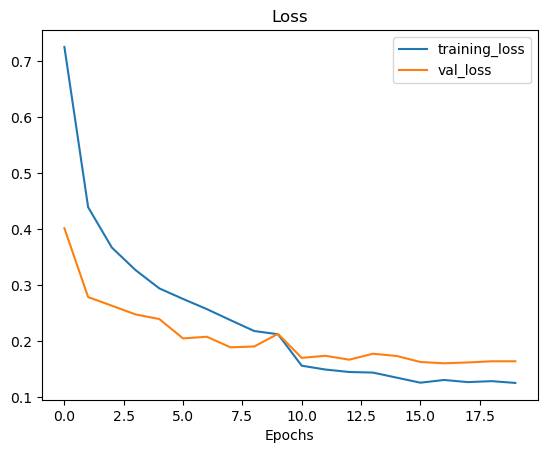

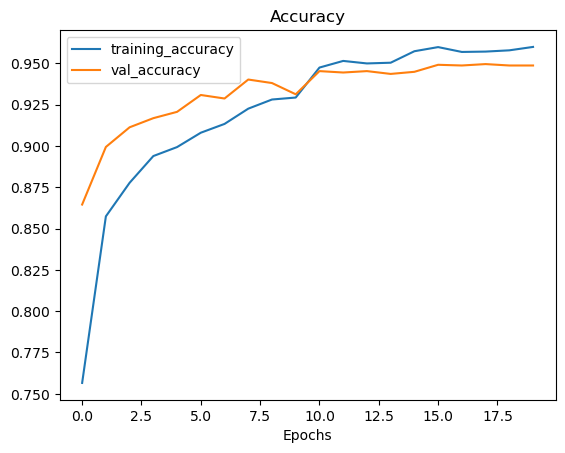

In [60]:
plot_loss_curves(ResNet50_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = ResNet50_model.evaluate(test_data, verbose=0)

[codecarbon INFO @ 00:45:46] Energy consumed for RAM : 0.019243 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:45:46] Energy consumed for all GPUs : 0.158805 kWh. Total GPU Power : 94.61337787200316 W
[codecarbon INFO @ 00:45:46] Energy consumed for all CPUs : 0.069590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:46] 0.247638 kWh of electricity used since the beginning.


In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.17238
Test Accuracy: 94.63%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = ResNet50_model.predict(test_data, verbose=1)

30/74 [===========>..................] - ETA: 13s

[codecarbon INFO @ 00:46:16] Energy consumed for RAM : 0.019341 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:46:16] Energy consumed for all GPUs : 0.159546 kWh. Total GPU Power : 83.86825813038257 W
[codecarbon INFO @ 00:46:16] Energy consumed for all CPUs : 0.069944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:46:16] 0.248831 kWh of electricity used since the beginning.


74/74 [==============================] - 24s 313ms/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.94      0.95      0.94        95
  biological       0.96      0.95      0.95        99
   cardboard       0.95      0.95      0.95       234
     clothes       0.99      0.99      0.99       533
       glass       0.97      0.88      0.92       409
       metal       0.84      0.97      0.90       188
       paper       0.96      0.94      0.95       272
     plastic       0.92      0.91      0.91       253
       shoes       0.95      0.98      0.97       199
       trash       0.86      0.96      0.91        84

    accuracy                           0.95      2366
   macro avg       0.93      0.95      0.94      2366
weighted avg       0.95      0.95      0.95      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

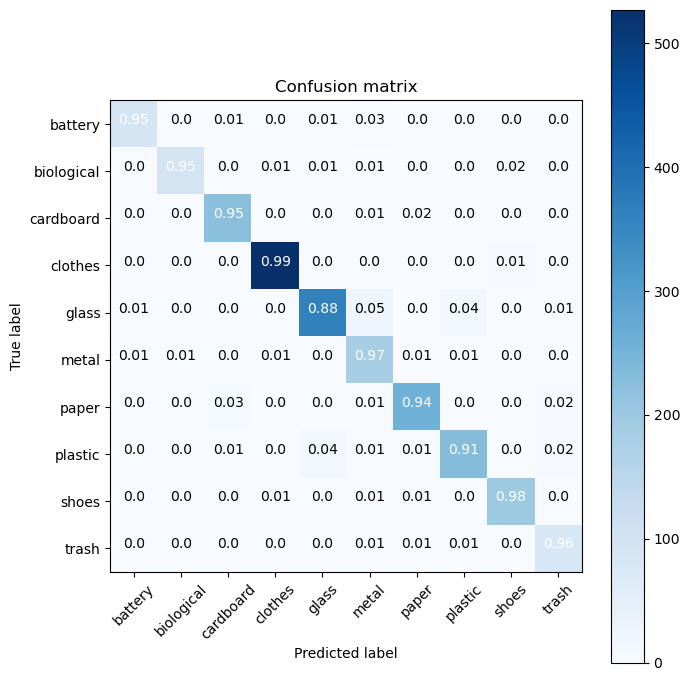

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon INFO @ 00:47:01] Energy consumed for RAM : 0.019488 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 00:47:01] Energy consumed for all GPUs : 0.160458 kWh. Total GPU Power : 60.59314858249855 W
[codecarbon INFO @ 00:47:01] Energy consumed for all CPUs : 0.070476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:47:01] 0.250422 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:47:02] [setup] RAM Tracking...
[codecarbon INFO @ 00:47:02] [setup] GPU Tracking...
[codecarbon INFO @ 00:47:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:47:02] [setup] CPU Tracking...
[codecarbon WARNING @ 00:47:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:47:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:47:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 00:47:04] >>> Tracker's metadata:
[codecarbo

Deploy Model Carbon Emissions: 0.11482722735960425 kg


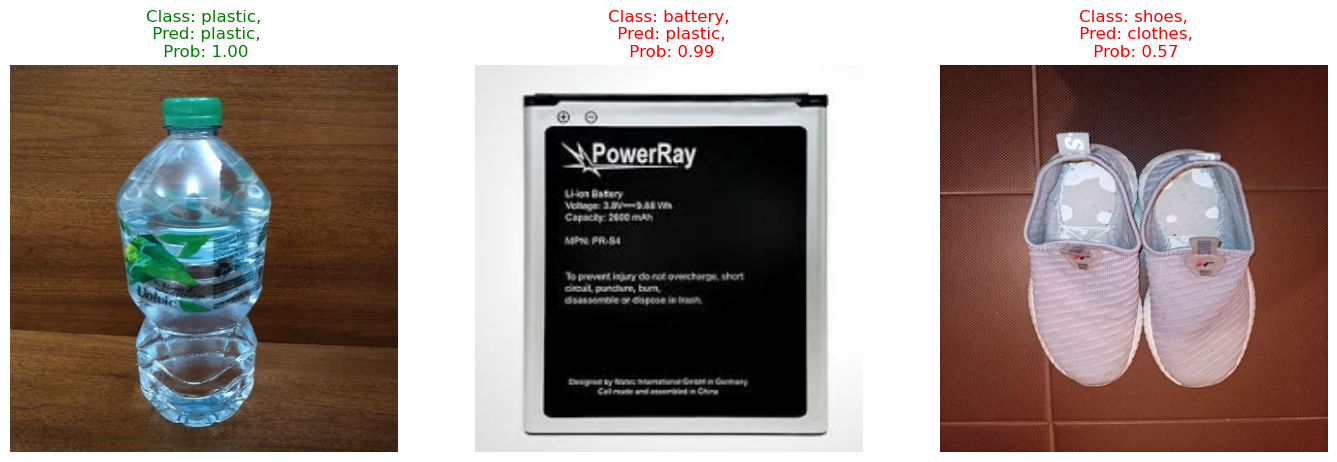

In [71]:
pred_random_images(ResNet50_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(ResNet50_model,open("ResNet50_model.h5","wb"))

In [73]:
ls ../working

ResNet50.h5         data/                      logs/
ResNet50_model.h5   emissions.csv              logs.zip
__notebook__.ipynb  garbage-classification.h5  runs/
